# deepBreaks applications
## Predicting the subtype of the HIV-1 virus based on its V3 amino-acid sequence   
PLACEHOLDER FOR DESCRIPTION
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1868395/
<p style="text-align:center;">
<figure>
  <img src="../img/HIV/v3.png" alt="V3" style="width: 400px;">
    <figcaption>Image from: <a size=10 href=https://doi.org/10.1371/journal.pcbi.0030058>Sander, Oliver, et al. "Structural descriptors of gp120 V3 loop for the prediction of HIV-1 coreceptor usage." PLoS computational biology 3.3 (2007): e58.</a> 
        </figcaption>
</figure>
</p>

In [14]:
#All neccessary packages to import for data process steps.
import mysql
#install mysql-connector-python // NOT mysql-connector
import mysql.connector
import argparse
import re
# importing deepBreaks libraries 
from deepBreaks import preprocessing as prp
from deepBreaks import visualization as viz
from deepBreaks import models as ml
import os
import datetime
import warnings
from pycaret.classification import *

In [ ]:
#STEP 0: Data Base Setup - Script 1 - Import heterologous.tsv into mySQL

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

In [ ]:
#STEP 0: Data Base Setup - Script 1 - Import opsindb.tsv into mySQL

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[11])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

In [15]:
#STEP 1: Extract Data From Vizphiz
#Output = 5 different 'version' // 'splits' of the data. 
#Take outputs and run through MAFFT before moving on to STEP2
#Suggested parameters for 'mafft' alignment are...
#Modify code so Bovine is always at top.
wd_output = 'wds.txt'
wd_ni_output = 'wds_ni.txt'
wd_ni_metadata = 'wds_ni_meta.txt'
class_ni_metadata = 'class_ni_meta.txt'
class_metadata = 'class_meta.txt'
m = 0
s = 0
l = 0
r = 0
c = 0
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()


for x in myresult:       

  if (x[4] in range(340, 360)):
    opclass = 0
  
  elif (x[4] in range(360, 380)):
    opclass = 1 

  elif (x[4] in range(380, 420)):
    opclass = 2

  elif (x[4] in range(420, 450)):
    opclass = 3 

  elif (x[4] in range(450, 480)):
    opclass = 4  
  
  elif (x[4] in range(480, 490)):
    opclass = 5  

  elif (x[4] in range(490, 495)):
    opclass = 6  

  elif (x[4] in range(495, 500)):
    opclass = 7 

  elif (x[4] in range(500, 505)):
    opclass = 8  

  elif (x[4] in range(505, 520)):
    opclass = 9

  else:
    opclass = 10

  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if m == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if (p.match(x[2])):
          pass
        else:
          if c == 1:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:
            c += 1 
            #This makes the fasta format file
            seq = ">S" + str(c)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

#METADATA SECTION
       with open(class_metadata, 'a') as h:
          #This makes the metadata formatted for a classification model. 
        if m == 1:
          h.write("\tOpsin_Class\n")
          h.write("Bovine\t" + str(opclass) + "\n")
        if(x[3]) == "NM_001014890.2":
          pass
        else:  
          md = "S" + str(m) + "\t" + str(opclass) + "\n"
          h.write(md)

       with open(class_ni_metadata, 'a') as h:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]')
        if p.match(x[2]):
          pass
          #This makes the metadata formatted for a classification model. 
        else:
          if c == 1:
            h.write("\tOpsin_Class\n")
            h.write("Bovine\t" + str(opclass) + "\n")
          if(x[3]) == "NM_001014890.2":
            pass
          else:    
            md = "S" + str(c) + "\t" + str(opclass) + "\n"
            h.write(md)

In [37]:
#STEP 2: Format Alignments for 'deepBreaks'
#REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2
#Suggested parameters for 'mafft' alignment are...
#FASTA fromat (sorted) , Strategy = G-INS-i , 
#enter list of aligned text files here.
inputs = ['wds_ni_aligned.txt']
##enter list of names for desired formatted fasta files here.
output = ['wds_ni_fmt.fasta']
i=0
k = 0
for files in inputs:
    lines = open(inputs[i]).readlines()
    file = open(output[i], 'a+')
    #line_count = len(lines)
    #tab_entry = ""
    #call = input("How Many Lines Per Alignment?: ")
    #count = int(call)
    #loop = range(int(count))
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

In [38]:
#STEP 3: deepBreaks - THIS IS A LONG SECTION! STEP 4 doesn't start until box Cell 40
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [39]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = 'wds_ni_fmt.fasta' 
meta_data = 'class_ni_meta.tsv'
# name of the phenotype
mt = 'Opsin_Class'

# type of the sequences
seq_type = 'amino-acid'
# type of the analysis if it is a classification model, then we put cl instead of reg
anaType = 'cl'
sampleFrac=1

In [40]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [41]:
%%time
# importing sequences data
print('reading fasta file')
df = prp.read_data(seqFileName, seq_type = seq_type, is_main=True)
metaData = prp.read_data(meta_data, is_main=False)
positions = df.shape[1]
print('Done')
print('Shape of data is: ', df.shape)

reading fasta file
Done
Shape of data is:  (685, 497)
CPU times: total: 156 ms
Wall time: 163 ms


In [42]:
df.head()

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10  ... p488 p489 p490  \
Bovine  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
S137    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
S58     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
S141    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
S142    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

       p491 p492 p493 p494 p495 p496 p497  
Bovine  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
S137    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
S58     NaN  NaN  NaN  NaN  NaN  NaN  NaN  
S141    NaN  NaN  NaN  NaN  NaN  NaN  NaN  
S142    NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 497 columns]

**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [43]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


Opsin_Class
S1            8
S2            8
S3            5
S4            6
S5            6

In [44]:
# selecting only the classes with enough number of samples
df = prp.balanced_classes(dat=df, meta_dat=metaData, feature=mt)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [45]:
%%time
# taking care of missing data
print('Shape of data before missing/constant care: ', df.shape)
df = prp.missing_constant_care(df)
print('Shape of data after missing/constant care: ', df.shape)

Shape of data before missing/constant care:  (685, 497)
Shape of data after missing/constant care:  (685, 289)
CPU times: total: 109 ms
Wall time: 109 ms


In [46]:
%%time
# taking care of ultra-rare cases
print('Shape of data before imbalanced care: ', df.shape)
df = prp.imb_care(dat=df)
print('Shape of data after imbalanced care: ', df.shape)

Shape of data before imbalanced care:  (685, 289)
Shape of data after imbalanced care:  (685, 269)
CPU times: total: 562 ms
Wall time: 565 ms


In [47]:
%%time
# Use statistical tests to drop redundant features.
print('number of columns of main data befor: ', df.shape[1])
df_cleaned = prp.redundant_drop(dat=df, meta_dat=metaData,
                        feature=mt, model_type=anaType,
                        threshold=0.25,
                        report_dir=report_dir)
print('number of columns of main data after: ', df_cleaned.shape[1])

number of columns of main data befor:  269
number of columns of main data after:  269
CPU times: total: 2.02 s
Wall time: 2.03 s


In [48]:
%%time
print('one-hot encoding the dataset')
df_cleaned = prp.get_dummies(dat=df_cleaned, drop_first=True)



one-hot encoding the dataset
CPU times: total: 125 ms
Wall time: 113 ms


In [49]:
%%time
print('calculating the distance matrix')
cr = prp.distance_calc(dat=df_cleaned,
                       dist_method='correlation',
                       report_dir=report_dir)
print(cr.shape)

calculating the distance matrix
(697, 697)
CPU times: total: 609 ms
Wall time: 611 ms


In [50]:
print('The distance matrix looks like this.\n The values are between 0 (exact the same) and 1 (non-related).')
cr.head()

The distance matrix looks like this.
 The values are between 0 (exact the same) and 1 (non-related).


p59_G     p59_S     p61_I     p61_W     p61_Y     p62_E     p62_L  \
p59_G  0.000000  0.107852  0.786017  0.208287  0.619322  0.528999  0.813390   
p59_S  0.107852  0.000000  0.699174  0.293675  0.607761  0.609100  0.787363   
p61_I  0.786017  0.699174  0.000000  0.865935  0.869161  0.814258  0.929397   
p61_W  0.208287  0.293675  0.865935  0.000000  0.692796  0.334699  0.834227   
p61_Y  0.619322  0.607761  0.869161  0.692796  0.000000  0.846162  0.901980   

          p63_G     p63_V     p63_Y  ...    p432_G  p432_INQP    p432_S  \
p59_G  0.280736  0.792691  0.399664  ...  0.415277   0.844354  0.721206   
p59_S  0.275559  0.767630  0.439867  ...  0.398478   0.942797  0.763083   
p61_I  0.834538  0.930097  0.897495  ...  0.800714   0.799967  0.926641   
p61_W  0.189754  0.835871  0.485360  ...  0.532087   0.865935  0.635719   
p61_Y  0.620852  0.904122  0.444812  ...  0.815510   0.869161  0.844254   

         p432_T    p434_E  p434_SGQTA    p434_V    p435_E  p435_NKA    p435_S  
p59_G  0.508911  0.902388    0.920521  0.796888  0.517450  0.667652  0.354460  
p59_S  0.561876  0.890560    0.778502  0.772334  0.510659  0.703496  0.290760  
p61_I  0.916841  0.936224    0.933674  0.931512  0.837288  0.245902  0.924871  
p61_W  0.379714  0.964977    0.844270  0.839194  0.617959  0.867861  0.308657  
p61_Y  0.809446  0.941341    0.888359  0.764405  0.471505  0.886571  0.775205  

[5 rows x 697 columns]

In [51]:
%%time
print('finding colinear groups')
dc_df = prp.db_grouped(dat = cr,
                       report_dir=report_dir,
                       threshold=.3,
                       needs_pivot=False)

finding colinear groups
CPU times: total: 31.2 ms
Wall time: 43 ms


In [52]:
print('The result of the last step is a dataframe with two columns,\
1)feature and 2)group.\nif there are no groups, it will be an empty dataframe')
dc_df.head()

The result of the last step is a dataframe with two columns,1)feature and 2)group.
if there are no groups, it will be an empty dataframe


feature group
0   p59_G    g0
1   p59_S    g0
2   p61_I    g1
3   p61_W    g0
4   p61_Y    g2

Then, we pass the above calculated groupes into the *group_feature* function. This function finds the distance of all the group members to the center of the group (median). The result will be a dictionary of columns like this:  
\
{\
group1_representativ:[member1, member2,...],  
group2_representativ:[member1, member2,...],...  
}

In [53]:
%%time
print('grouping features')
dc = prp.group_features(dat=df_cleaned,
                        group_dat=dc_df,
                        report_dir=report_dir)
file2 = open('dc_cols.txt', 'a+')
training = str(dc)
file2.write(training)
file2.close()                      

grouping features
CPU times: total: 62.5 ms
Wall time: 70 ms


In [54]:
print('dropping correlated features')
print('Shape of data before collinearity care: ', df_cleaned.shape)
df_cleaned = prp.cor_remove(df_cleaned, dc)
print('Shape of data after collinearity care: ', df_cleaned.shape)
file2 = open('train_cols.txt', 'a+')
training = (df_cleaned.to_string())
file2.write(training)
file2.close()
#USE FOR TRAIN COLS! It's the correct format. Import into excel. 

training_col_list = df_cleaned.columns.tolist()

dropping correlated features
Shape of data before collinearity care:  (685, 697)
Shape of data after collinearity care:  (685, 201)


In [55]:
#merge with meta data
df = df.merge(metaData[mt], left_index=True, right_index=True)
df_cleaned = df_cleaned.merge(metaData[mt], left_index=True, right_index=True)

file2 = open('testing_cols.txt', 'a+')
raw_training = df.to_string()
training = df_cleaned.to_string()
file2.write(raw_training)
file2.write(training)
file2.close()

## Modelling
In this step, we try to fit multiple models to the training dataset and rank them based on their performance. By default, we select the top 3 three models for further analysis.  
During this step, deepBreaks creates a CSV file containing all the fitted models with their performance metrics. These metrics are based on an average of 10-fold cross-validation.

In [56]:
%%time
models_to_select = 3 # number of top models to select
top_models, train_cols, model_names = ml.fit_models(dat = df_cleaned,
                                                    meta_var=mt,
                                                    model_type=anaType, 
                                                    models_to_select=models_to_select,
                                                    report_dir=report_dir)

CPU times: total: 29.7 s
Wall time: 27.2 s


## Interpretation 
In this step, we use the training data set, positions, and the top models to report the most discriminative positions in the sequences associated with the phenotype.  
we report the feature importances for all top models separately and make a box plot (regression) or stacked bar plot (classification) for the top 4 positions.

Light Gradient Boosting MachineDone
Light Gradient Boosting Machine  Done
Gradient Boosting ClassifierDone
Gradient Boosting Classifier  Done
Extreme Gradient BoostingDone
Extreme Gradient Boosting  Done


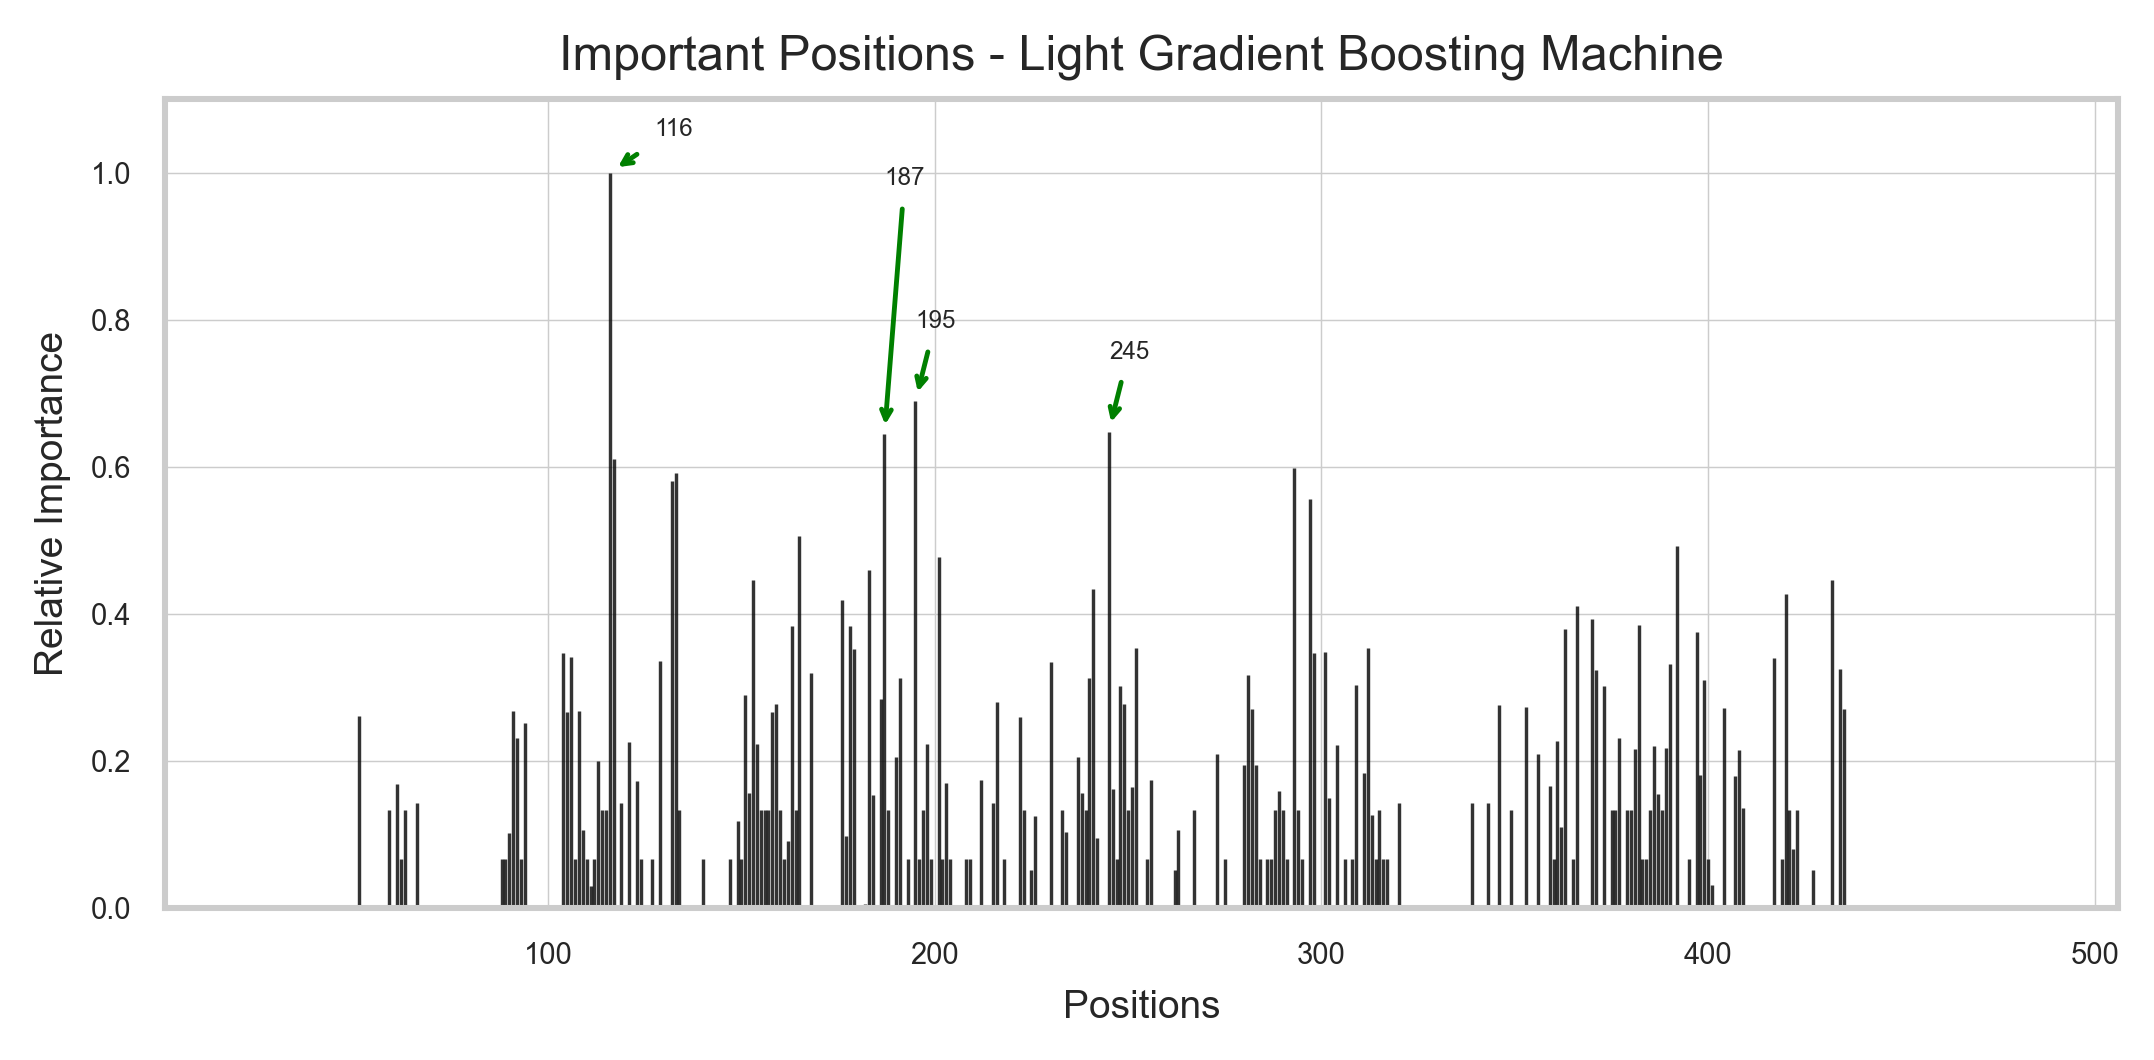

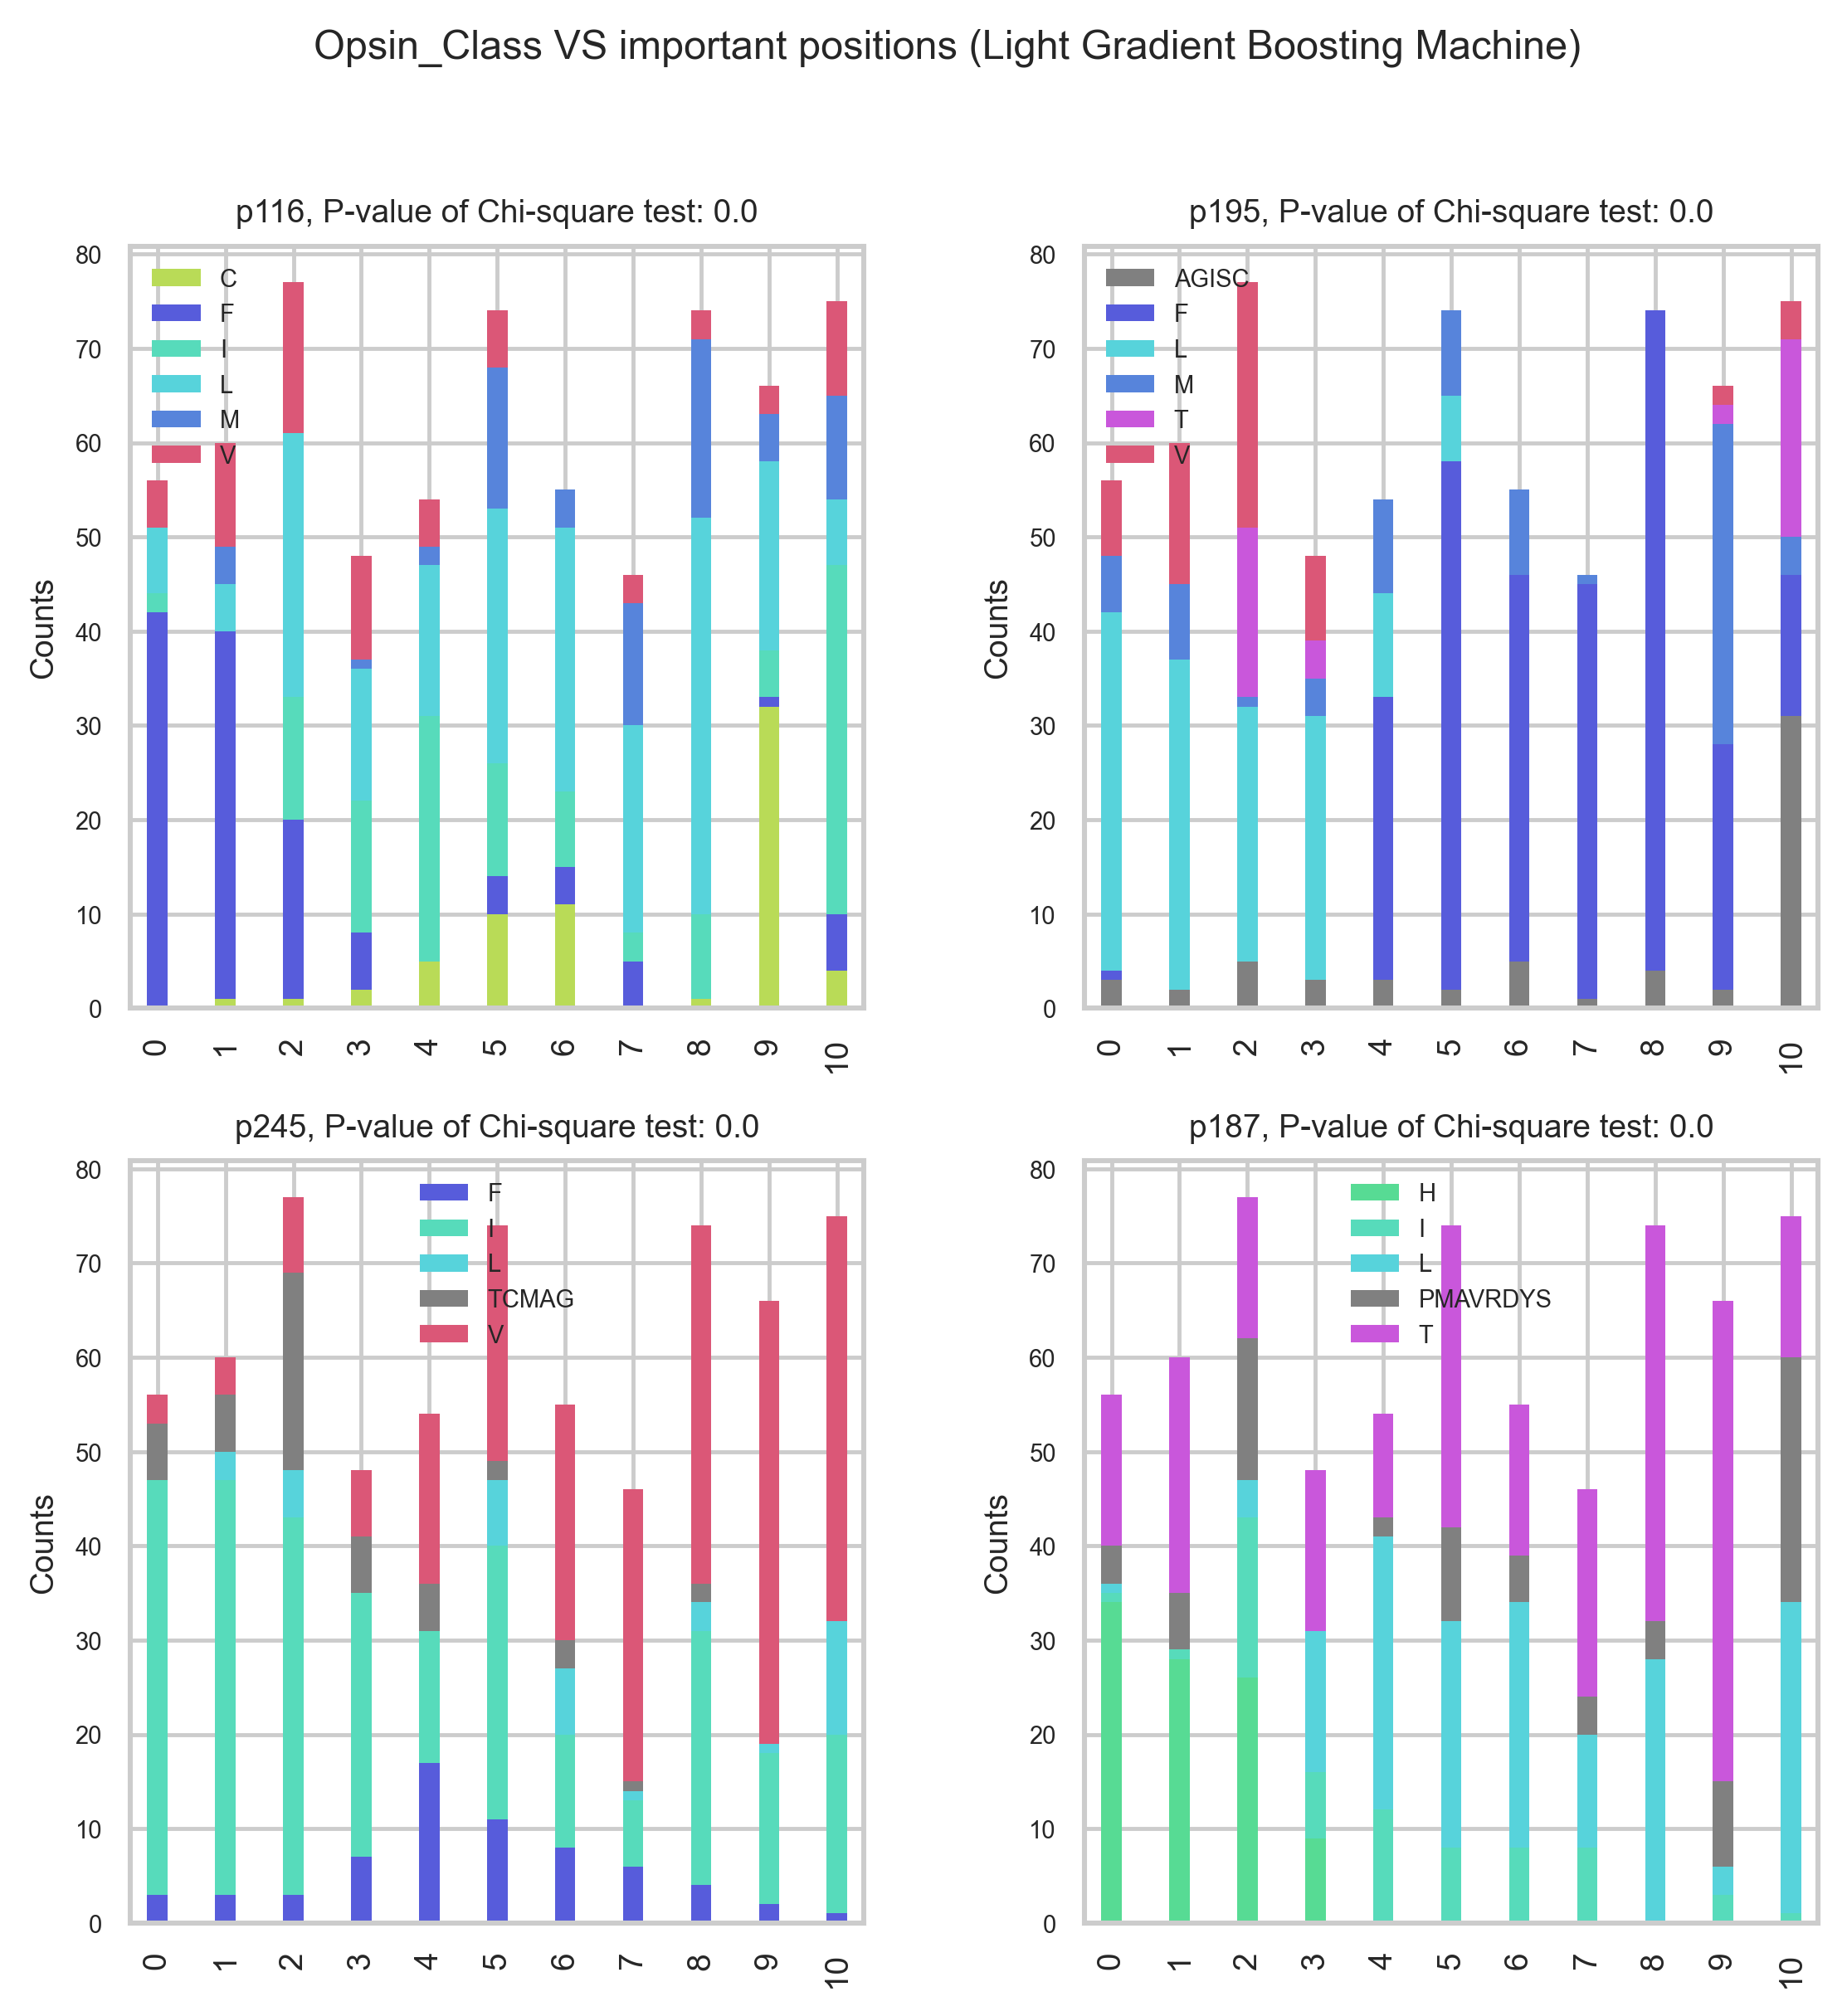

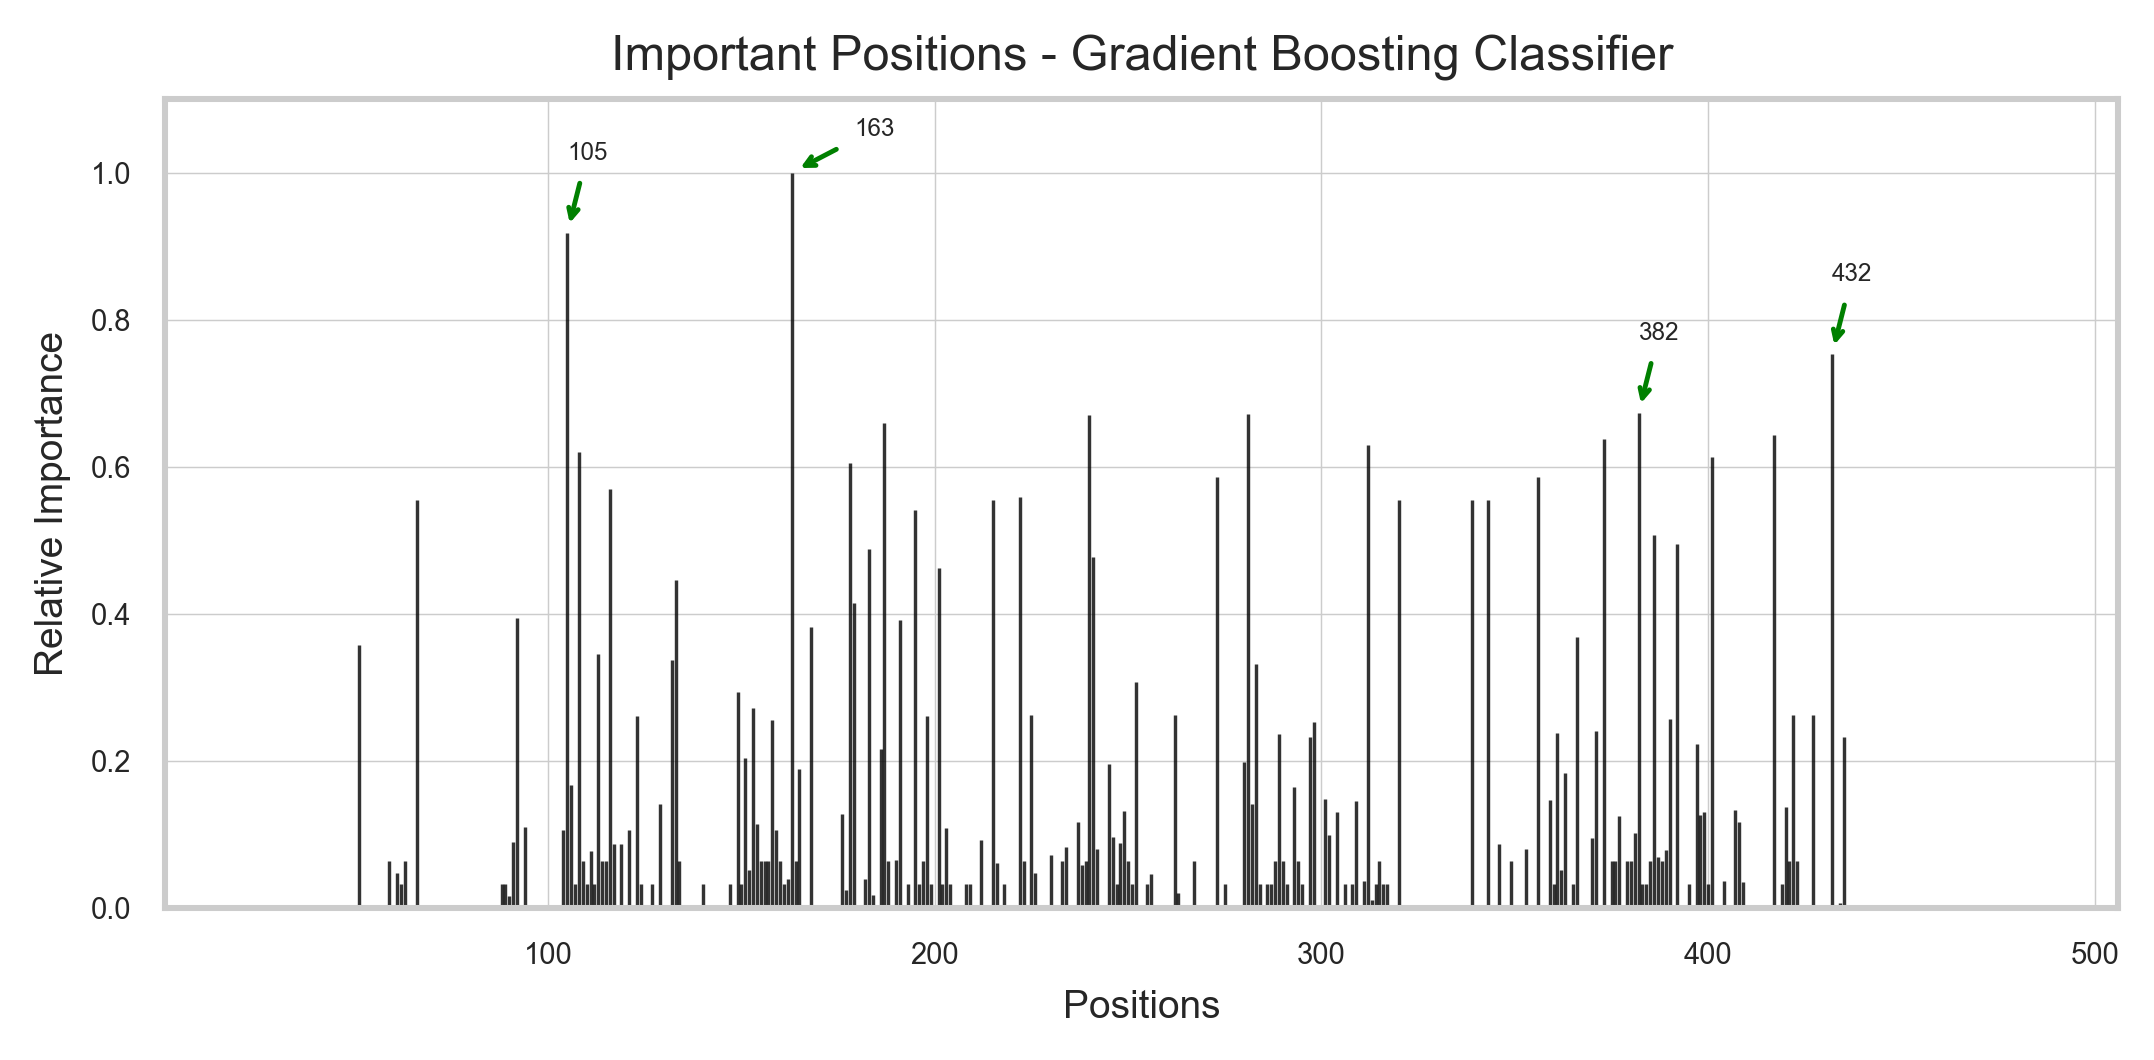

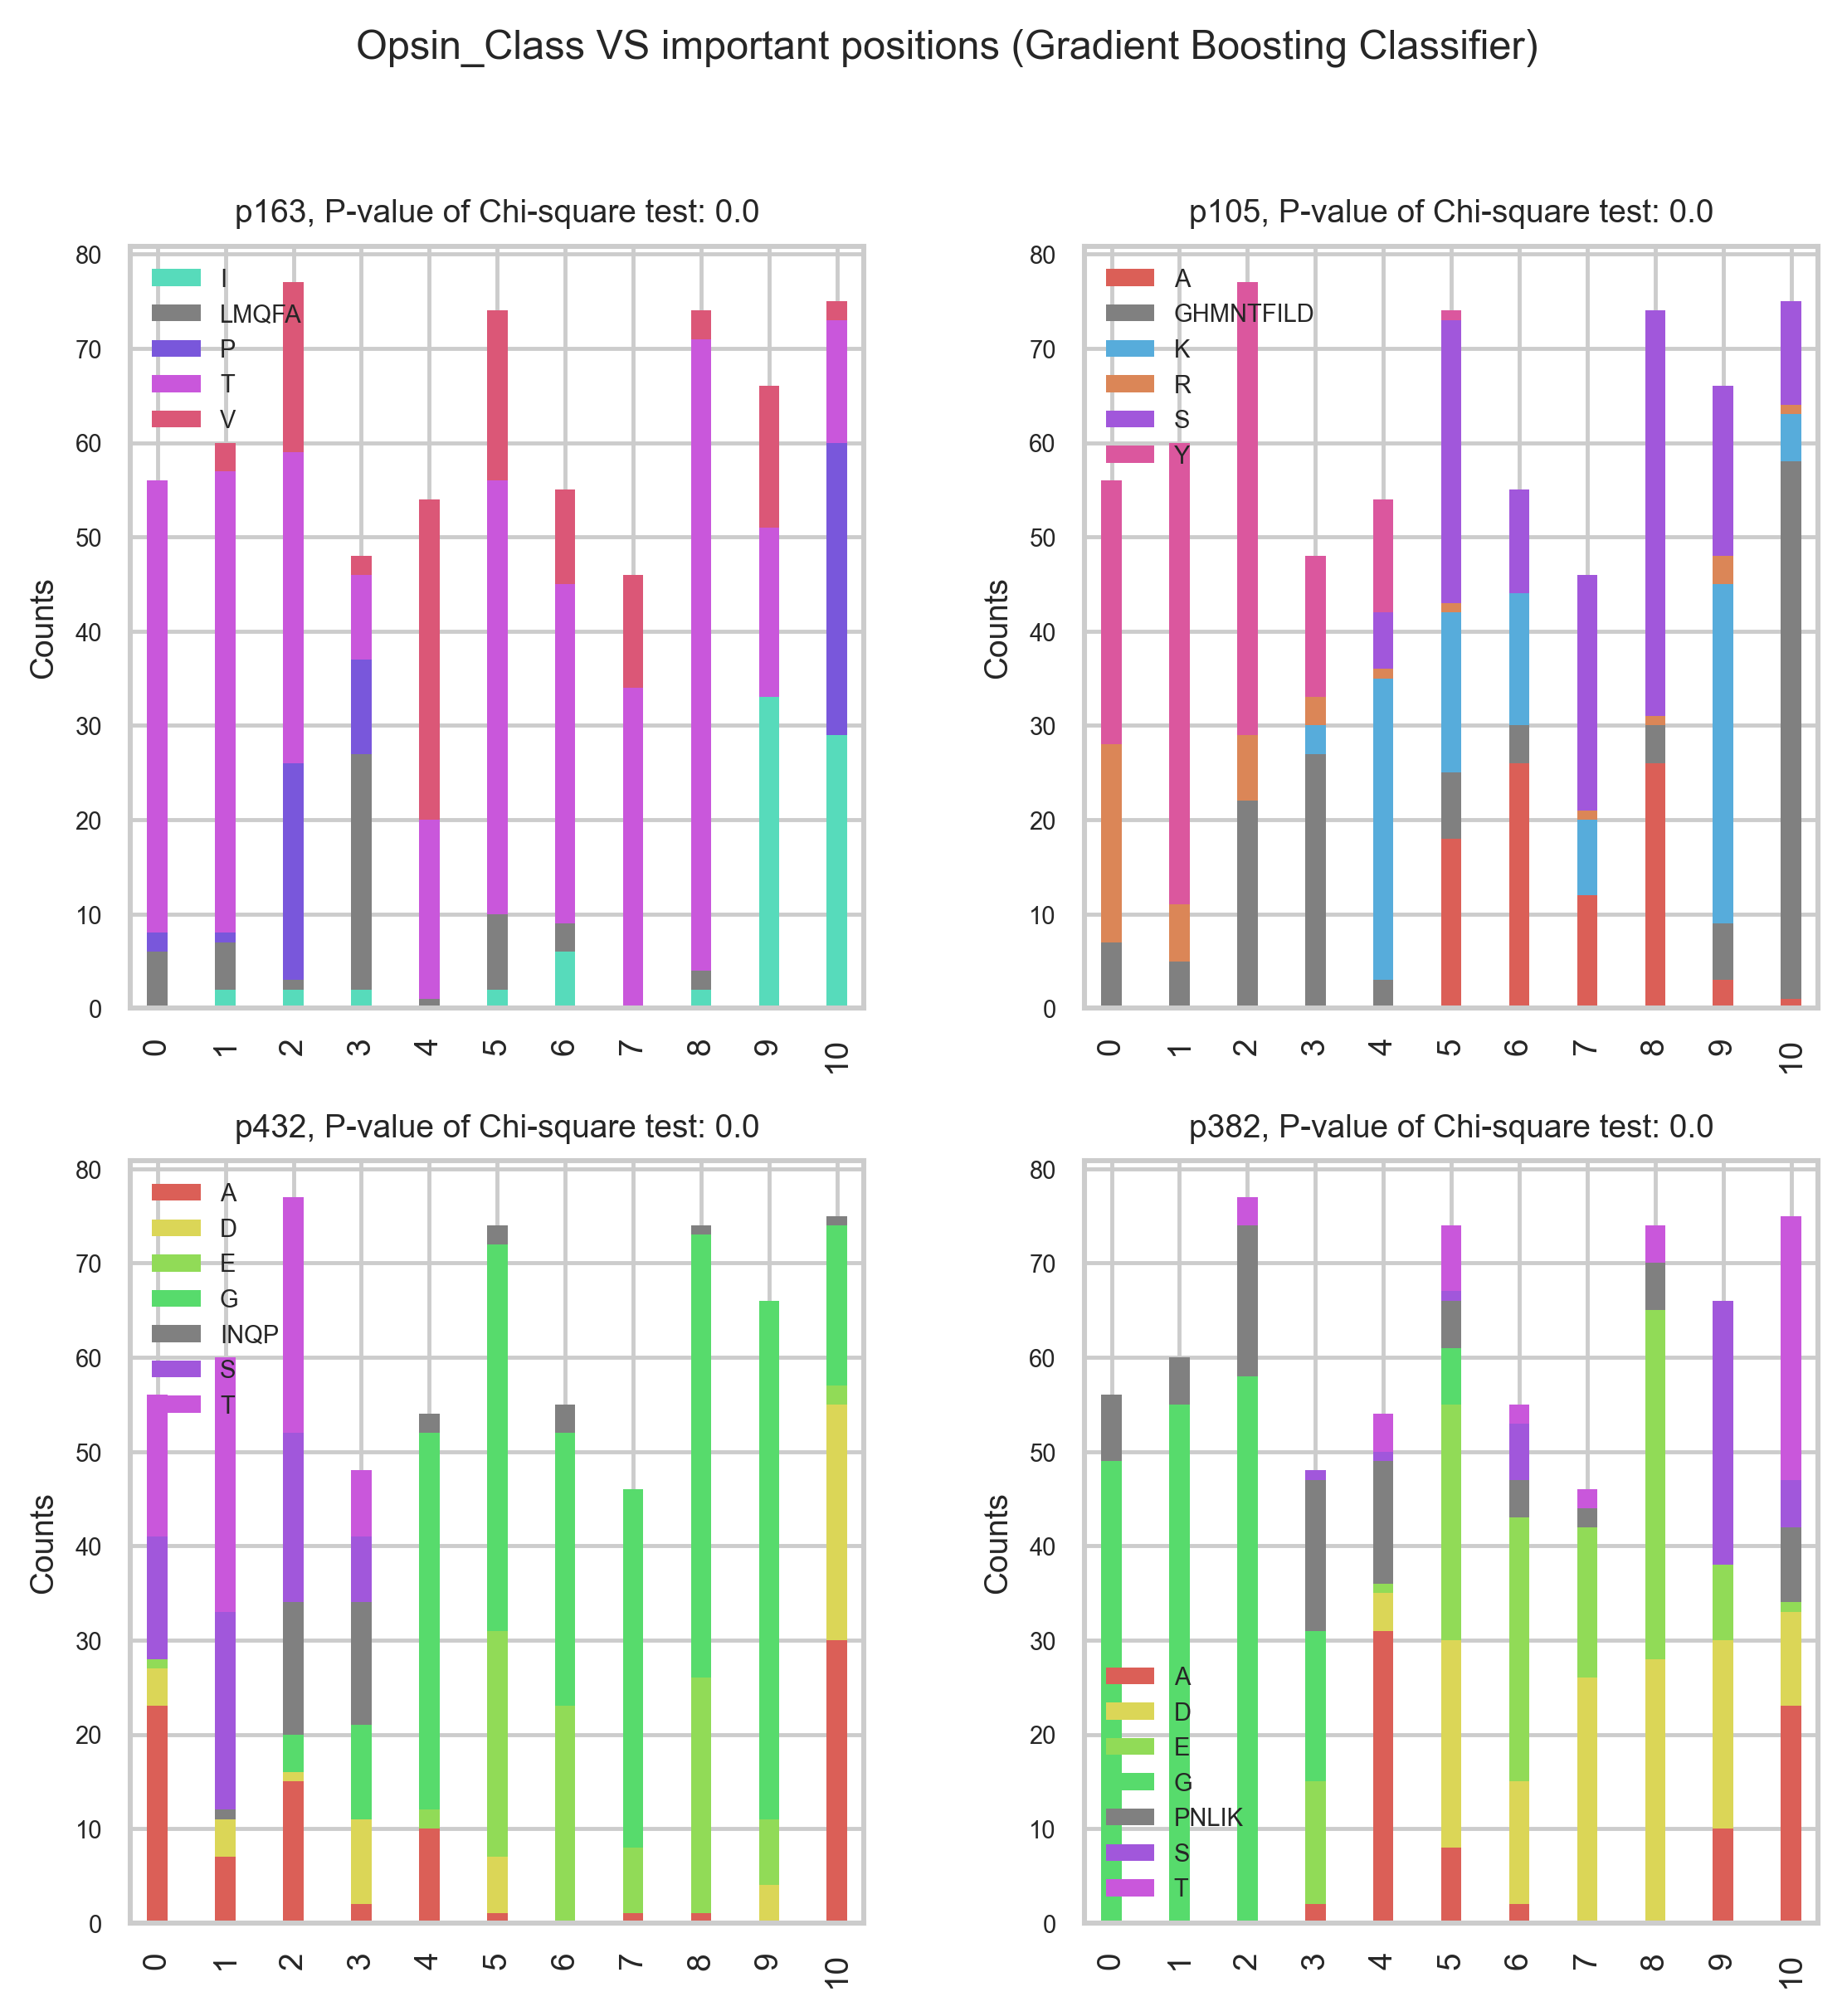

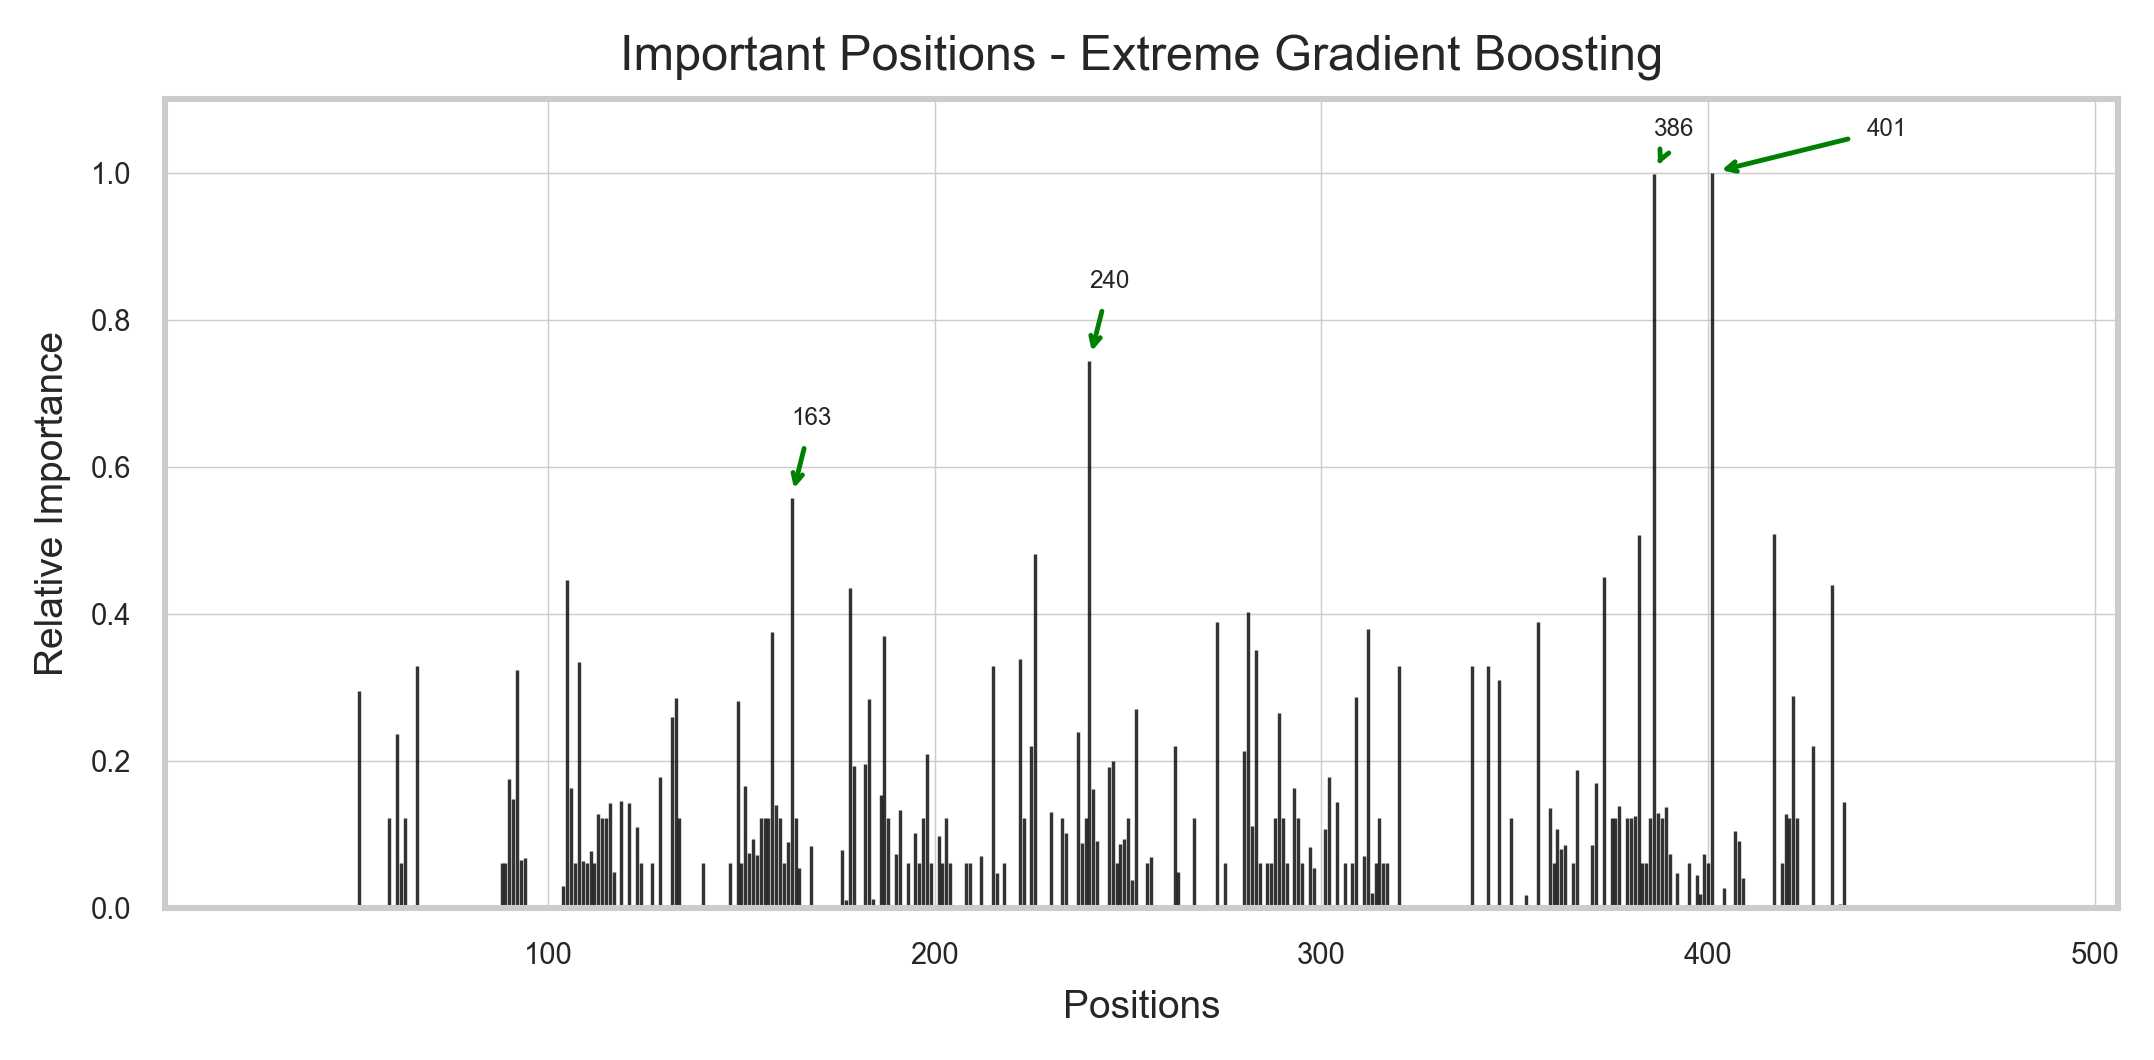

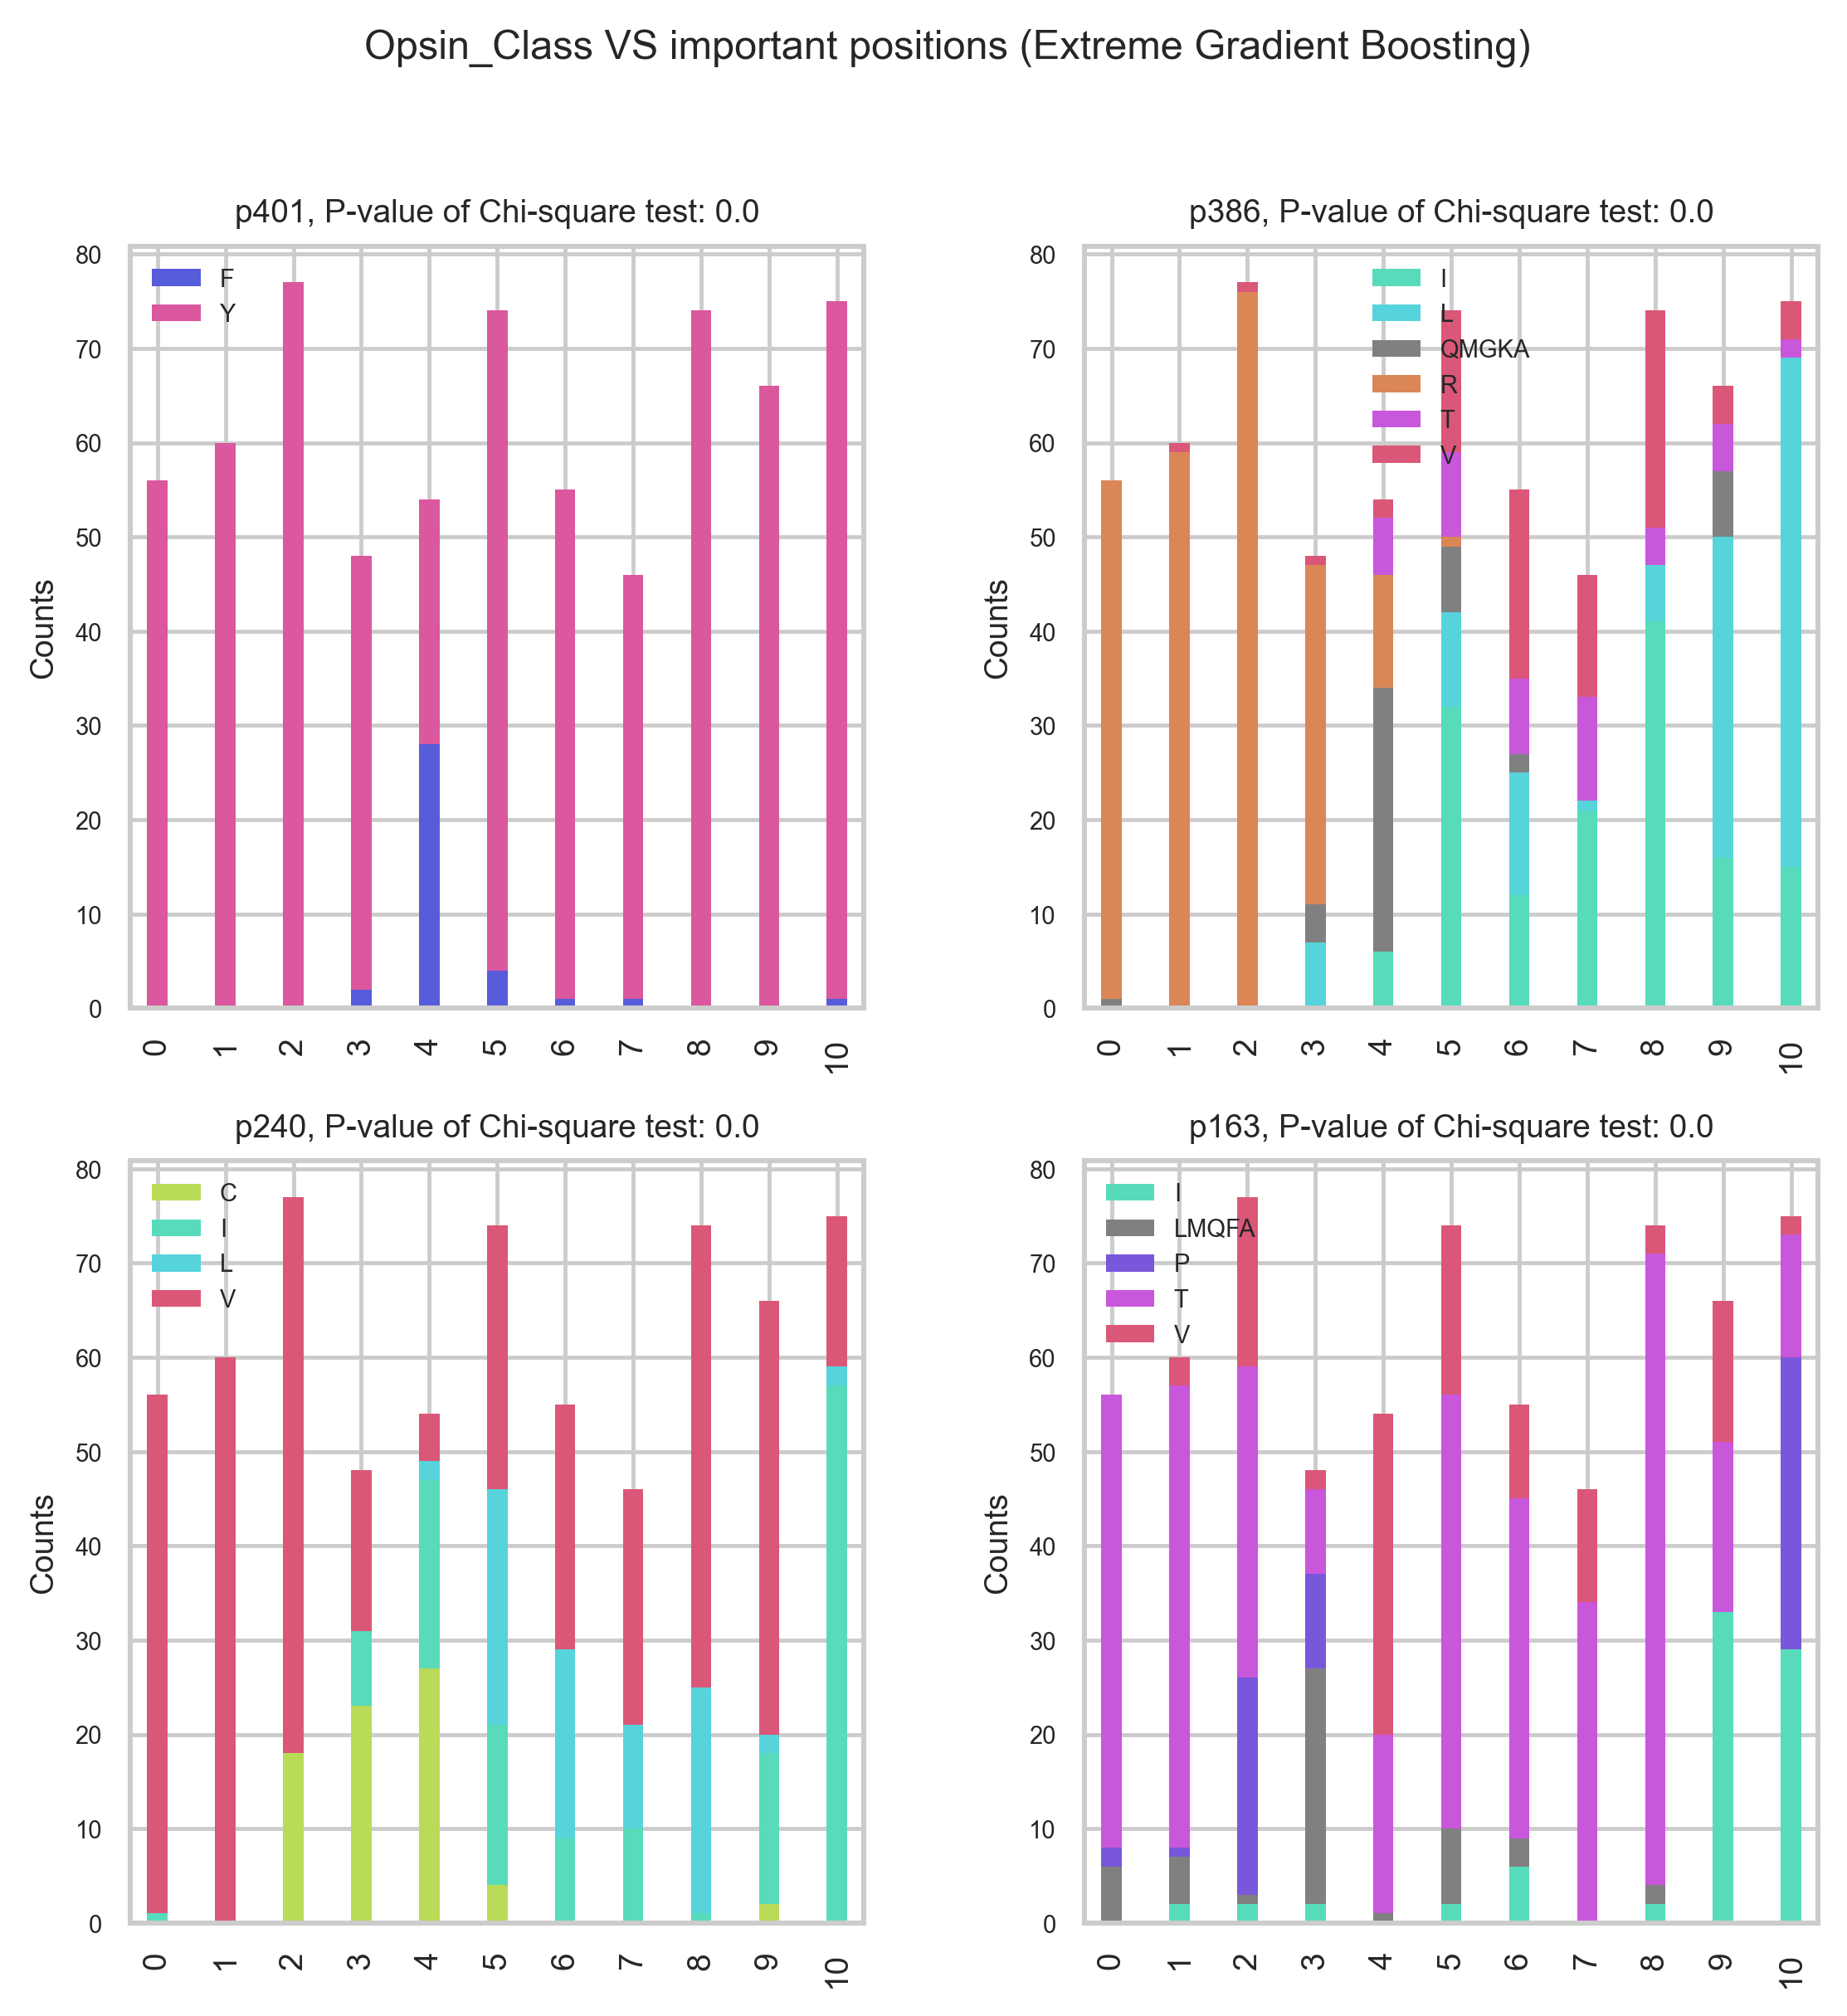

In [57]:
for i in range(models_to_select):
    # calculate the featre importances
    imp = ml.fimp_single(trained_model=top_models[i], model_name=model_names[i],
                         train_cols=train_cols, grouped_features=dc,
                         n_positions=positions, report_dir=report_dir)
    # visualize the lollipop plot for features based on each model
    viz.dp_plot(dat = imp, model_name= model_names[i],imp_col='standard_value', report_dir=report_dir)
    
    # visualize the boxplots for features based on each model
    viz.plot_imp_model(dat=df, trained_model=top_models[i],
                       model_name=model_names[i],
                       train_cols=train_cols, grouped_features=dc,
                       meta_var=mt, n_positions=positions,
                       model_type=anaType, report_dir=report_dir)

    file2 = open('interpret_cols.txt', 'a+')
    training = str(df.to_string)
    file2.write(training)
    file2.close()

meanDone


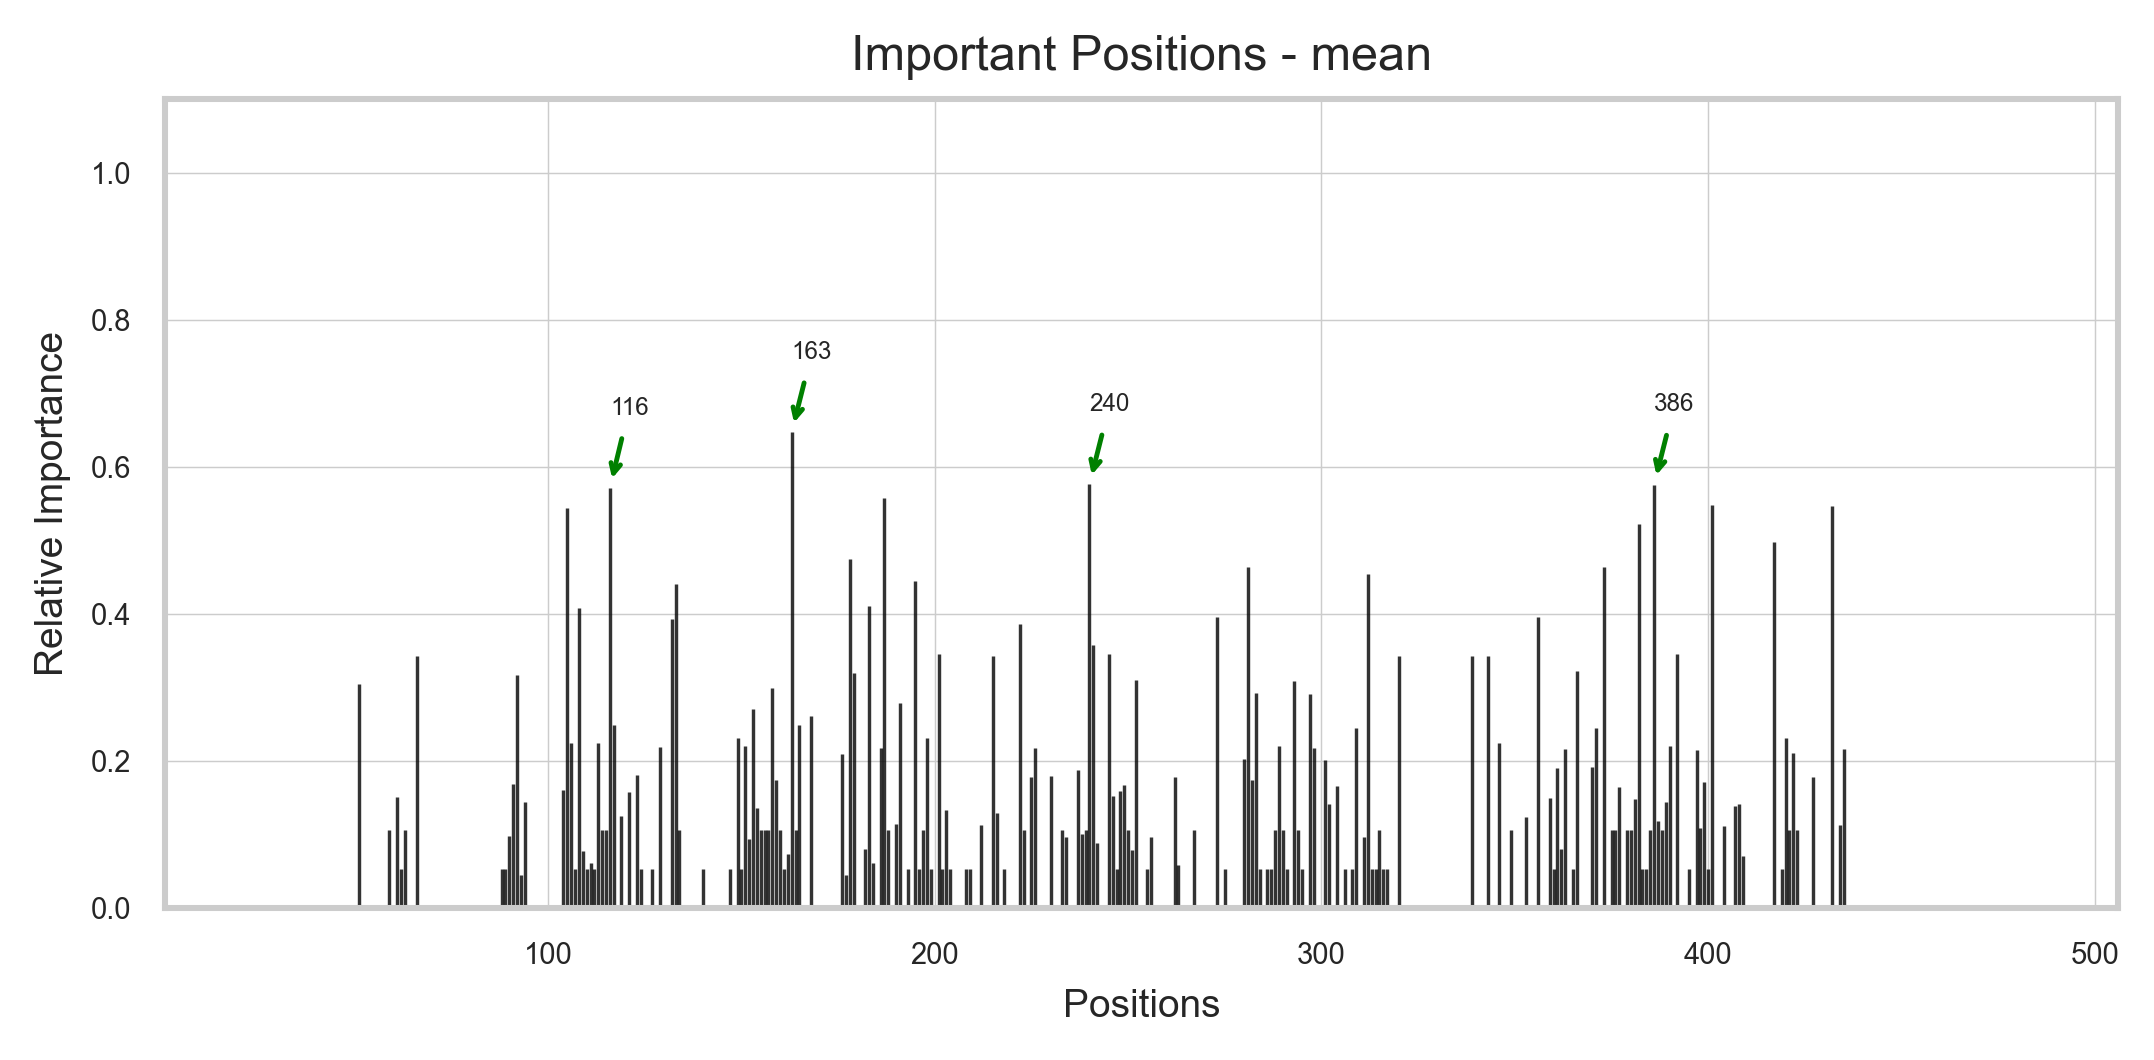

In [58]:
# merging the results for all the top models
mean_imp = ml.fimp_top_models(trained_models=top_models, model_names=model_names, 
                              train_cols=train_cols,grouped_features=dc,
                              n_positions=positions,report_dir=report_dir)

# lollipop plot for the merged results
viz.dp_plot(dat=mean_imp,
            model_name= 'mean',
            imp_col='mean_imp', 
            report_dir=report_dir)

<span style="color:red">**Running the next cell will produce individual plots for all of the positions in you sequence.**</span>

{'p116': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p116, P-value: 0.0'}, ylabel='Counts'>),
 'p195': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p195, P-value: 0.0'}, ylabel='Counts'>),
 'p245': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p245, P-value: 0.0'}, ylabel='Counts'>),
 'p187': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p187, P-value: 0.0'}, ylabel='Counts'>),
 'p117': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p117, P-value: 0.0'}, ylabel='Counts'>),
 'p293': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p293, P-value: 0.0'}, ylabel='Counts'>),
 'p133': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p133, P-value: 0.0'}, ylabel='Counts'>),
 'p132': (<Figure size 700x1050 with 1 Axes>,
  <AxesSubplot: title={'center': 'p132, P-value: 0.0'}, ylabel='Counts'>),
 'p297': (<Figure size 700x1050 

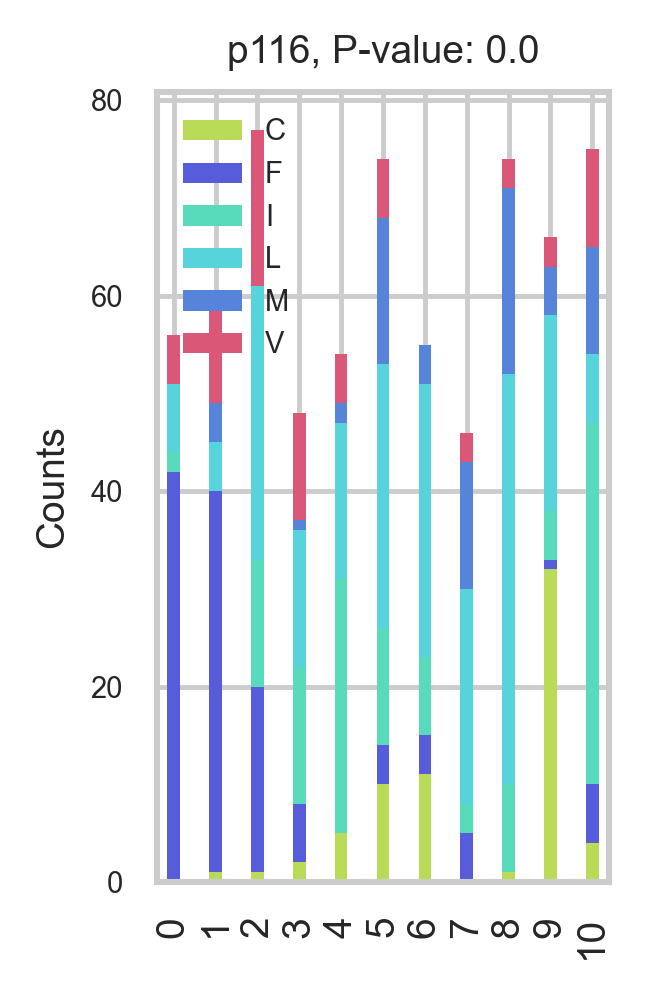

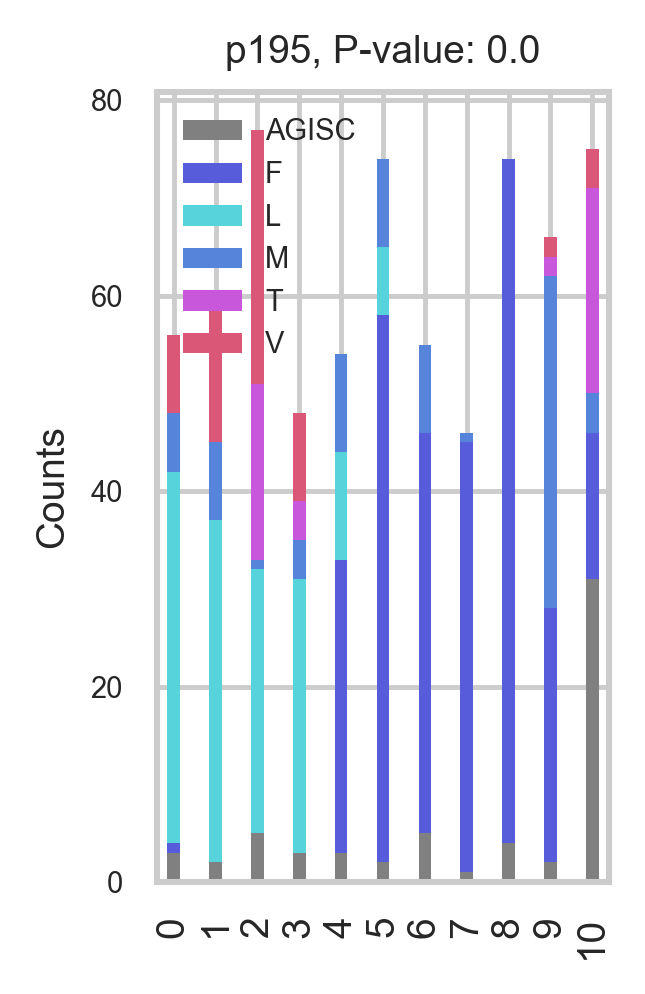

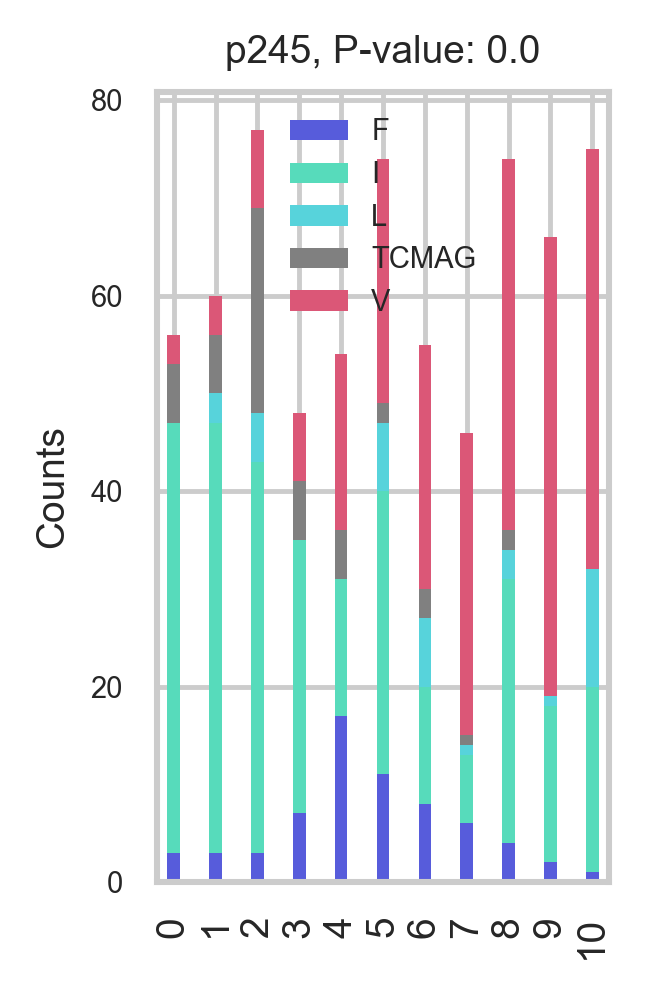

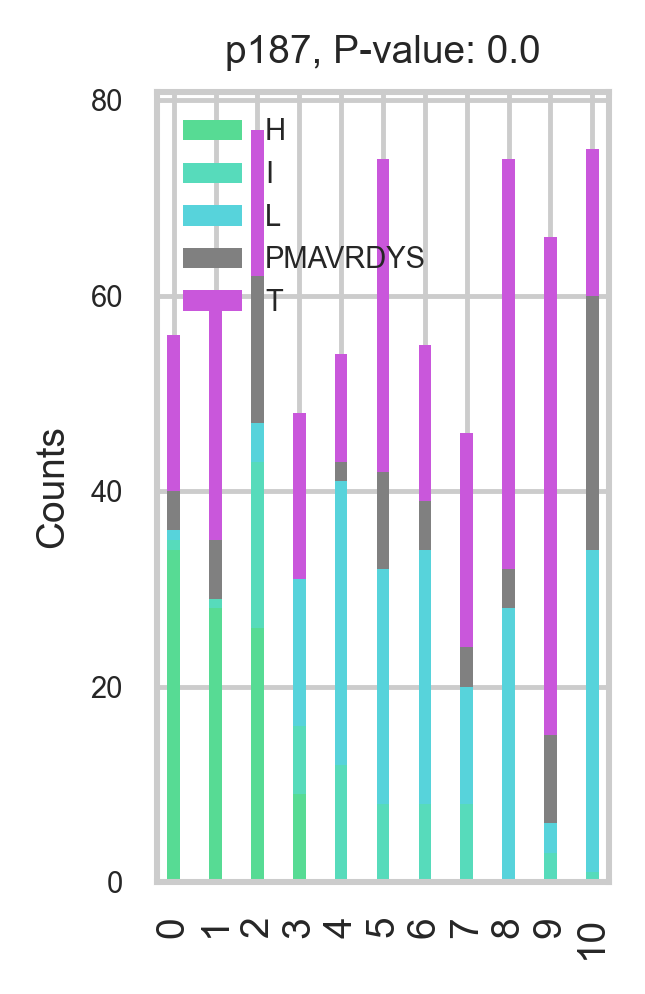

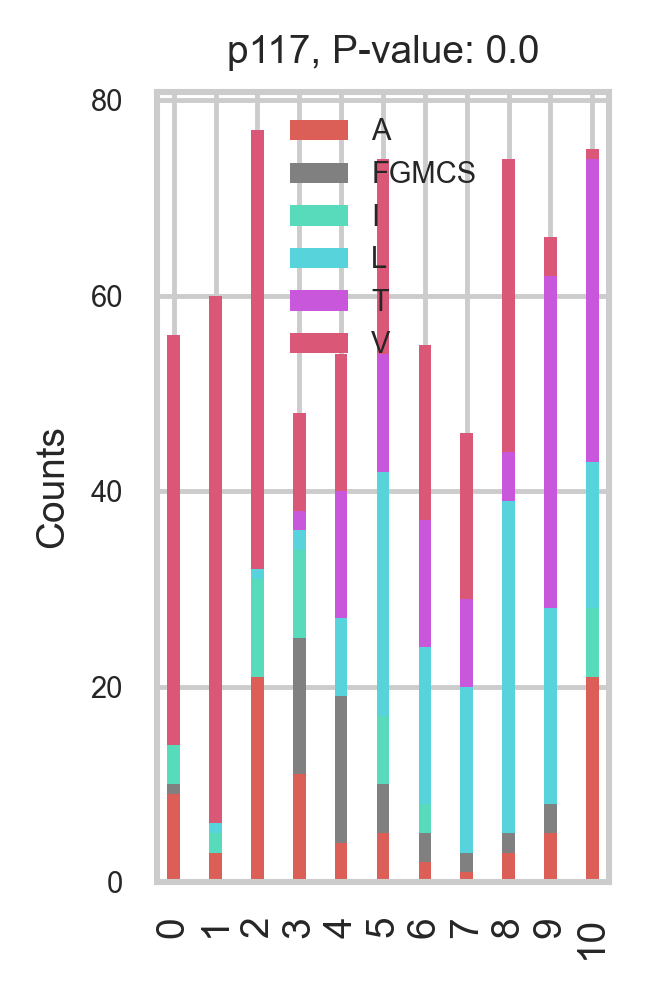

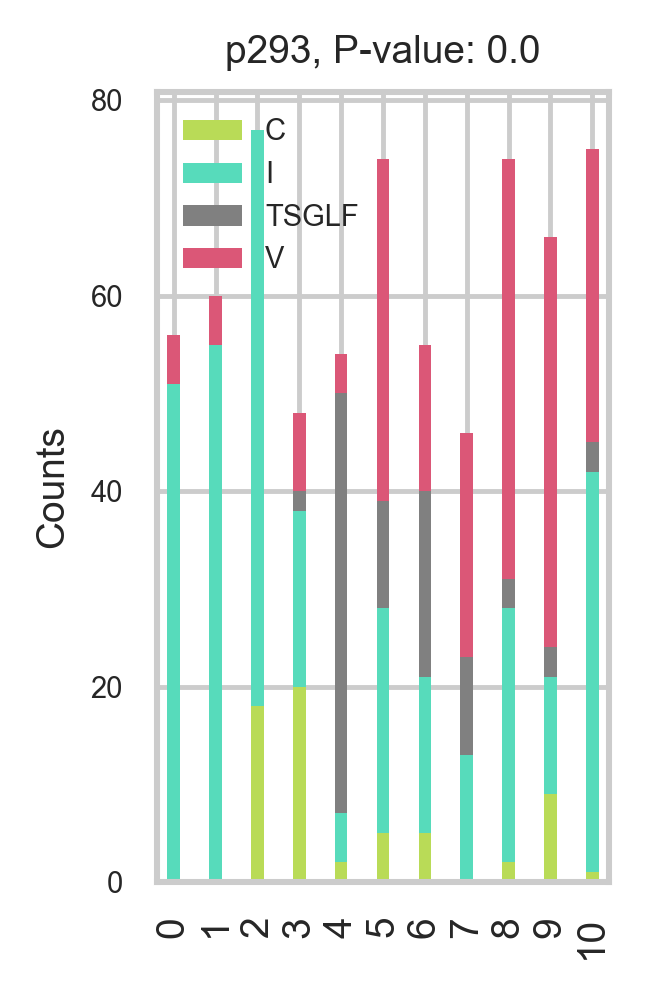

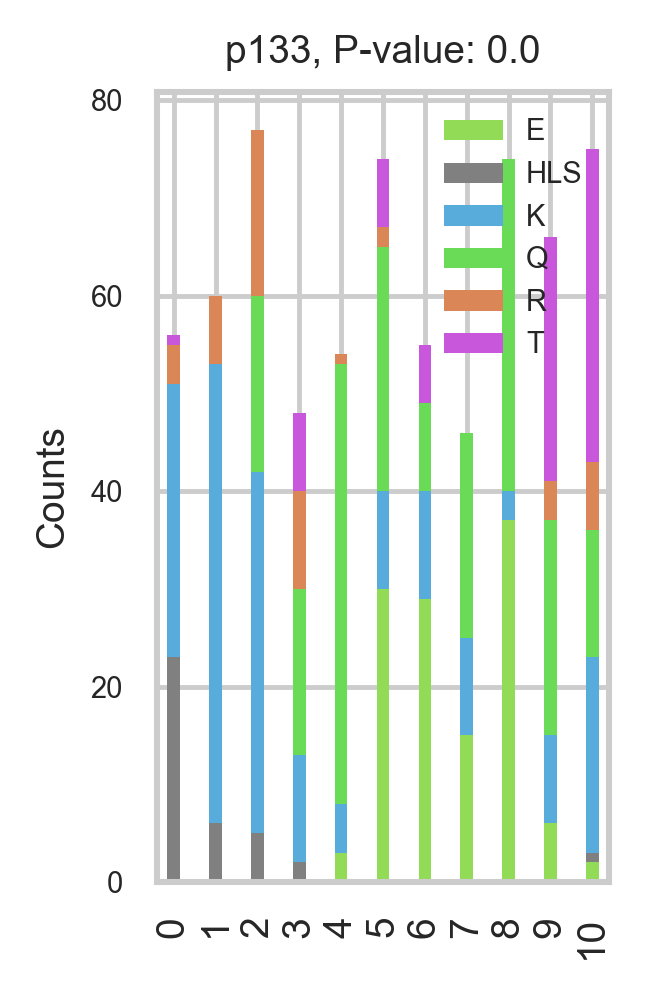

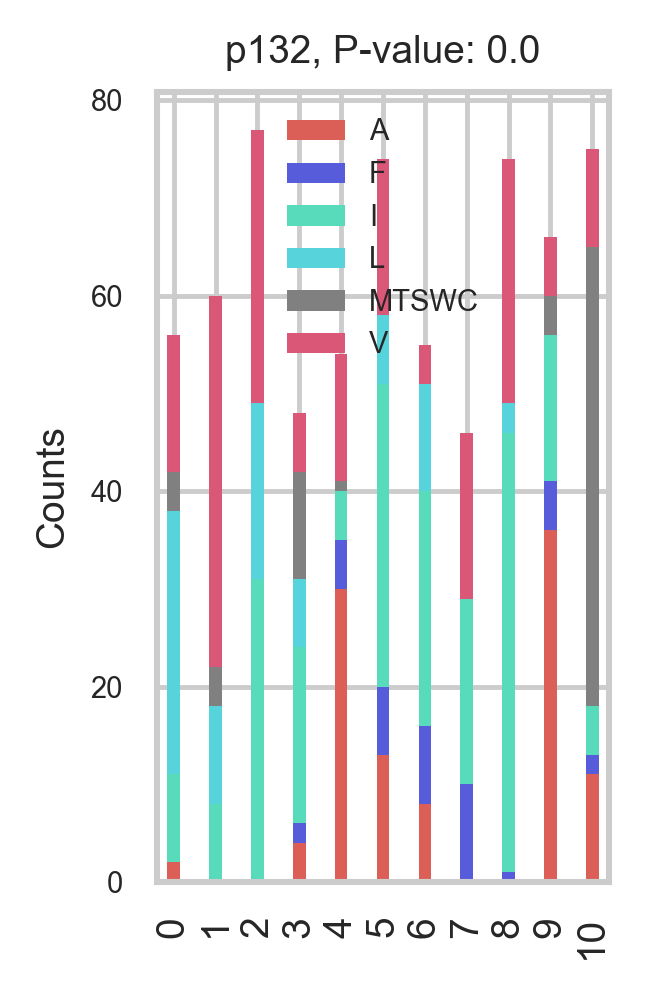

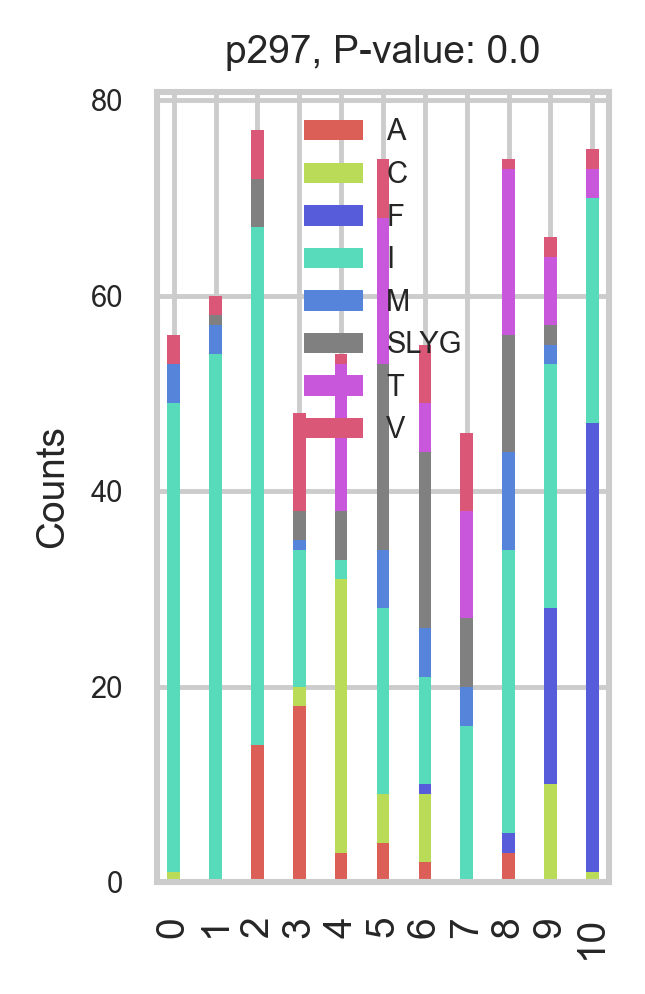

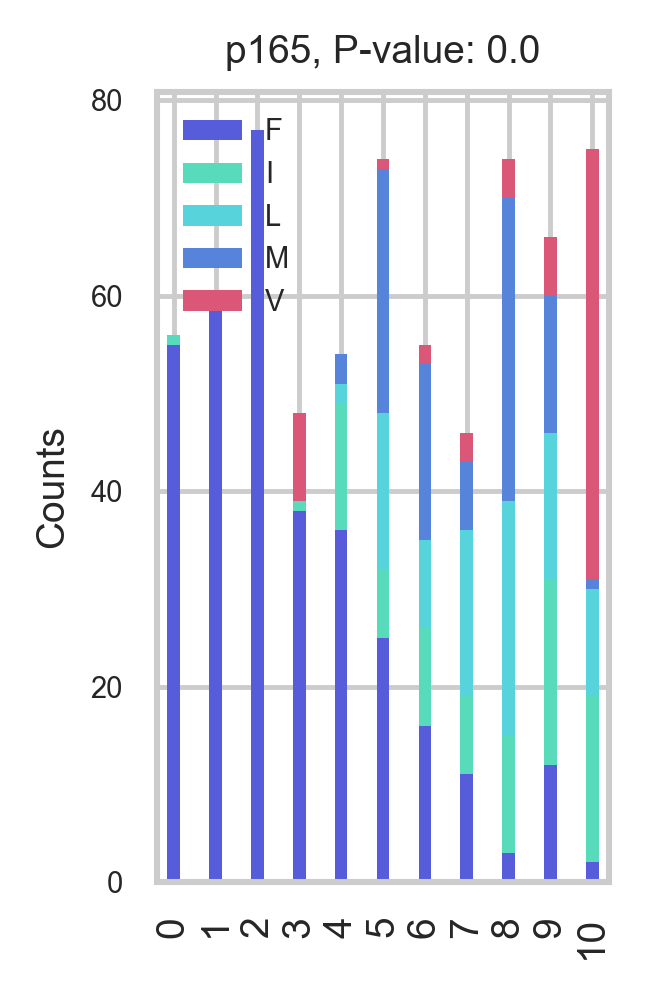

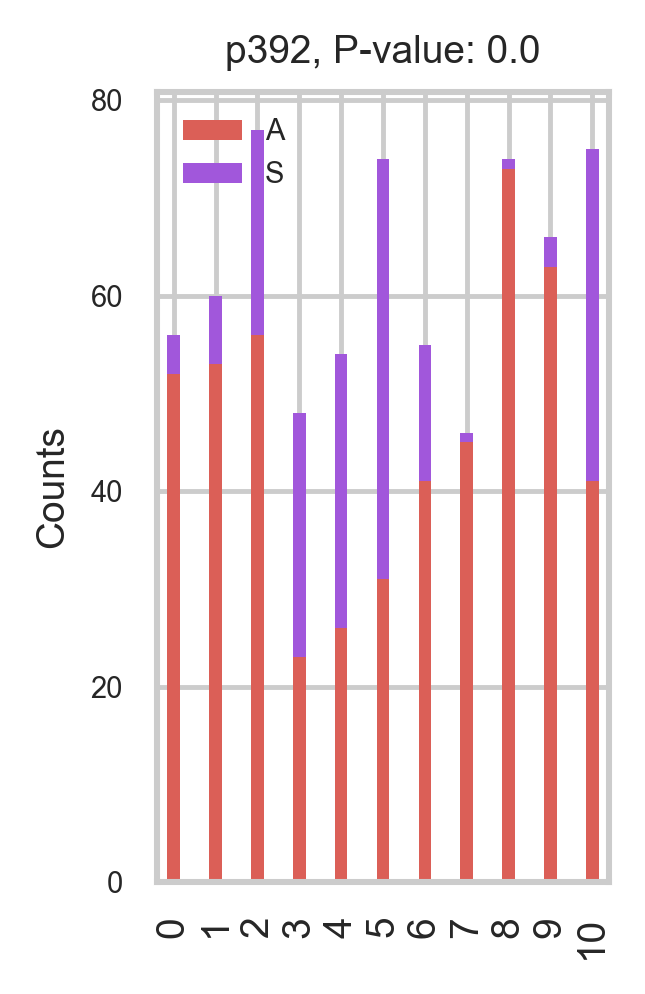

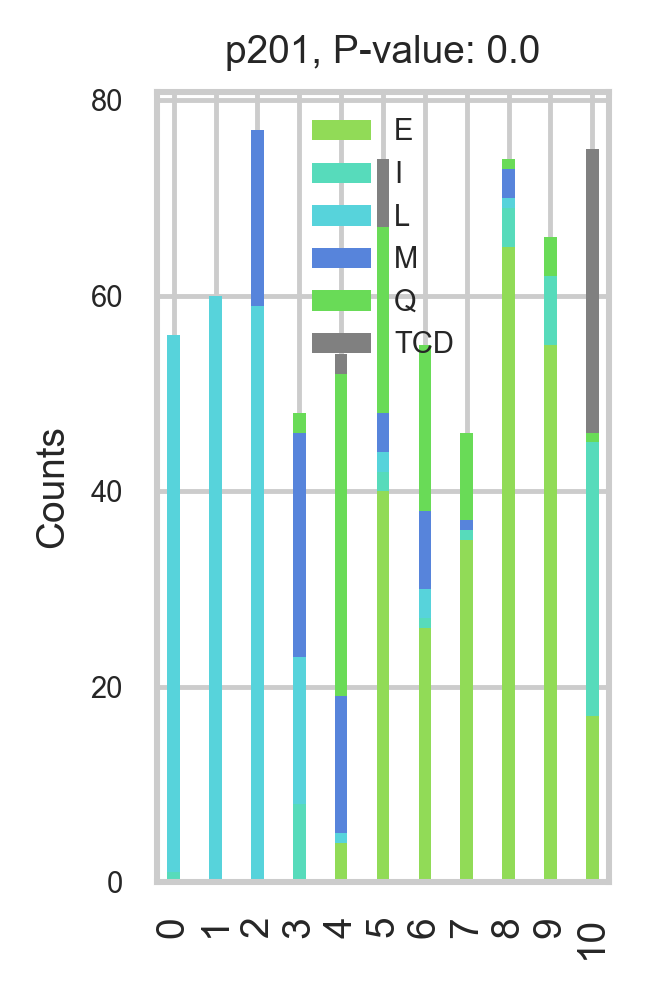

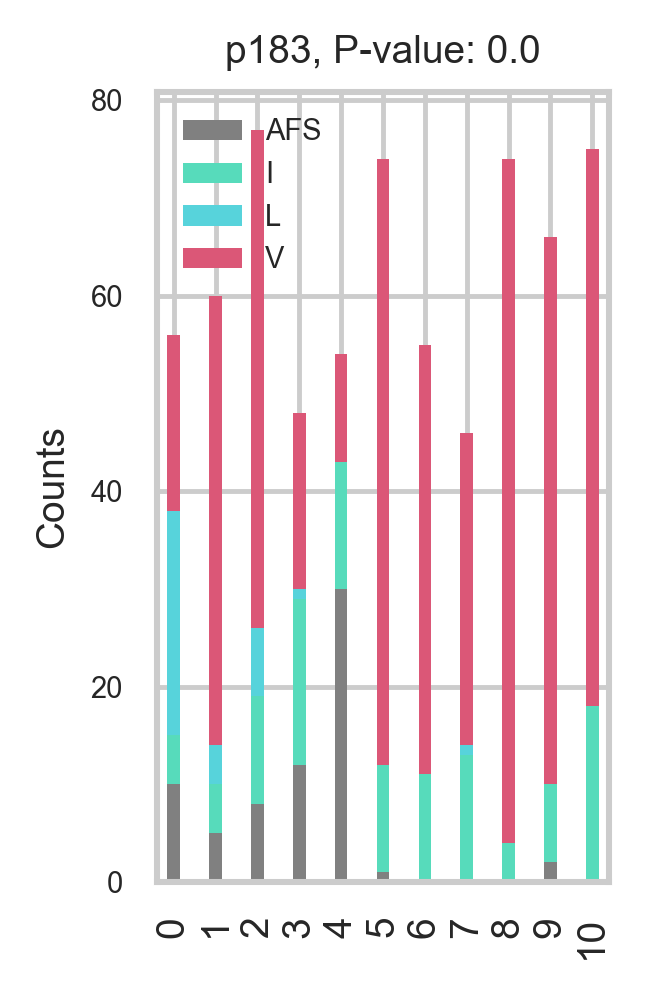

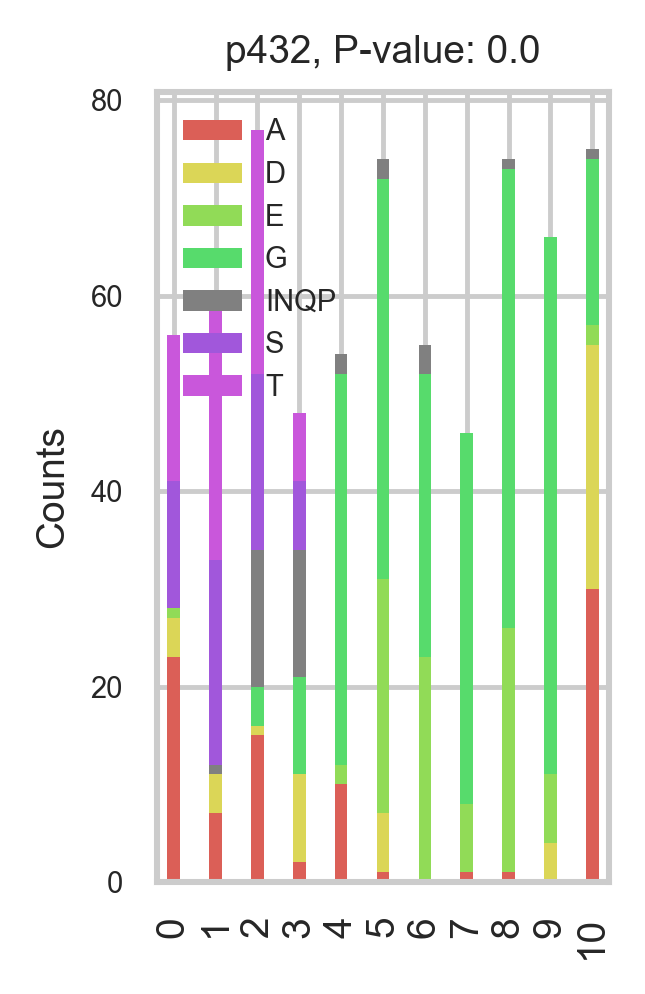

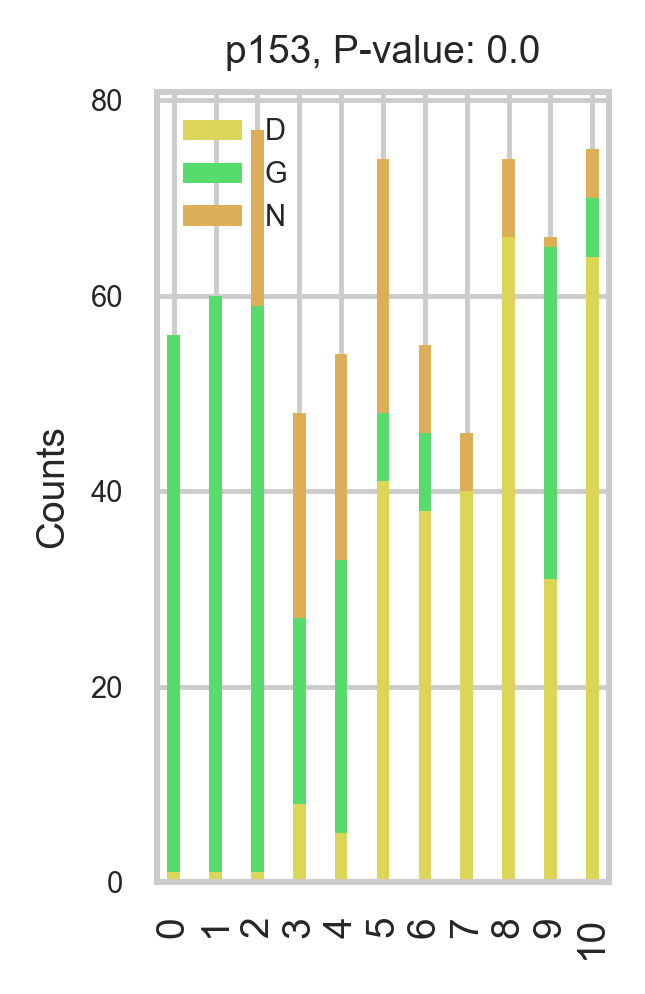

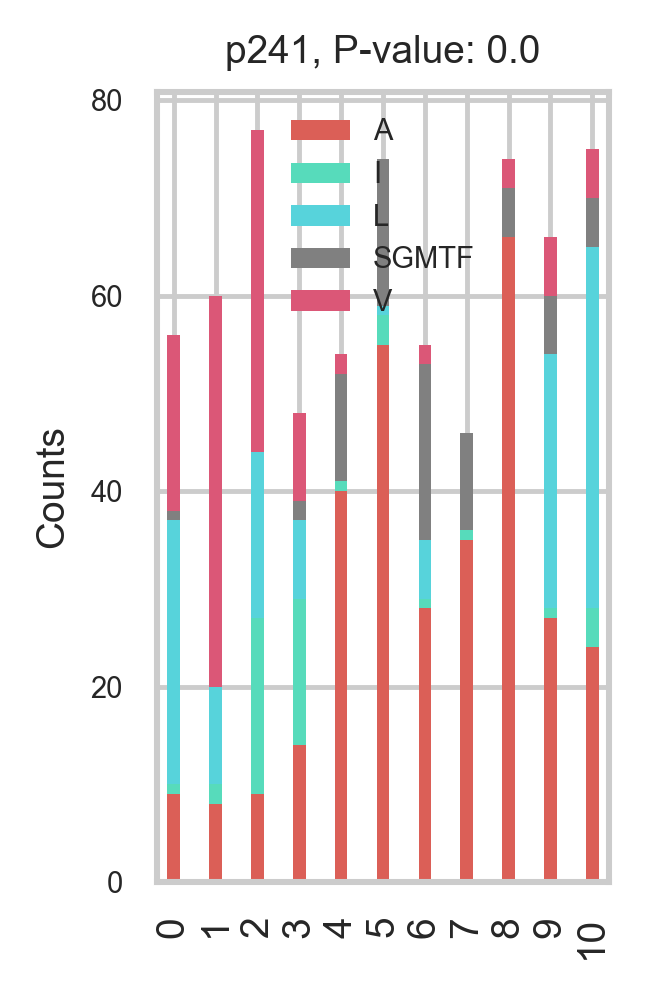

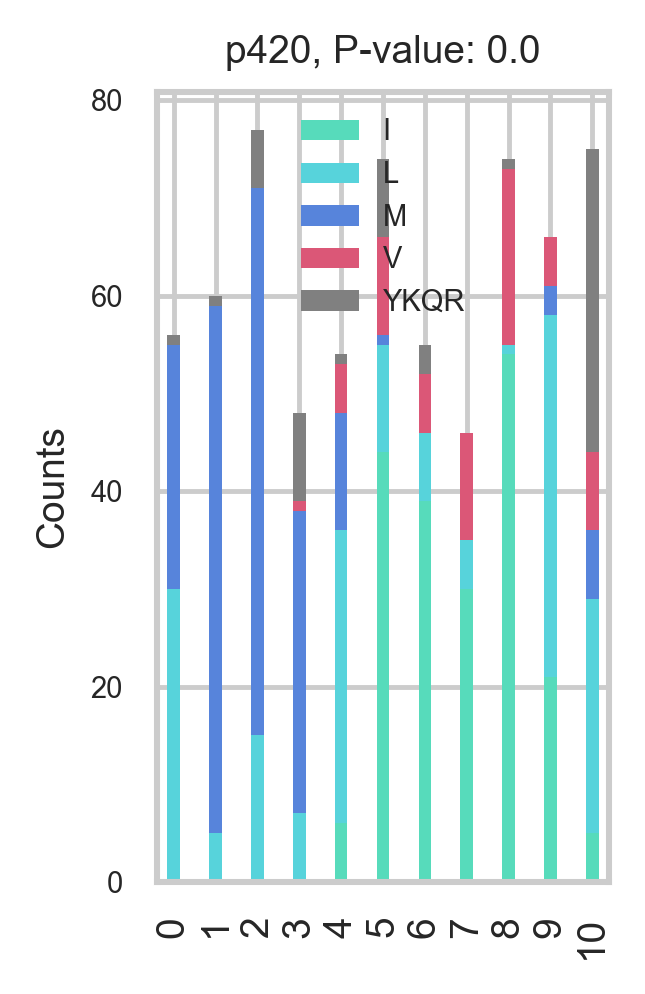

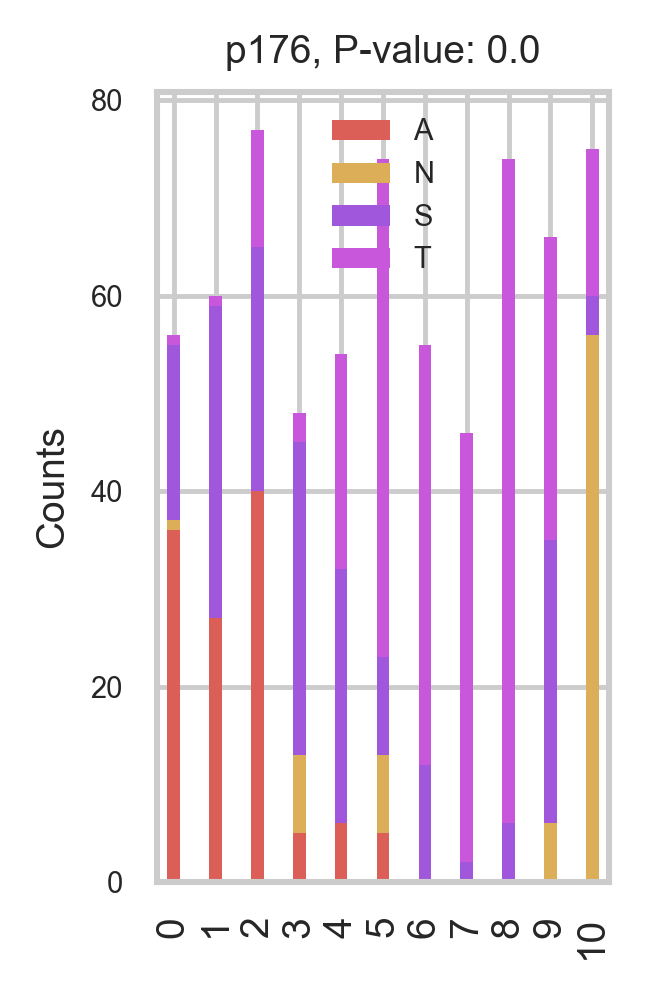

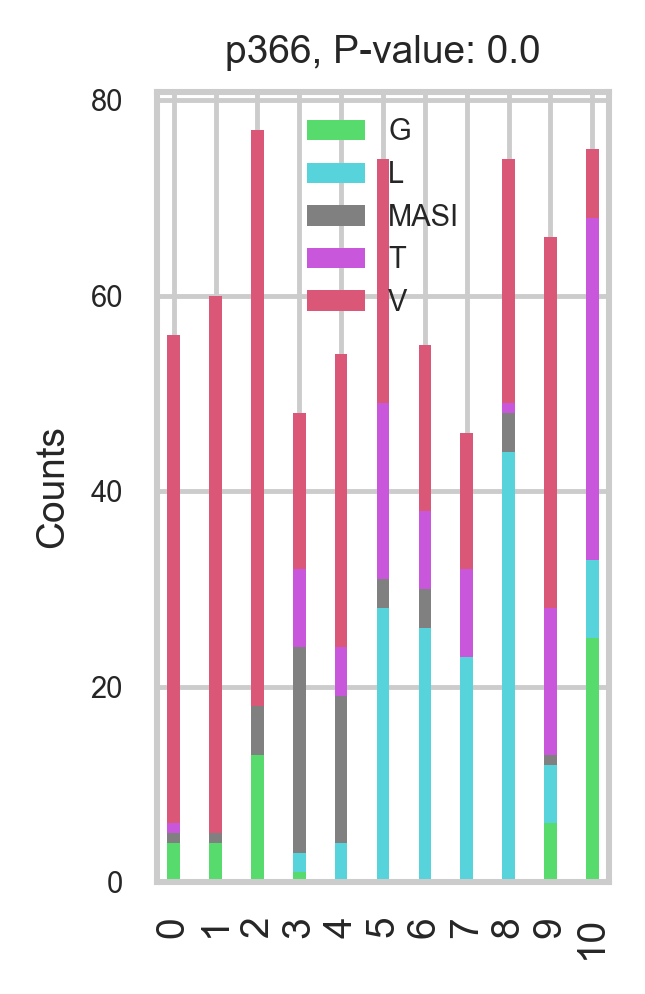

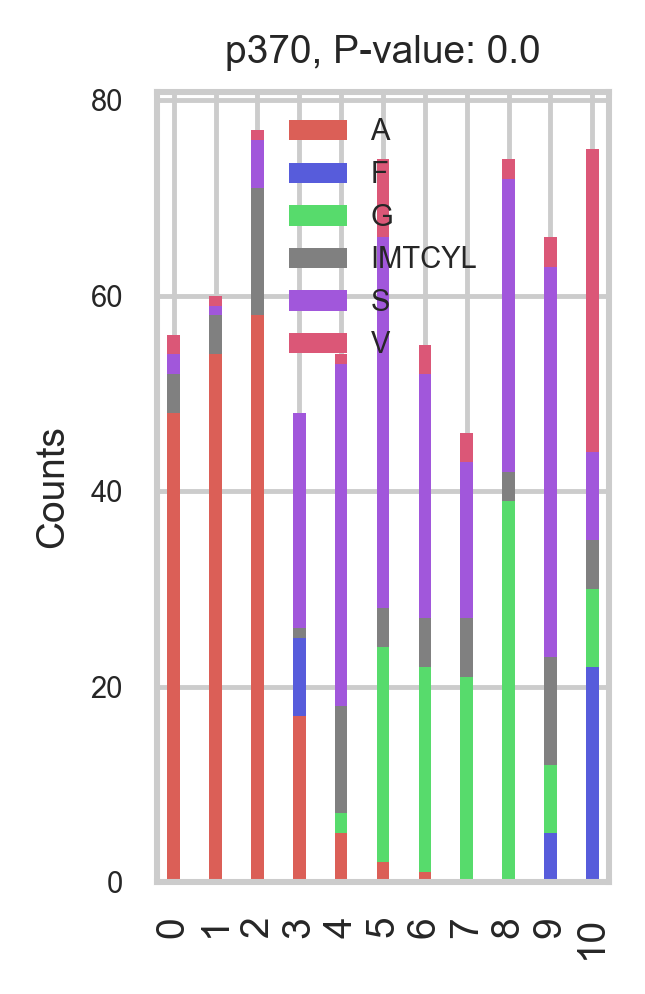

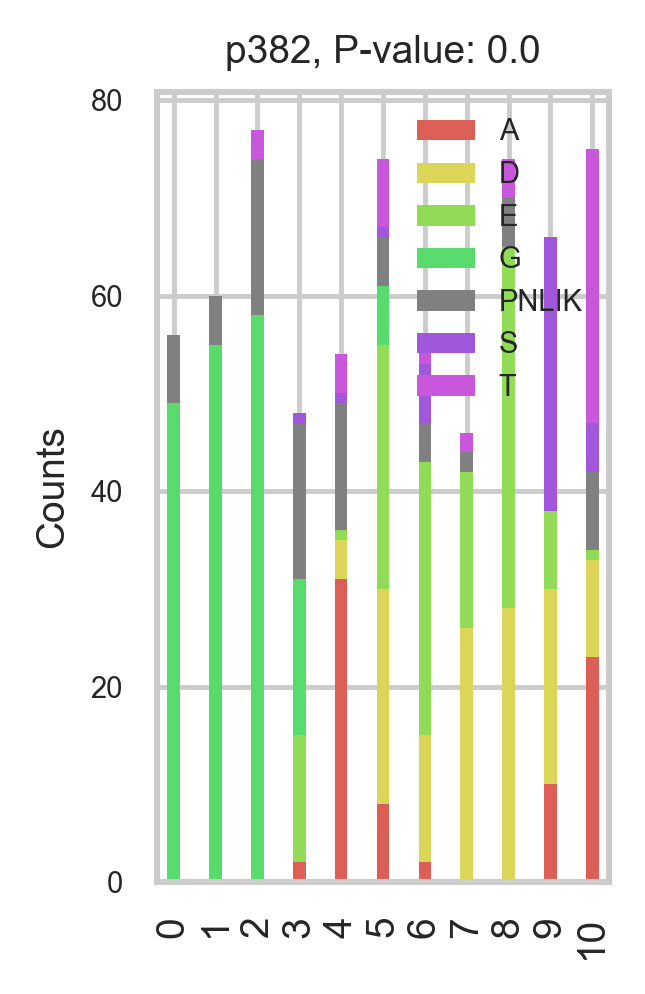

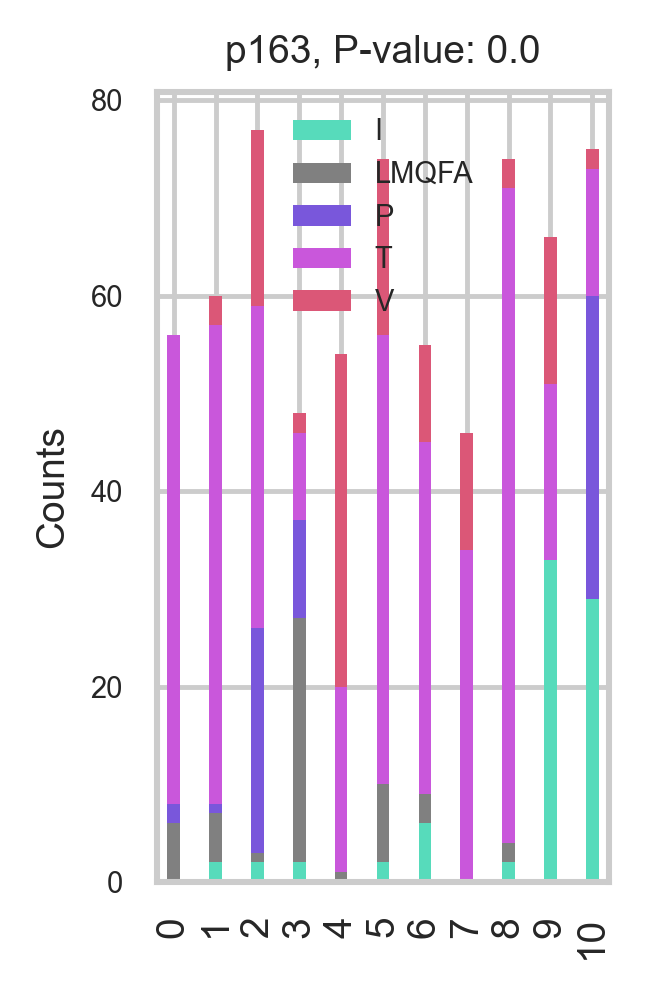

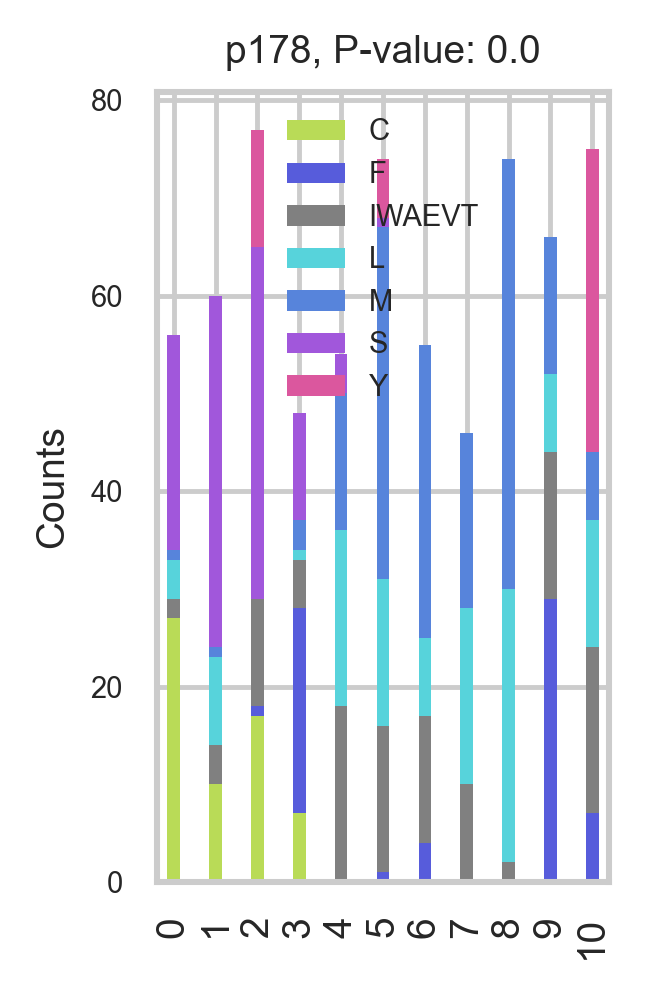

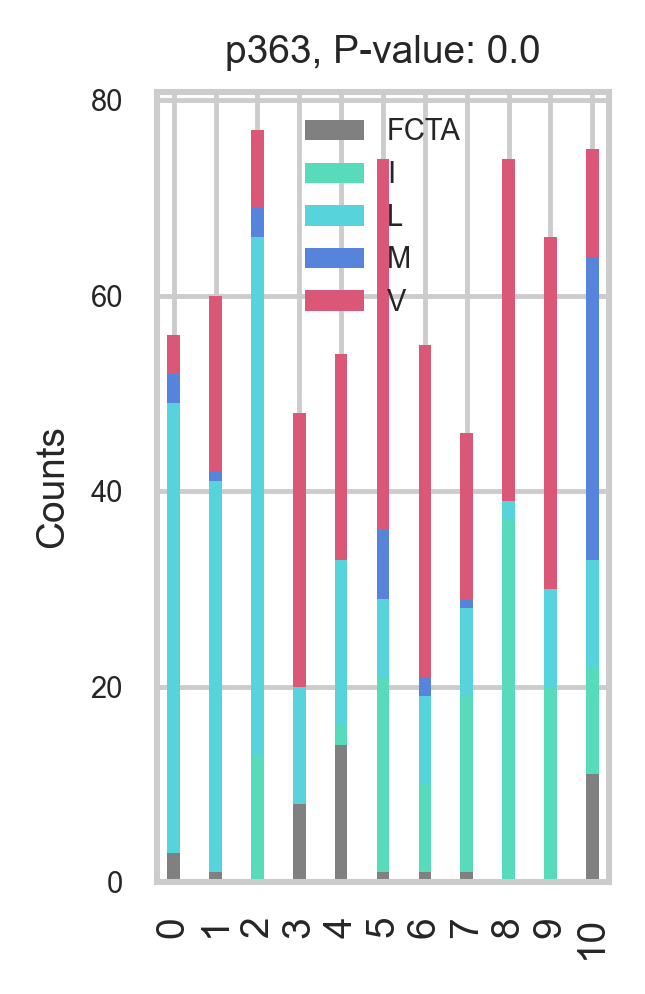

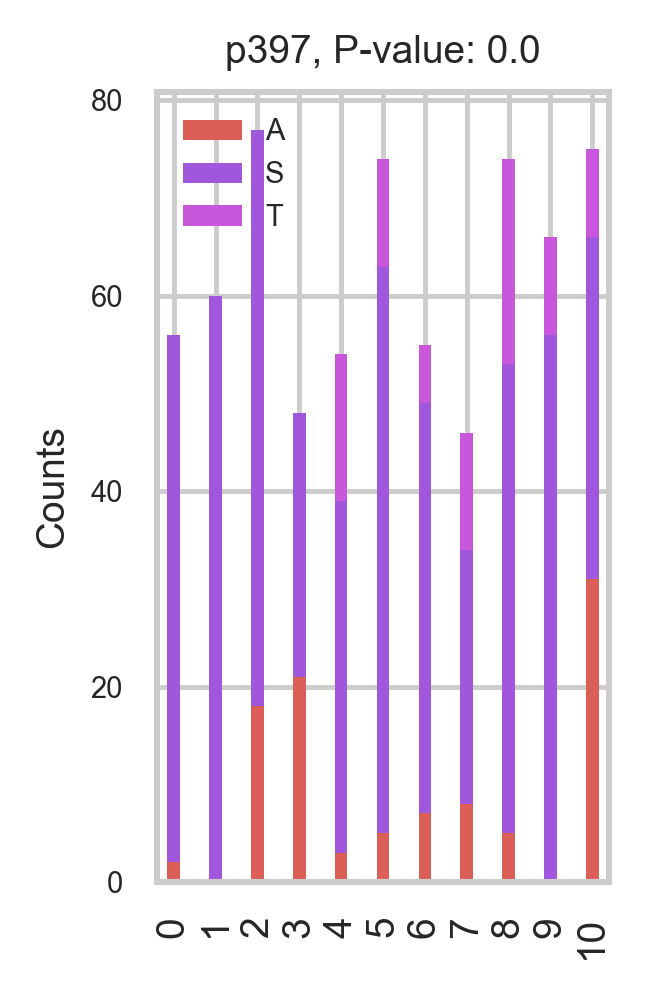

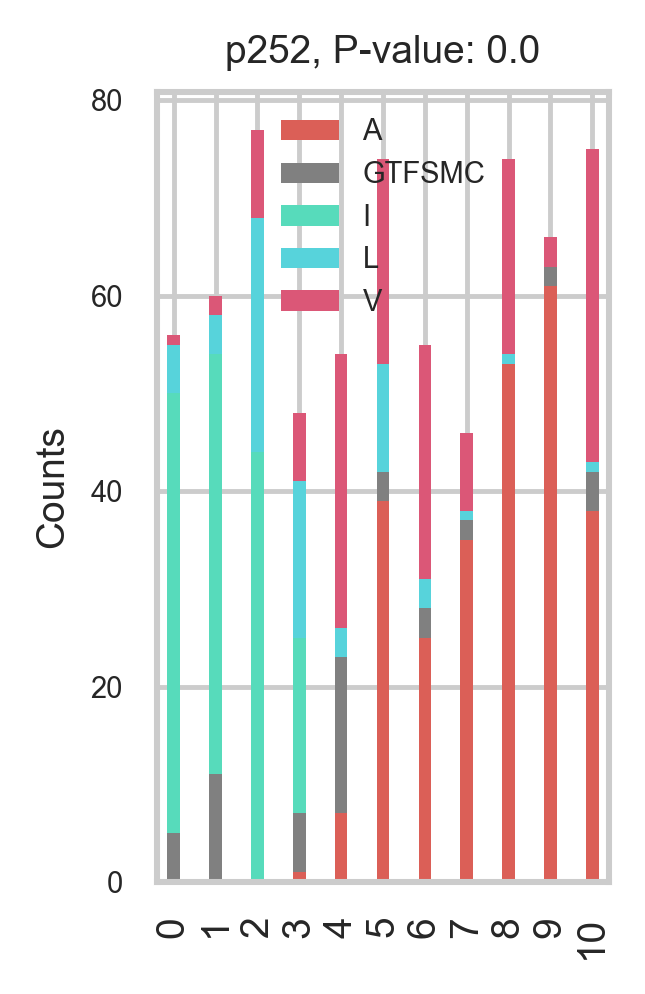

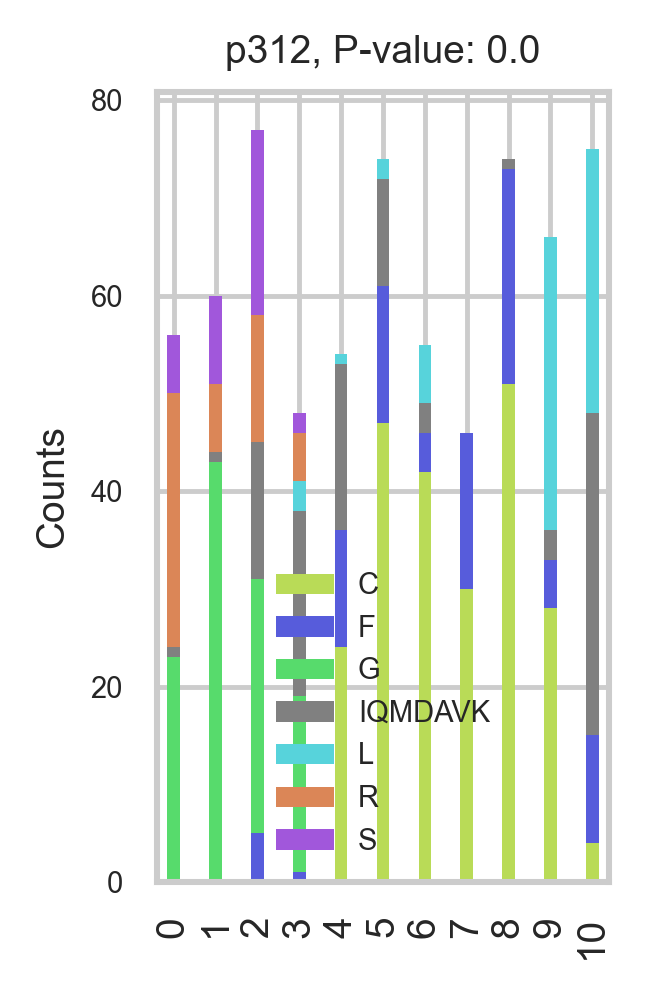

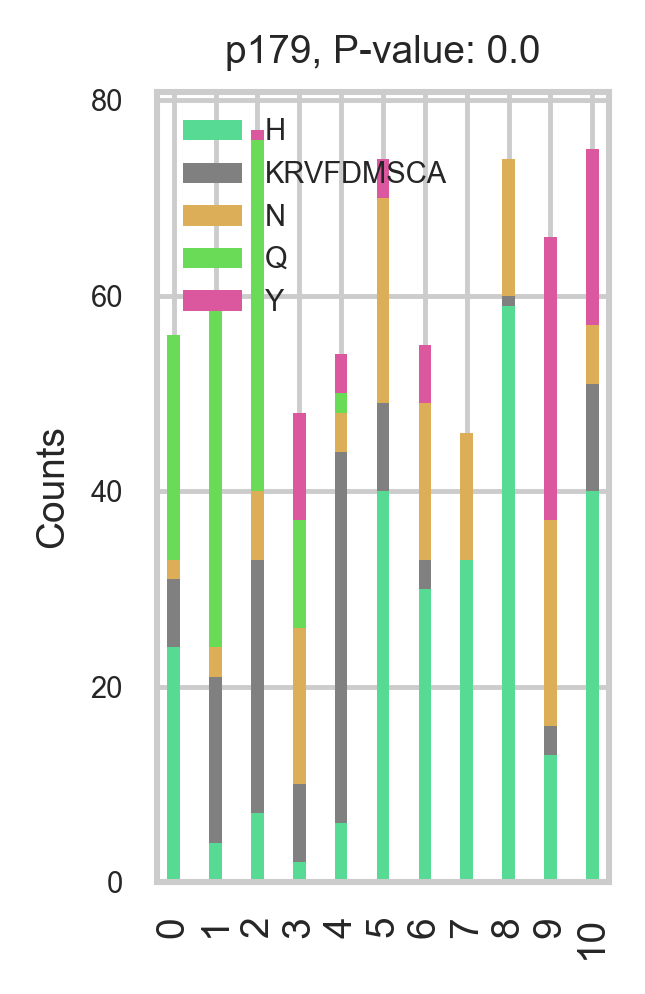

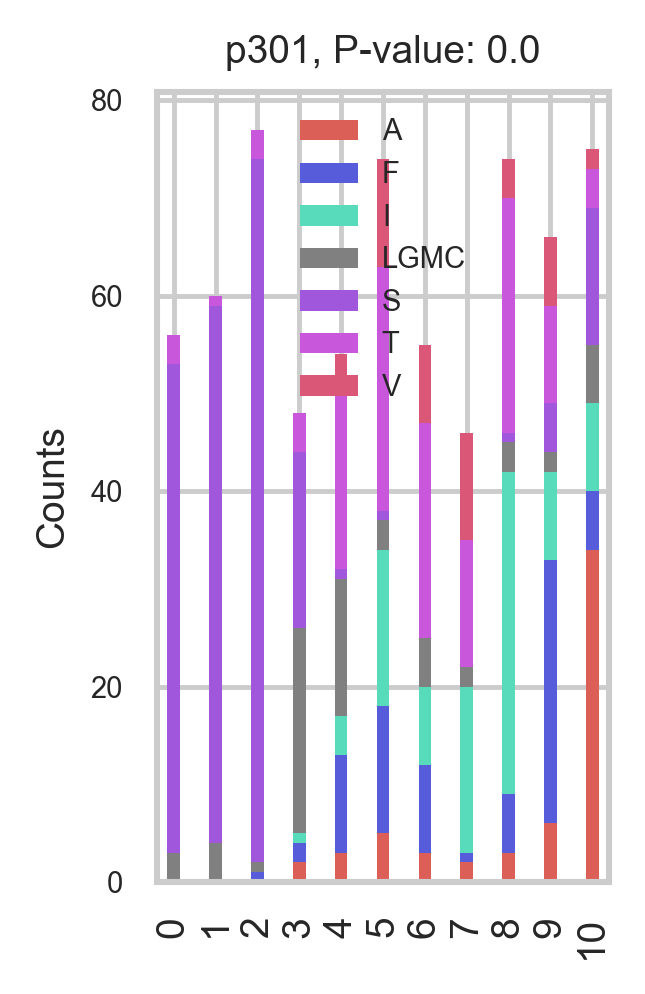

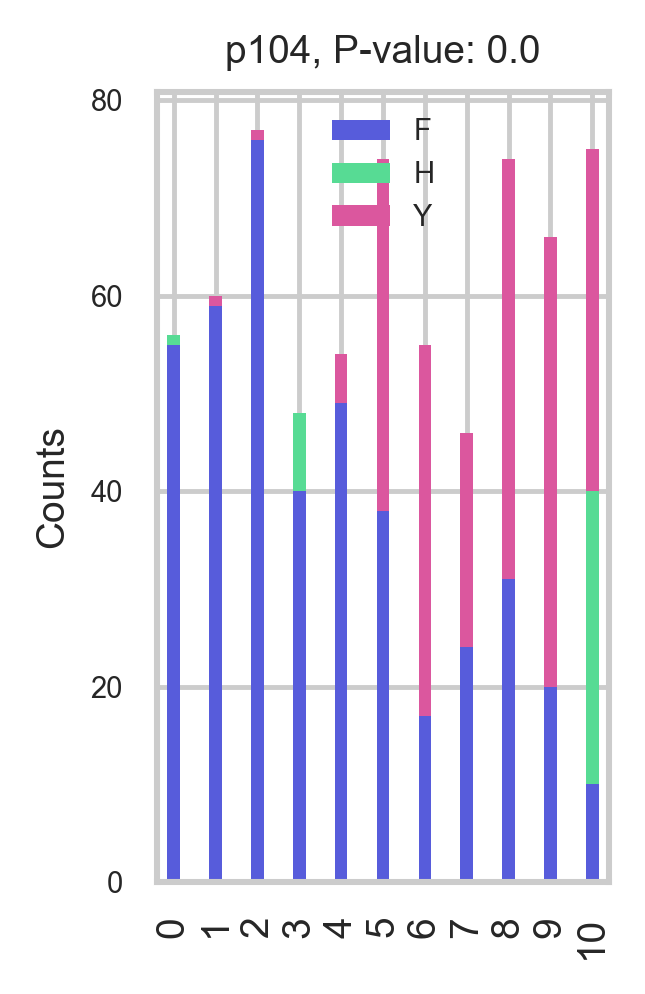

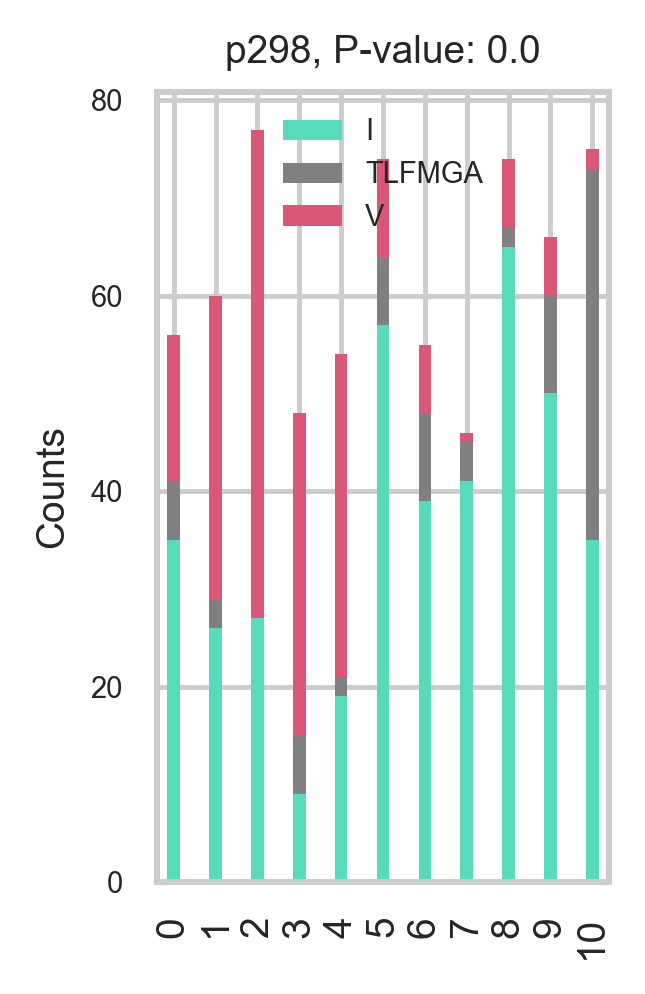

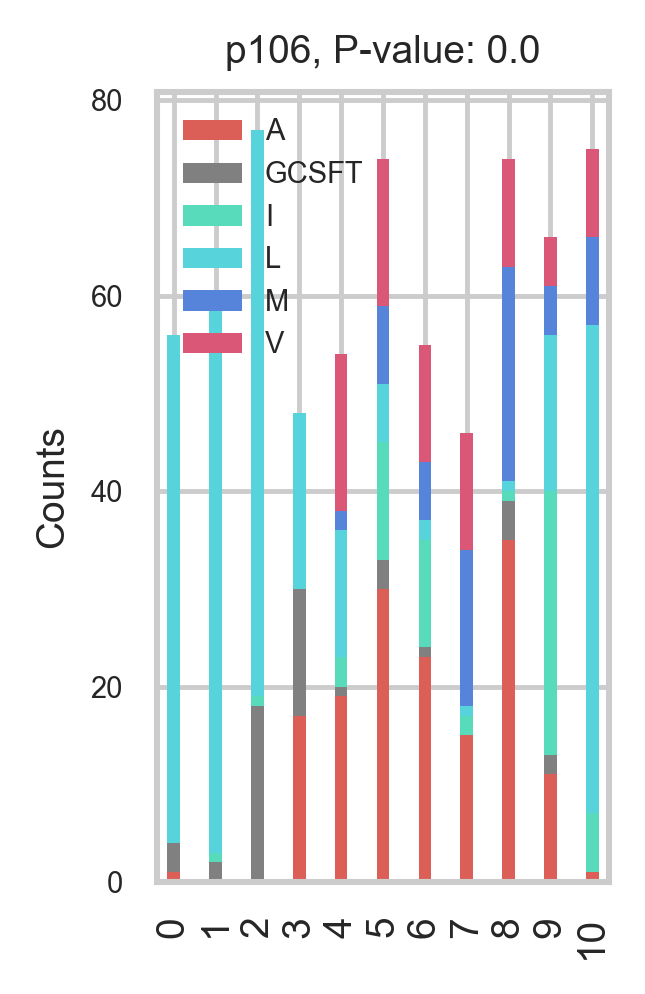

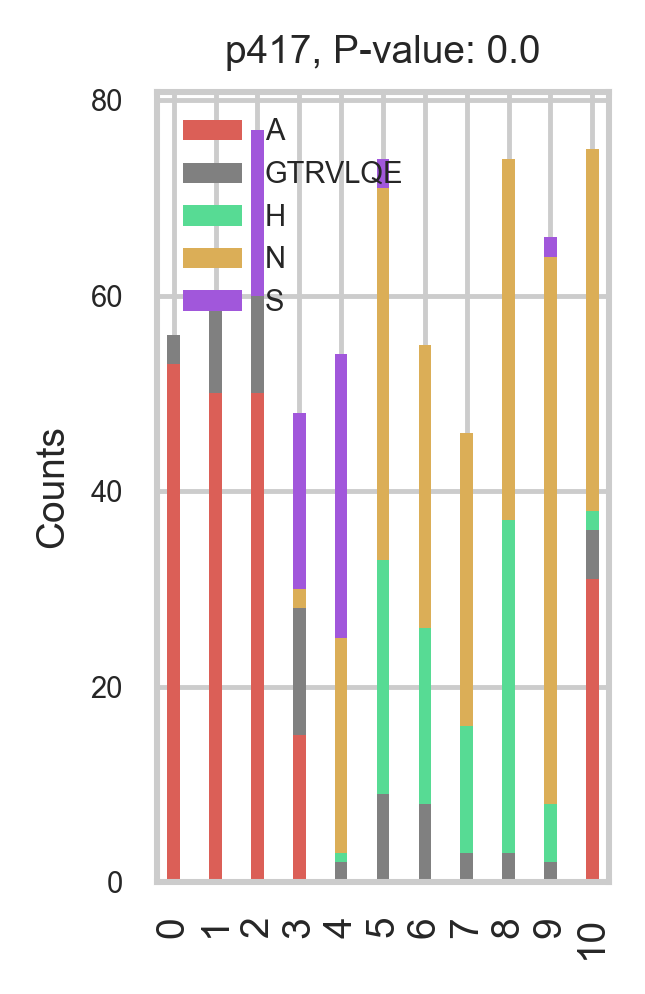

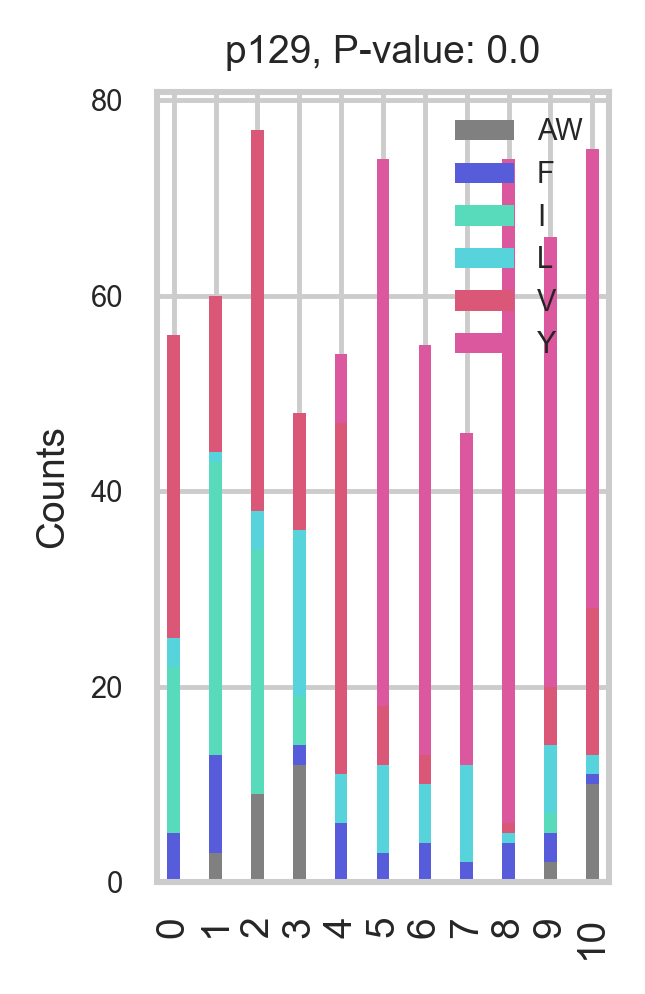

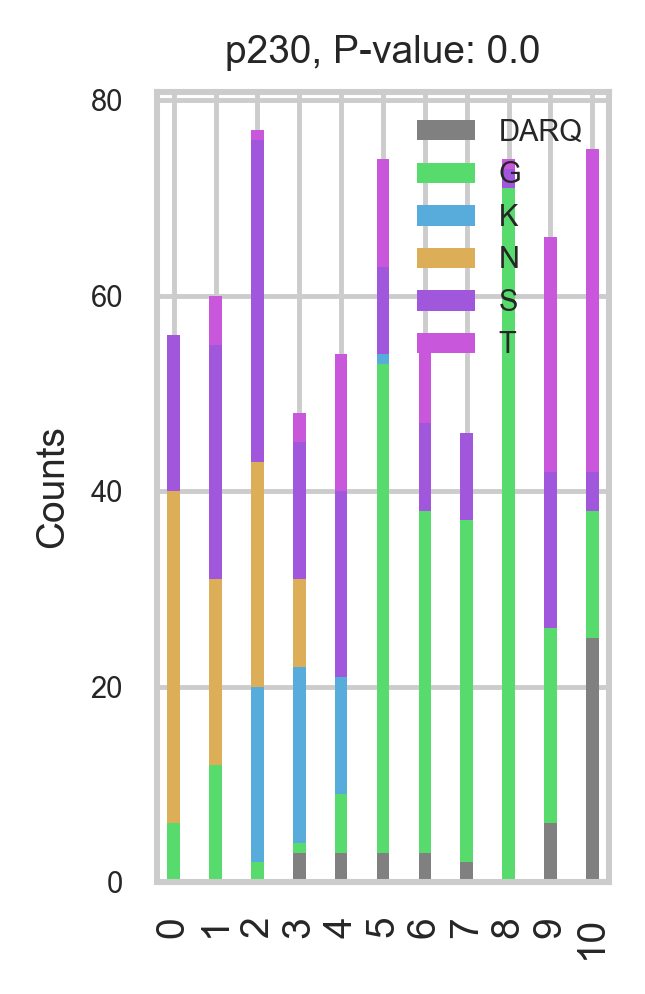

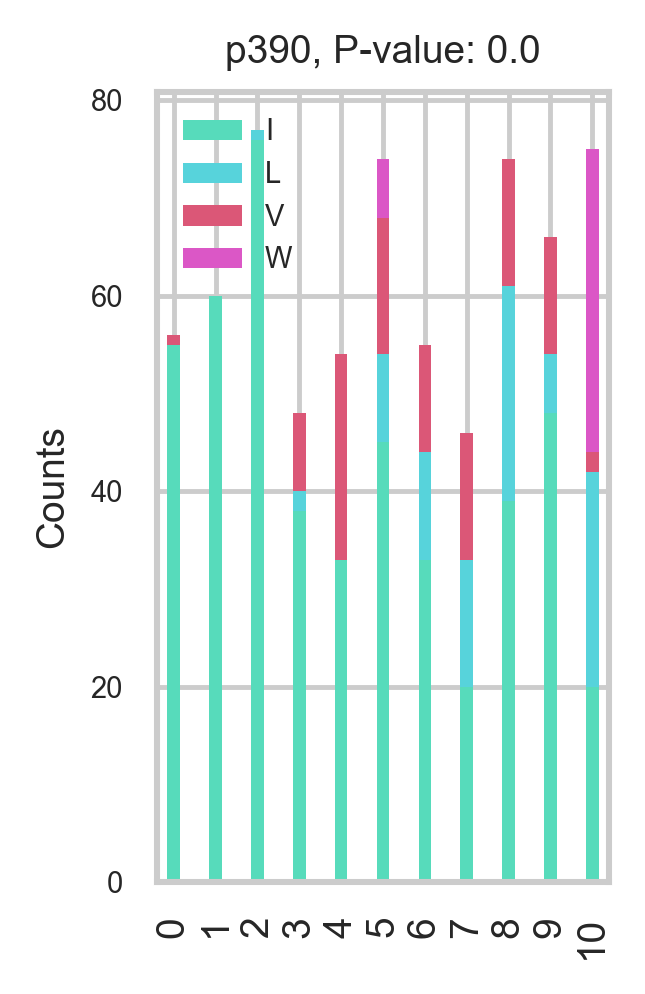

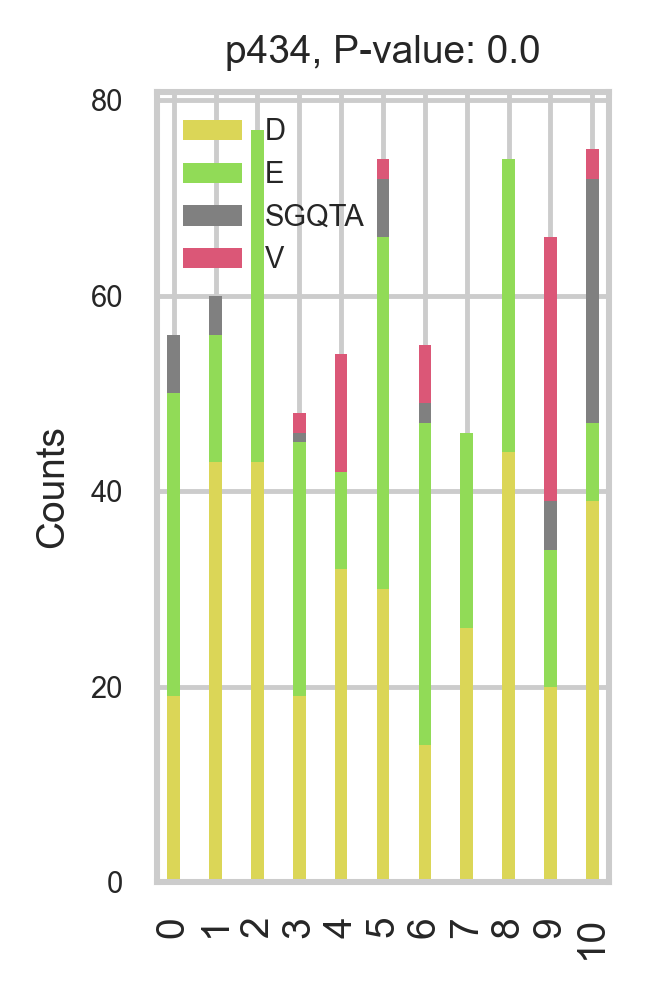

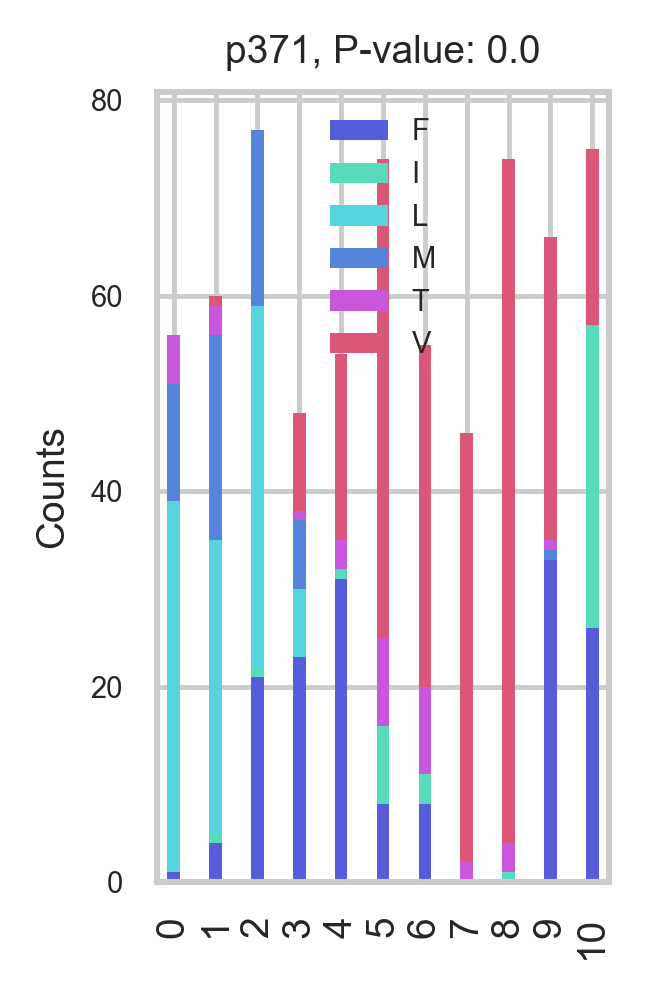

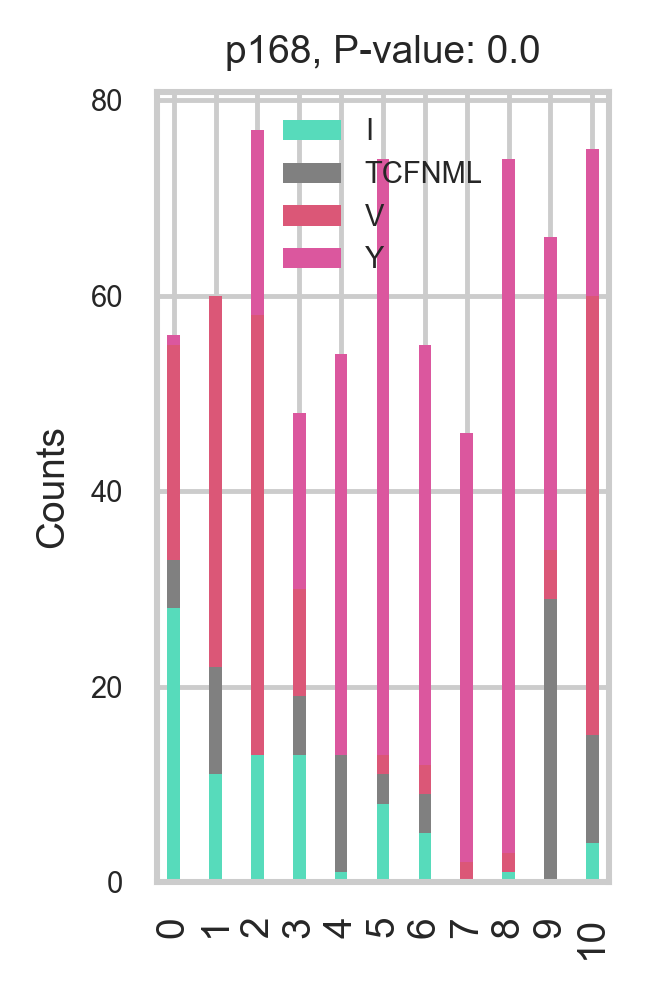

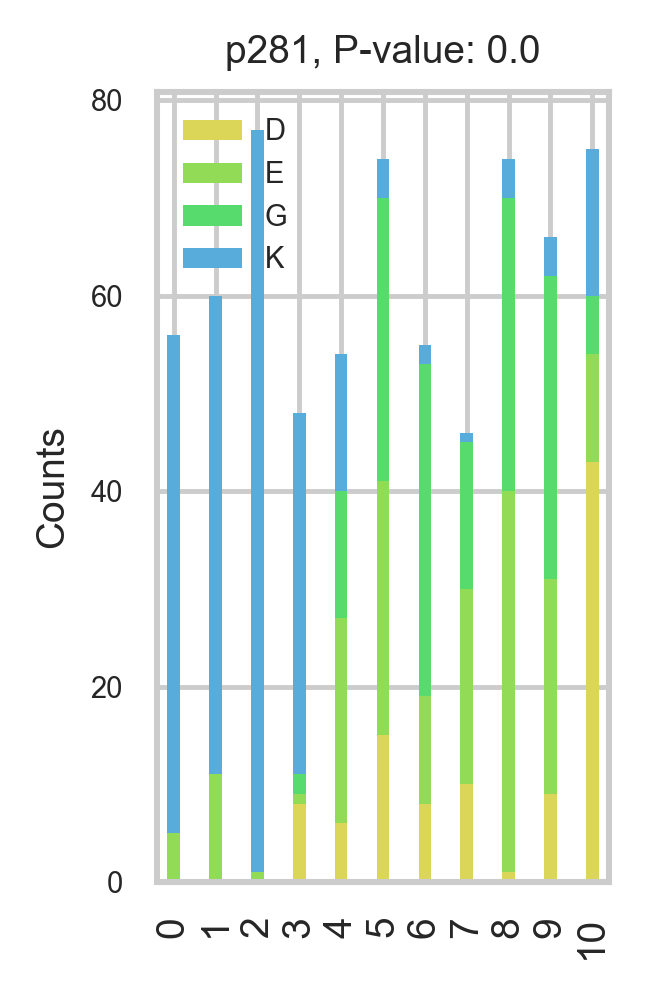

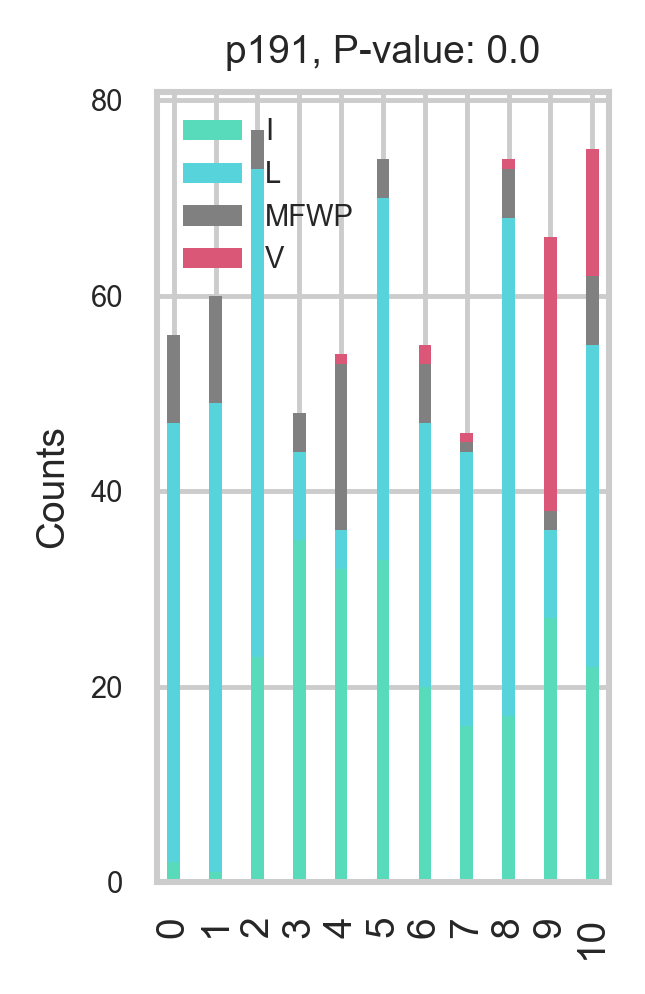

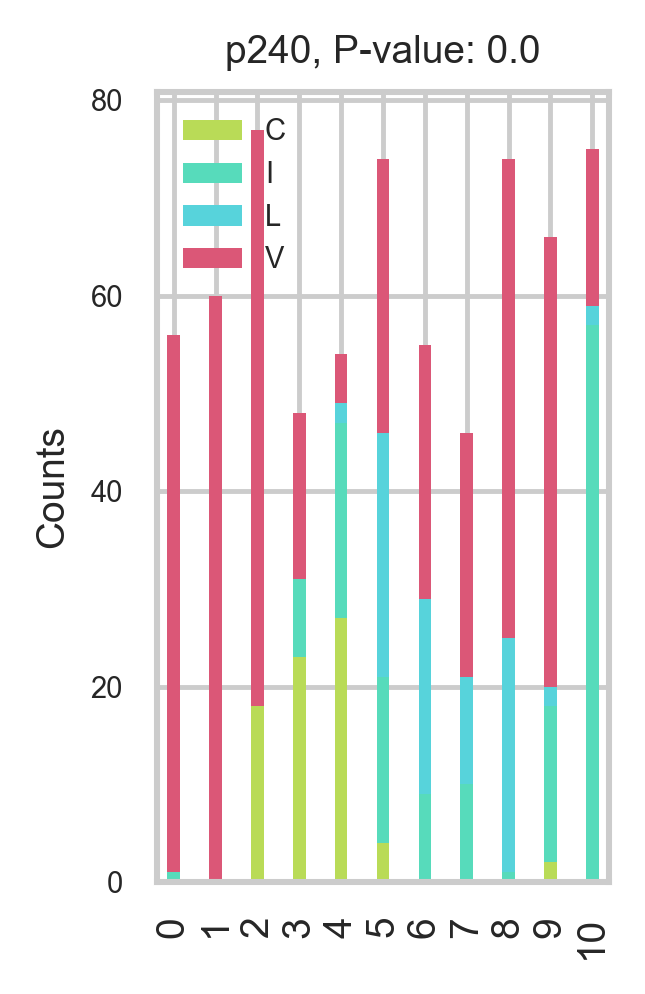

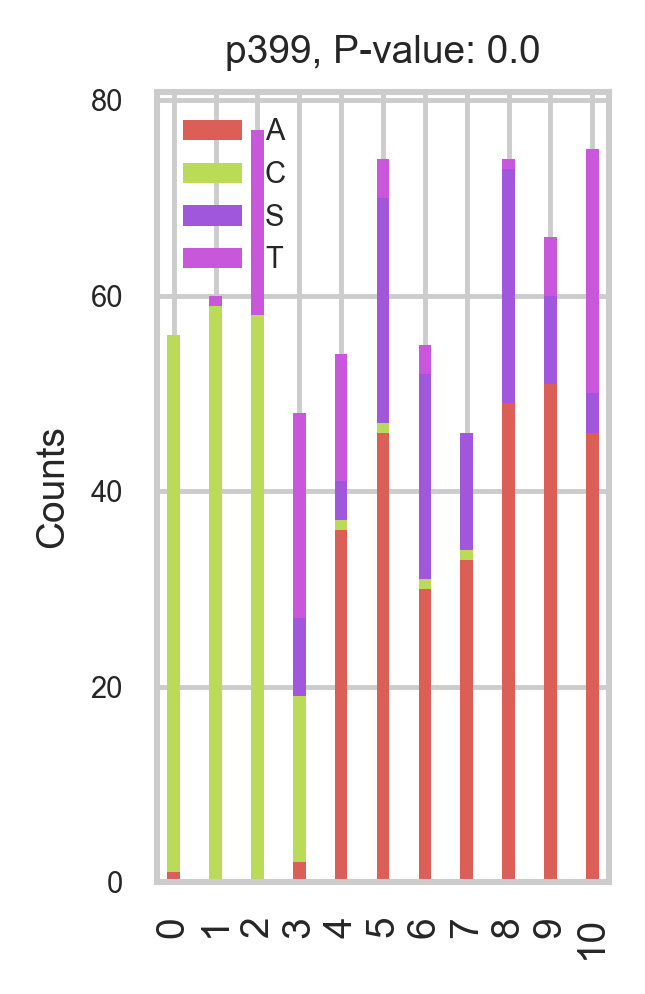

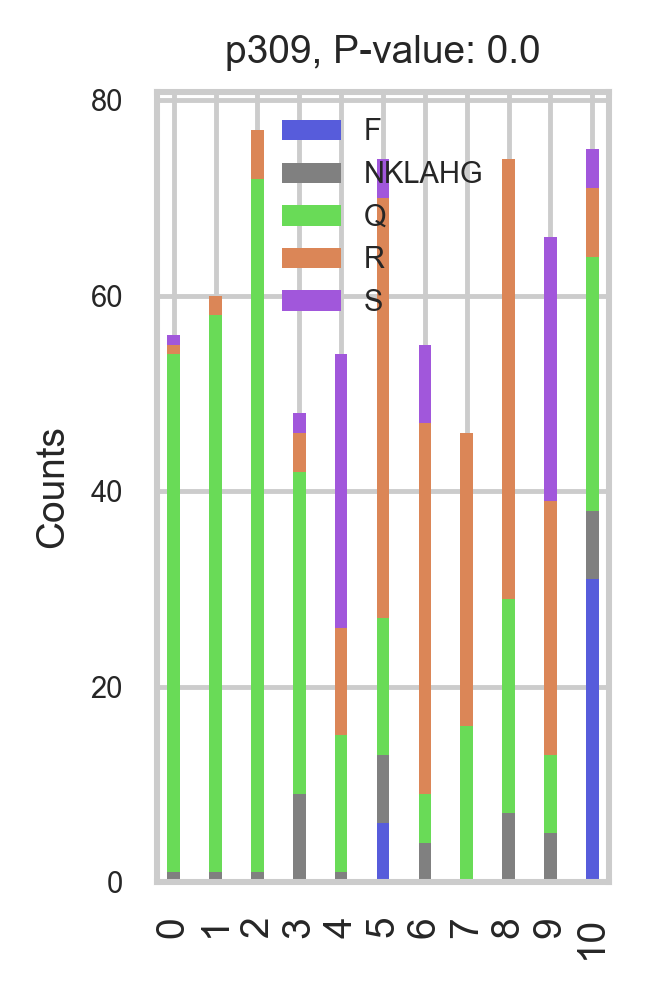

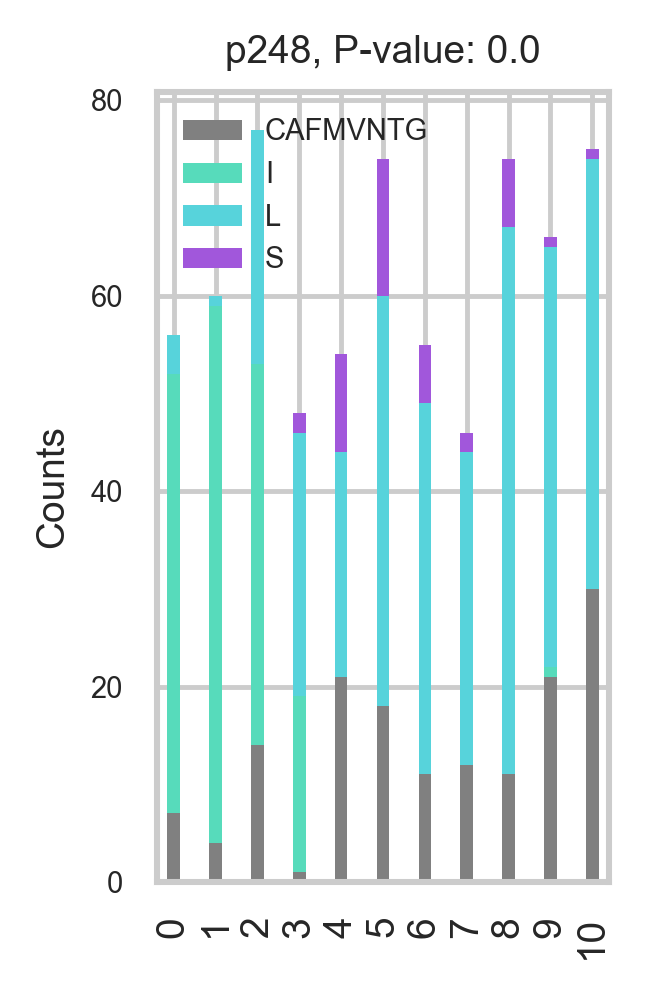

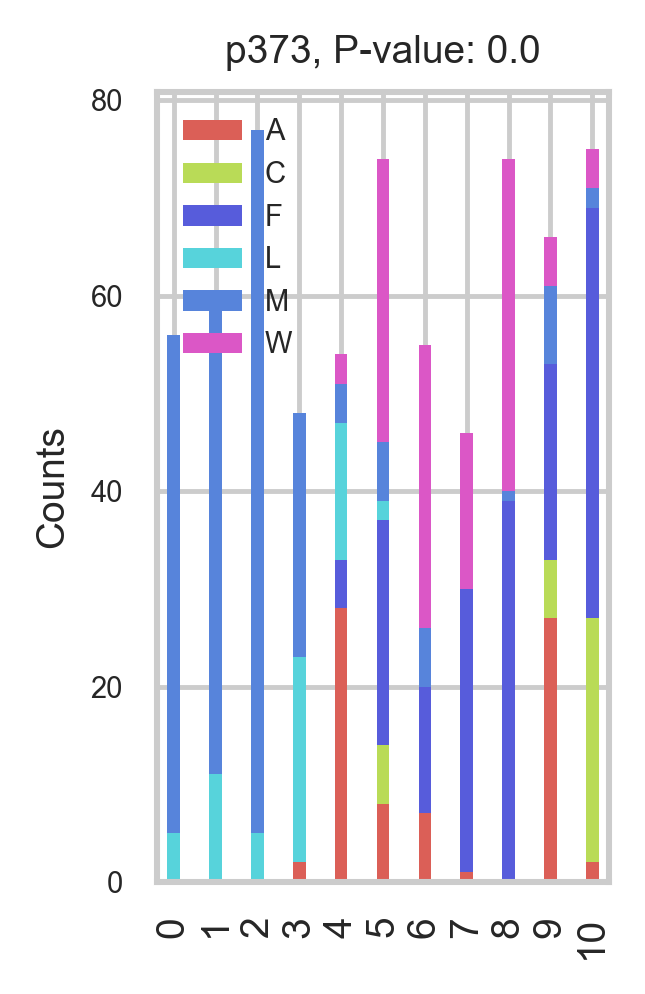

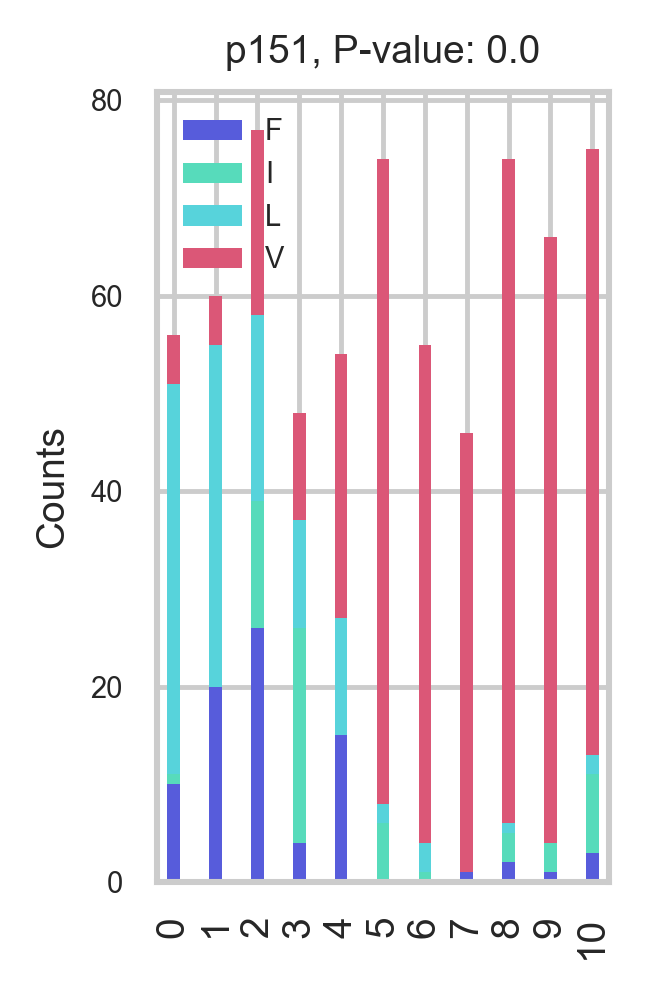

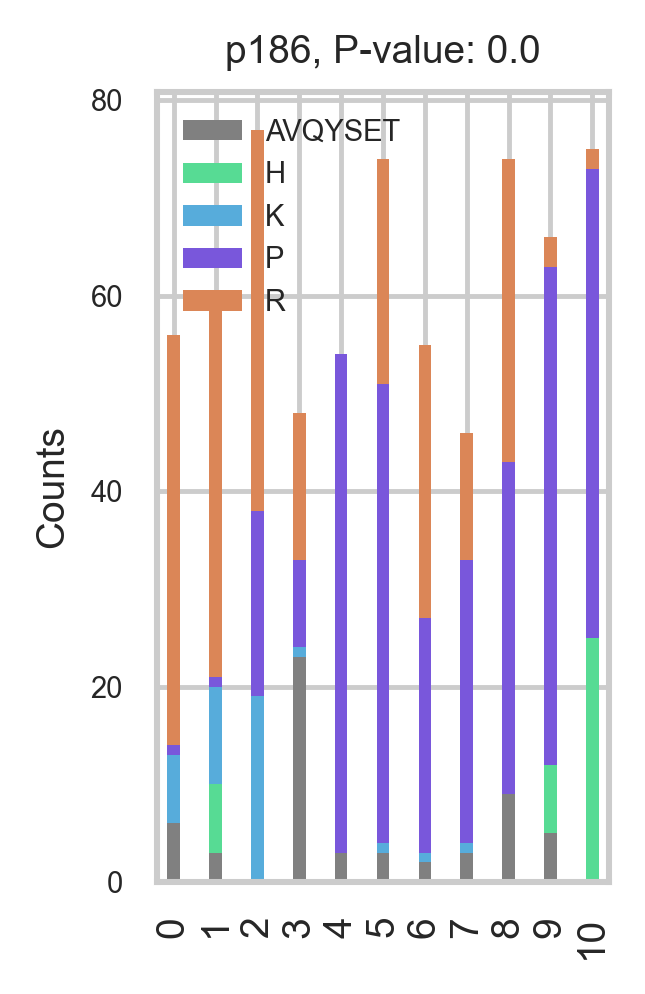

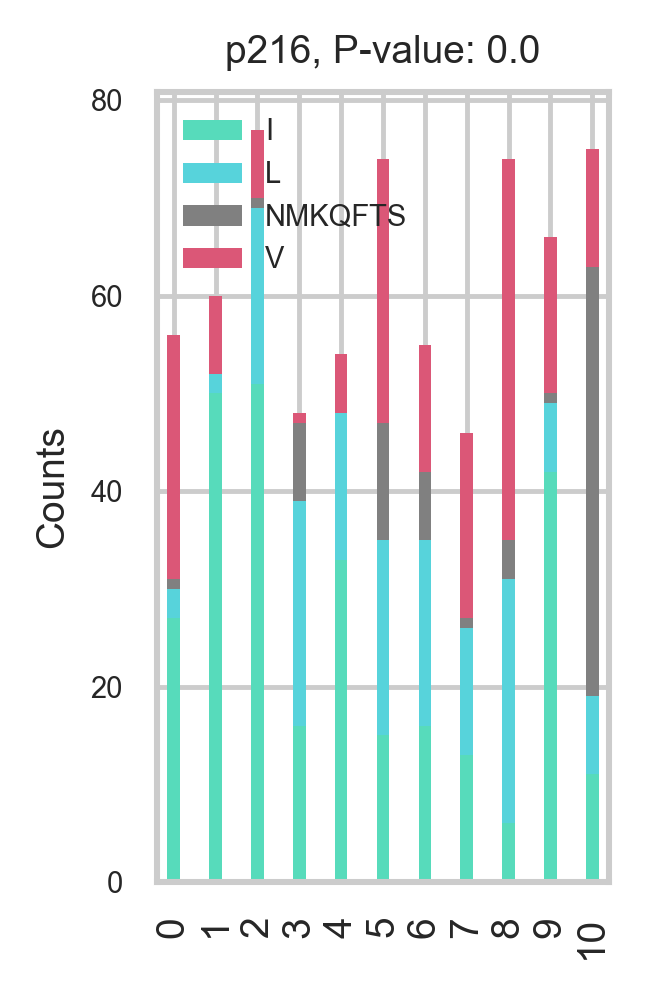

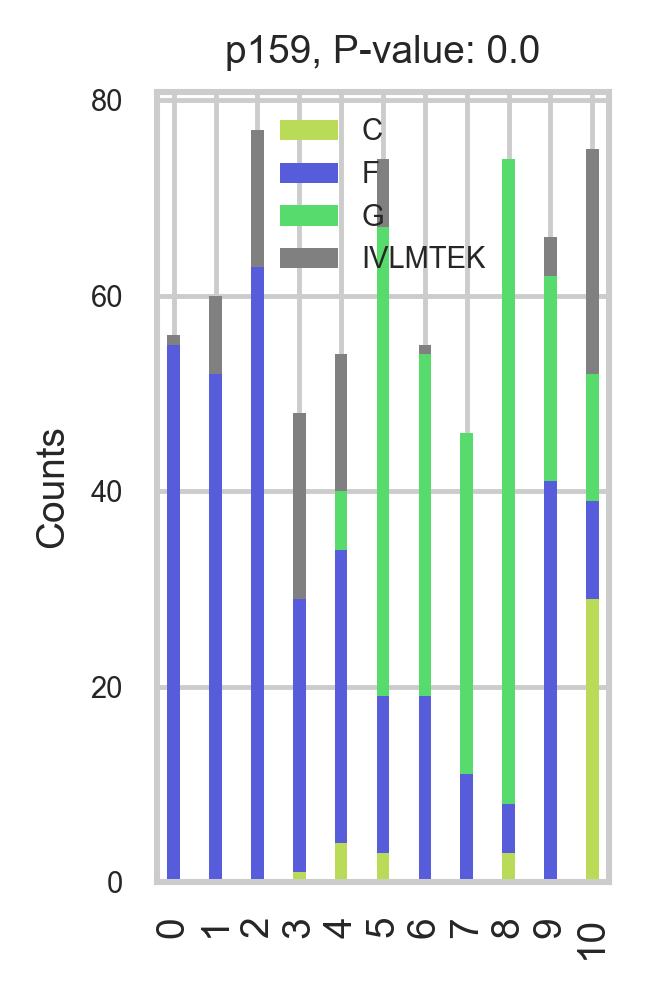

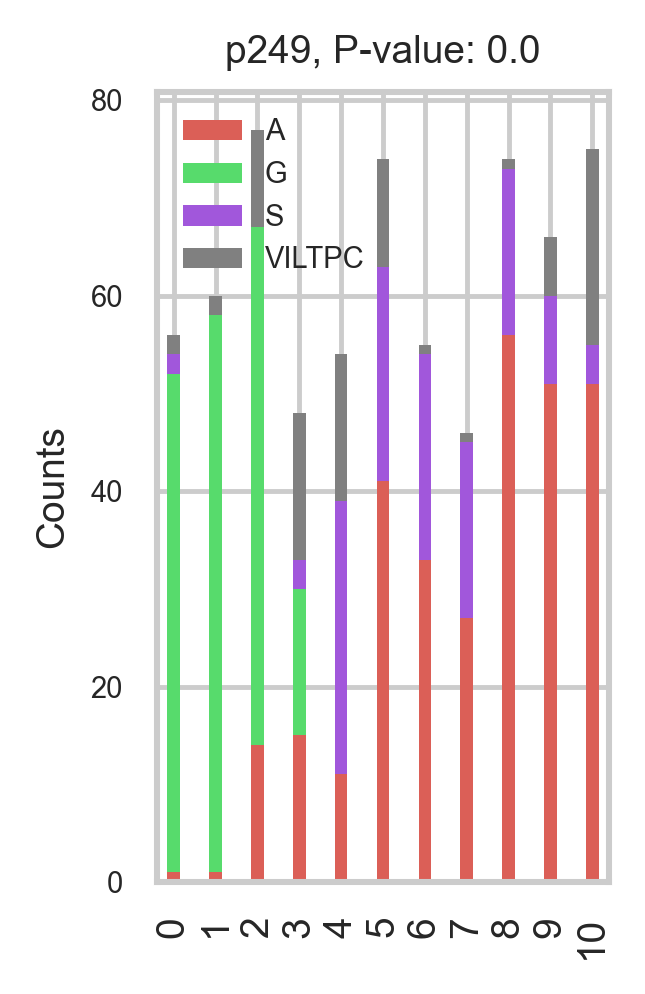

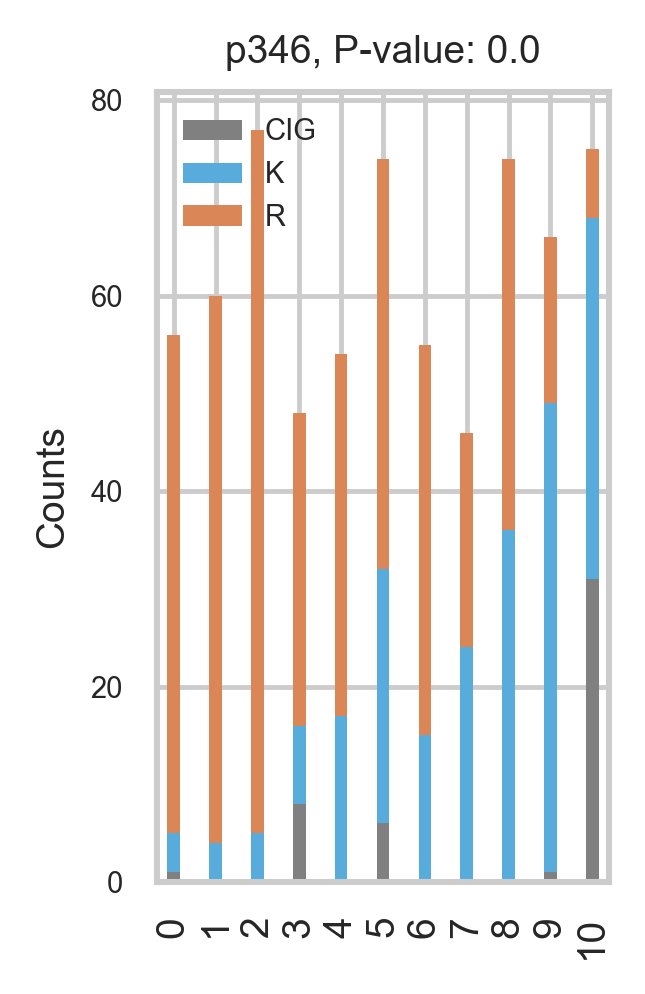

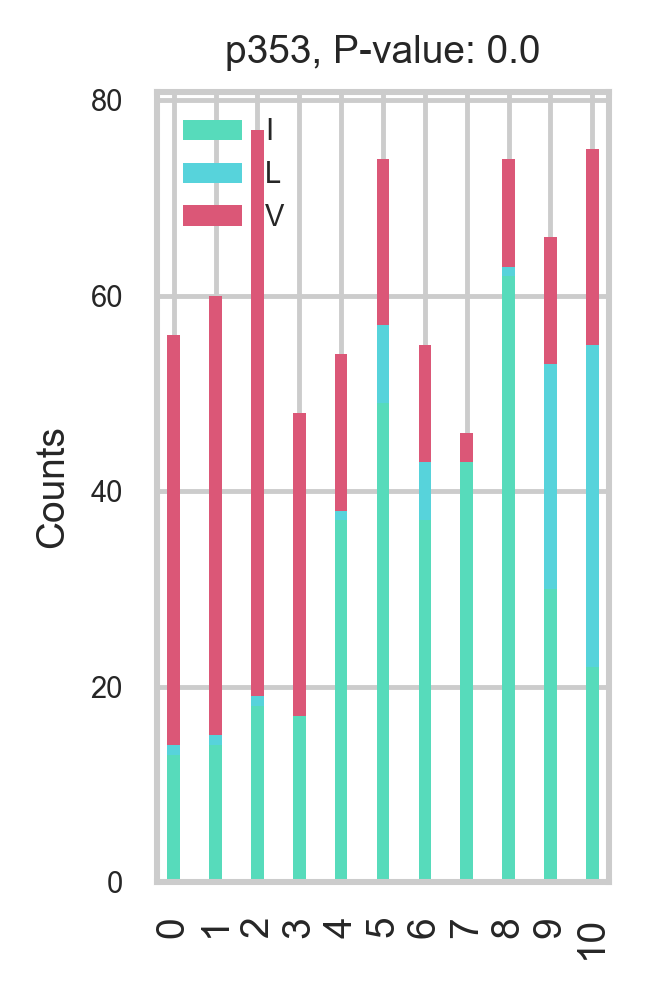

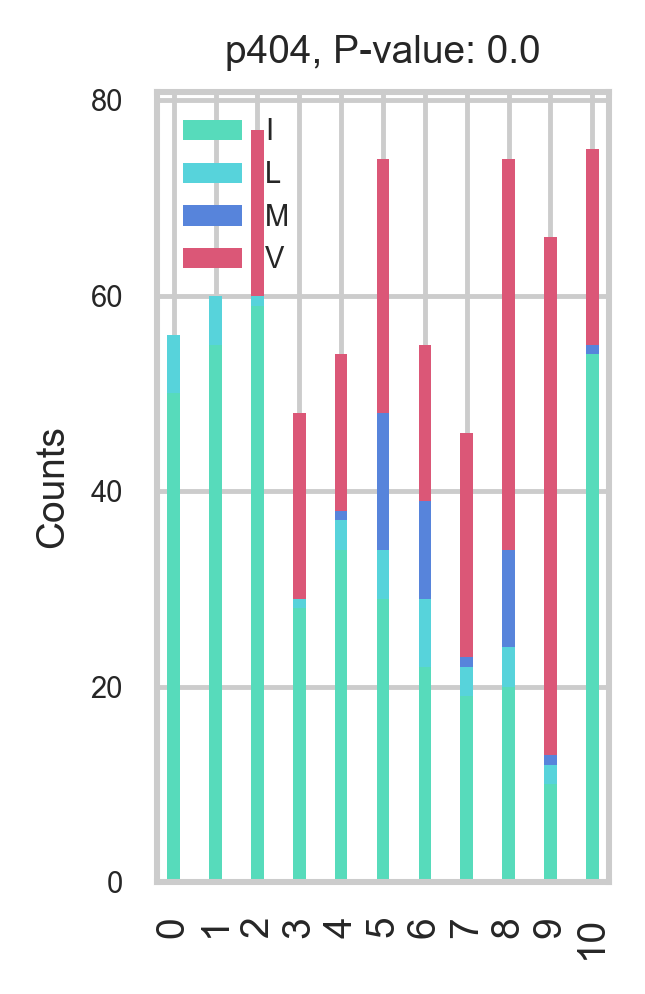

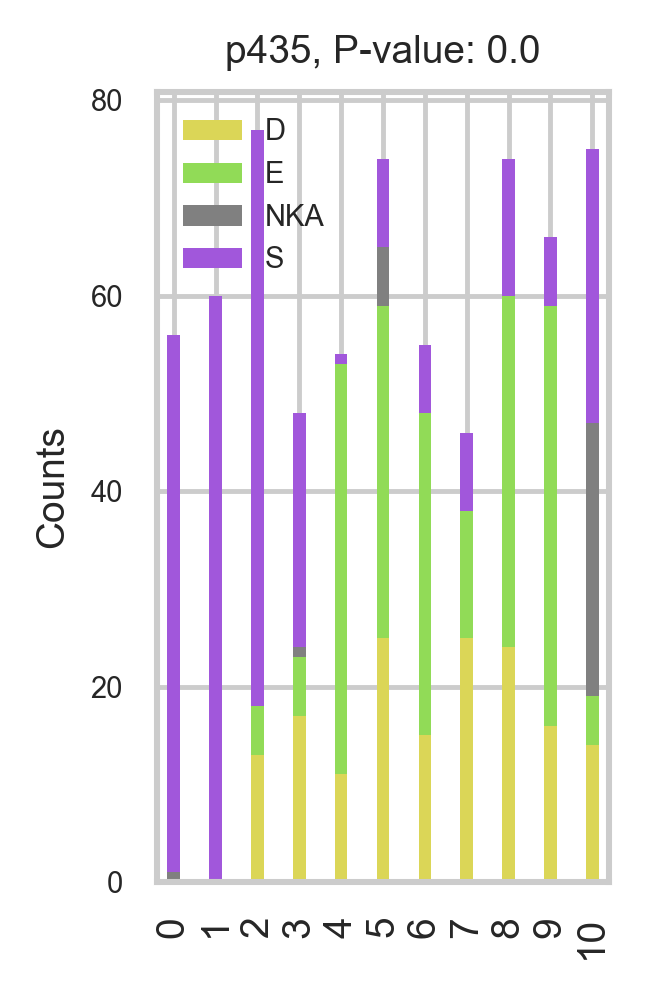

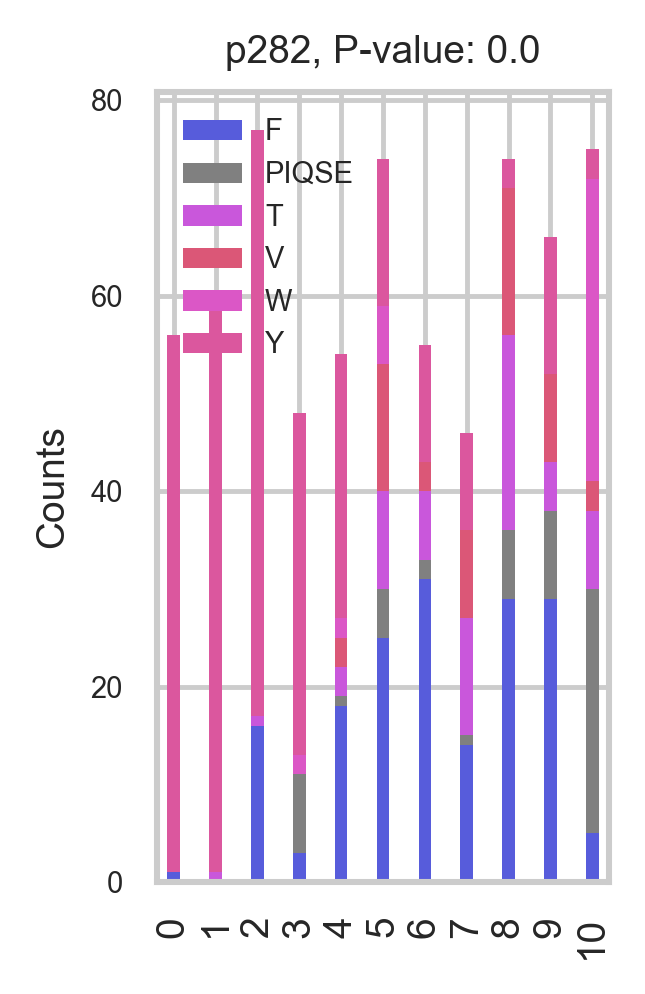

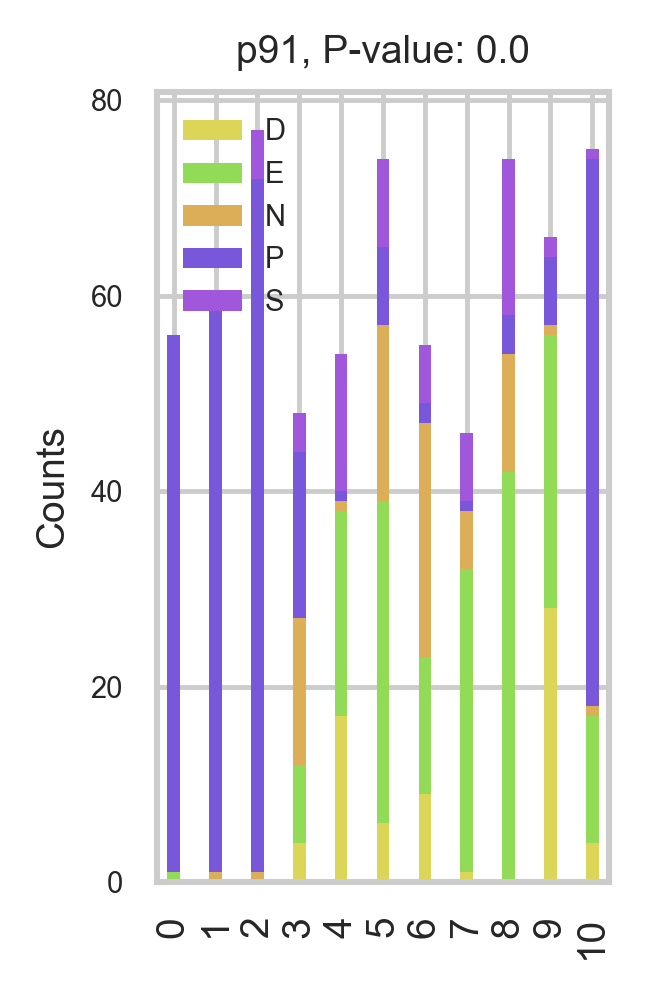

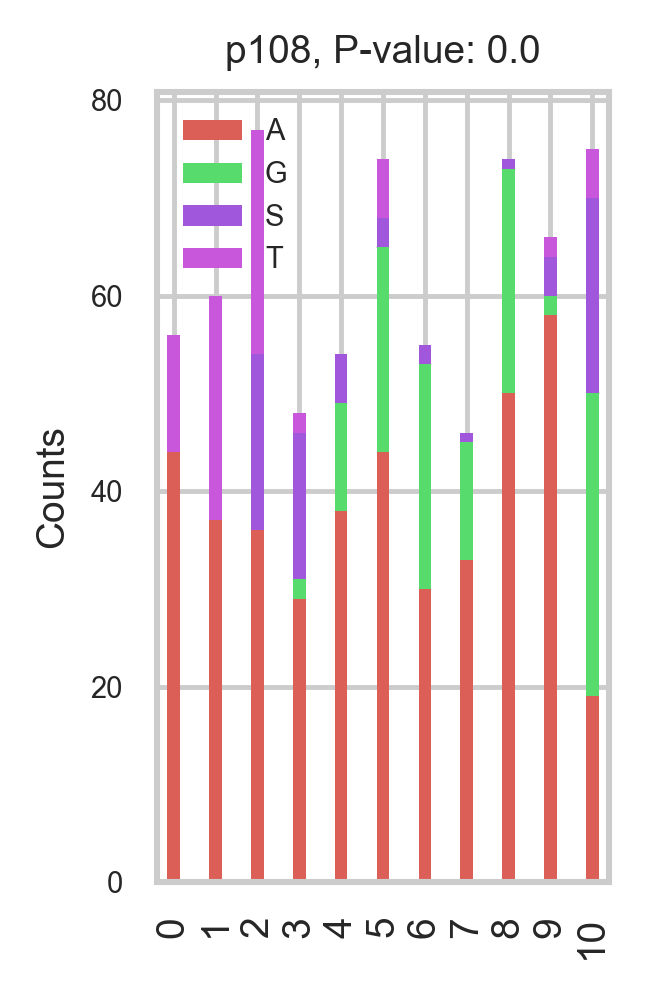

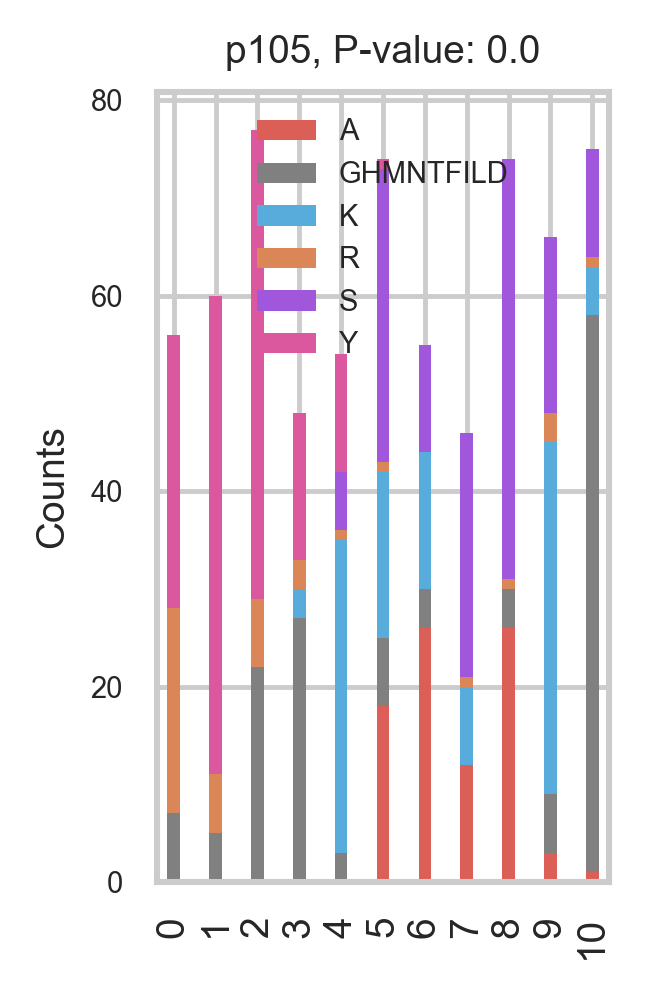

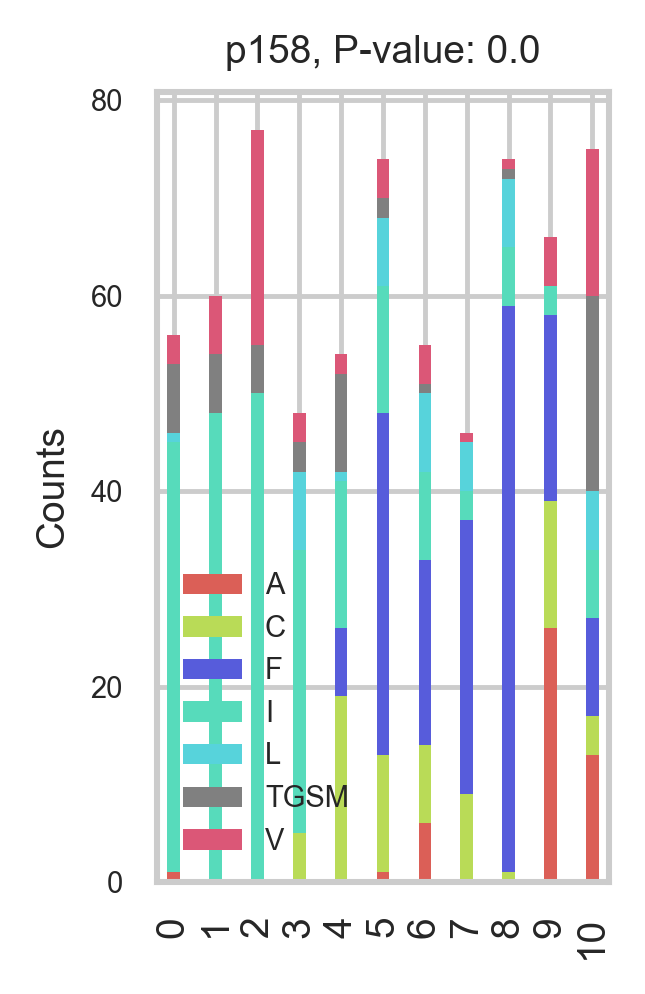

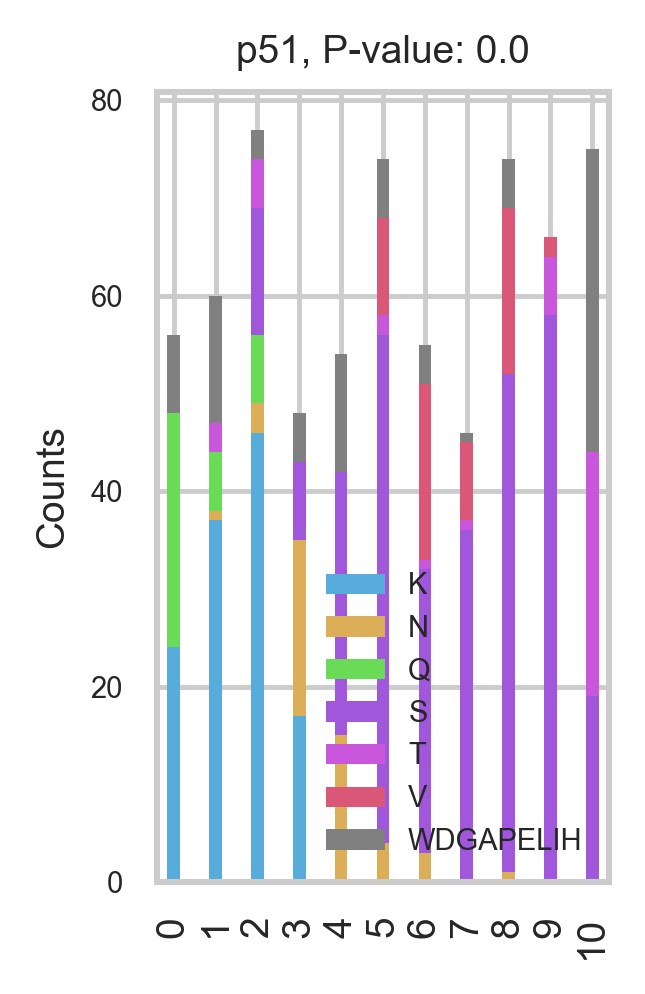

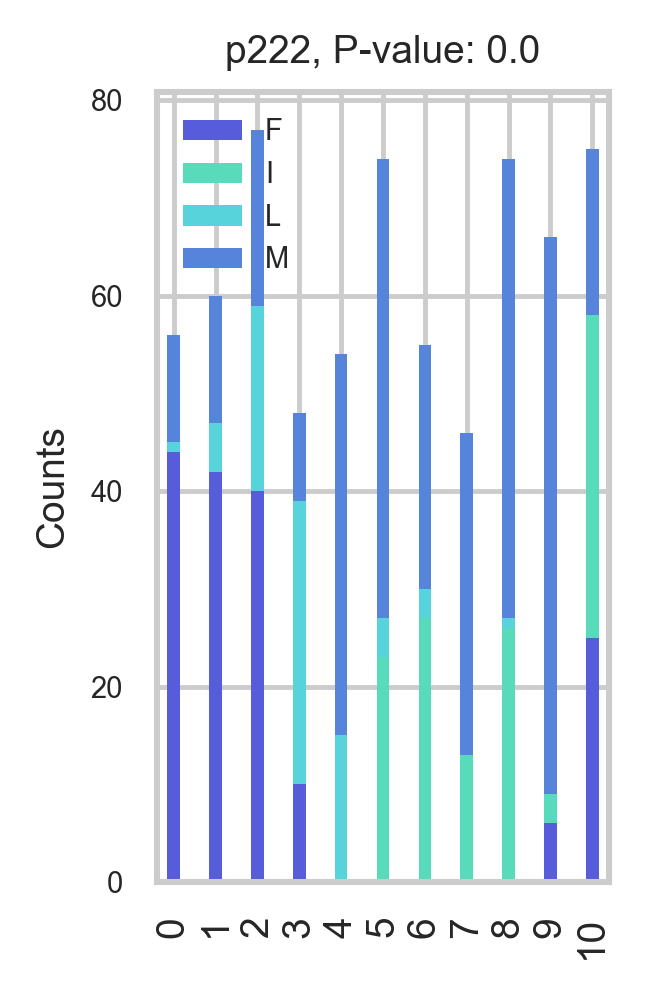

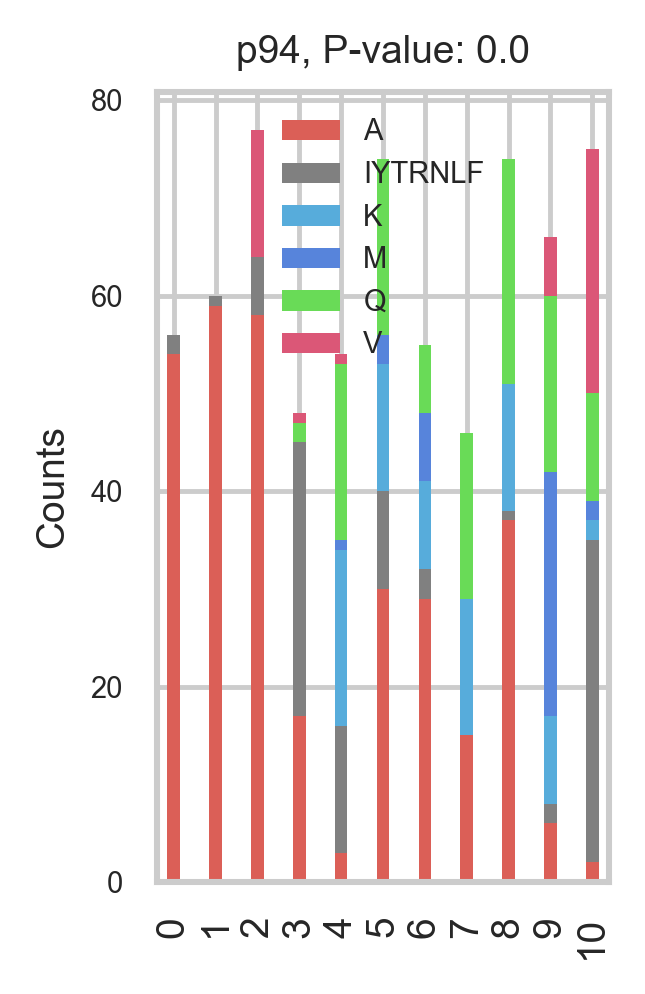

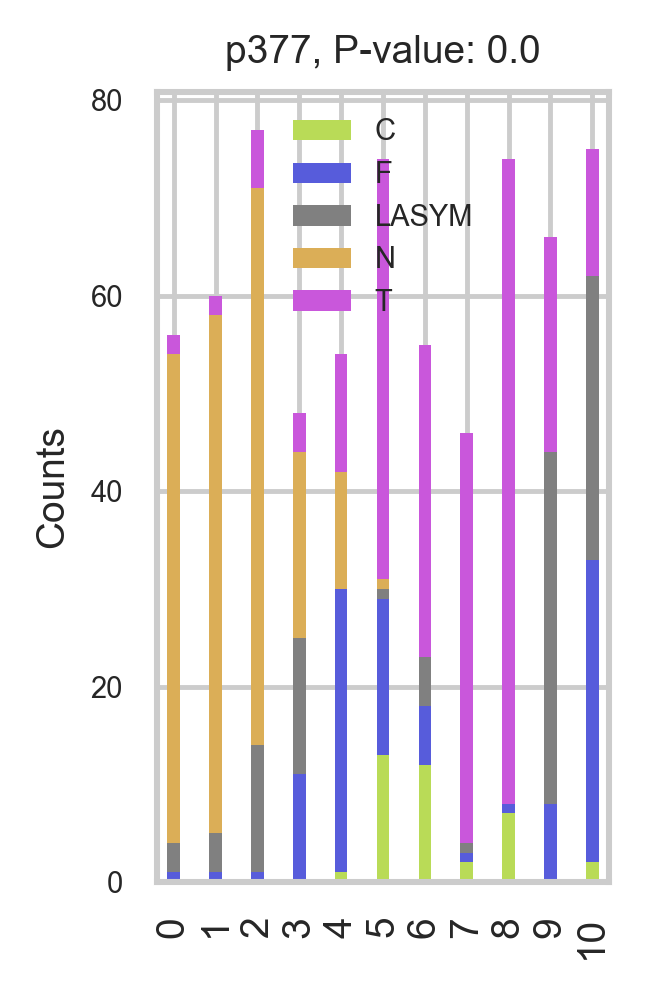

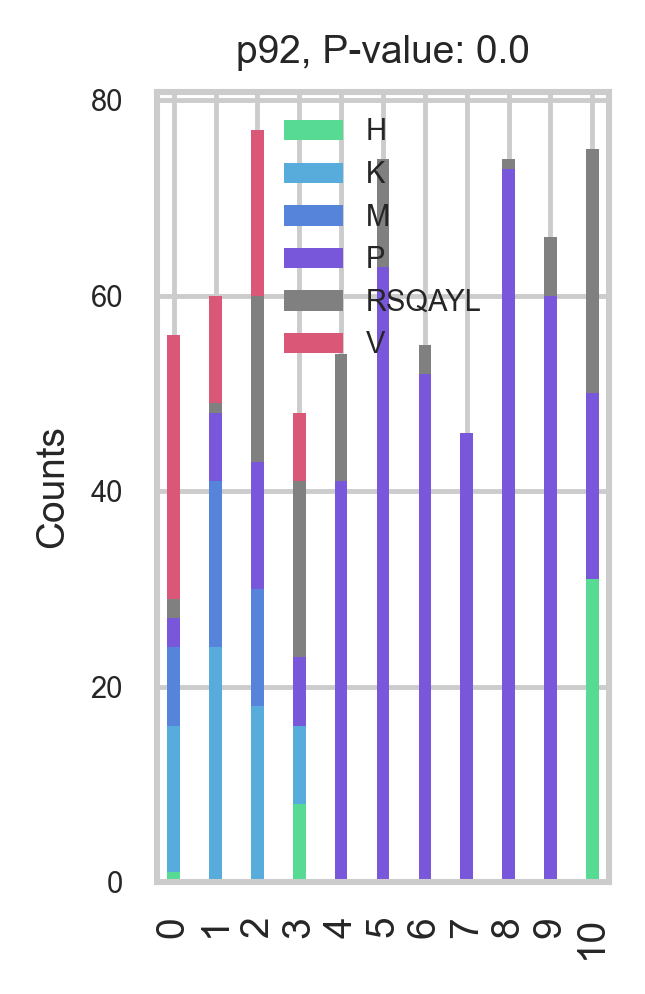

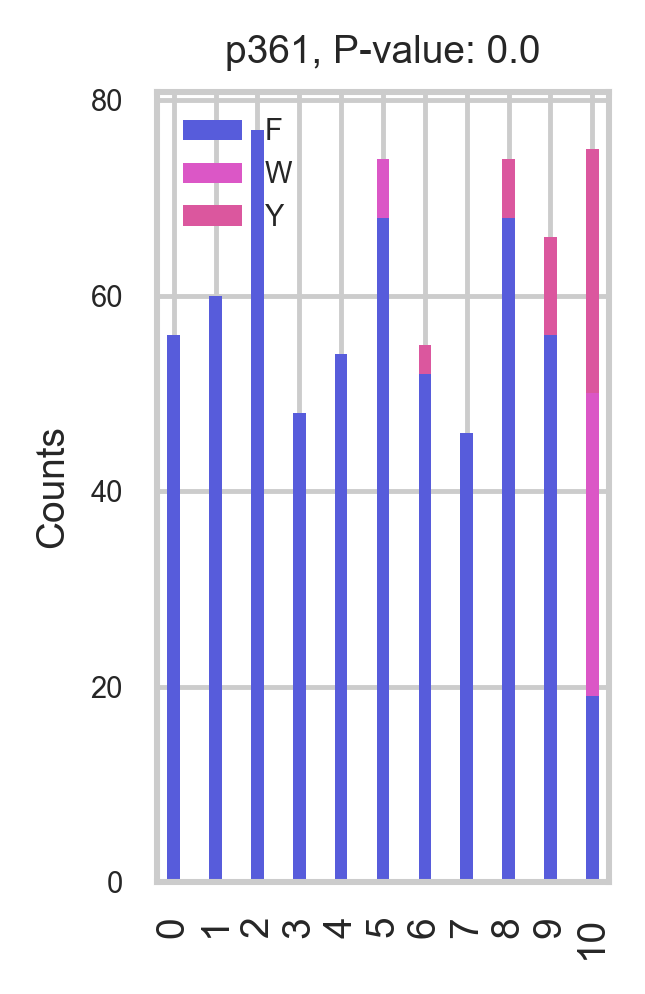

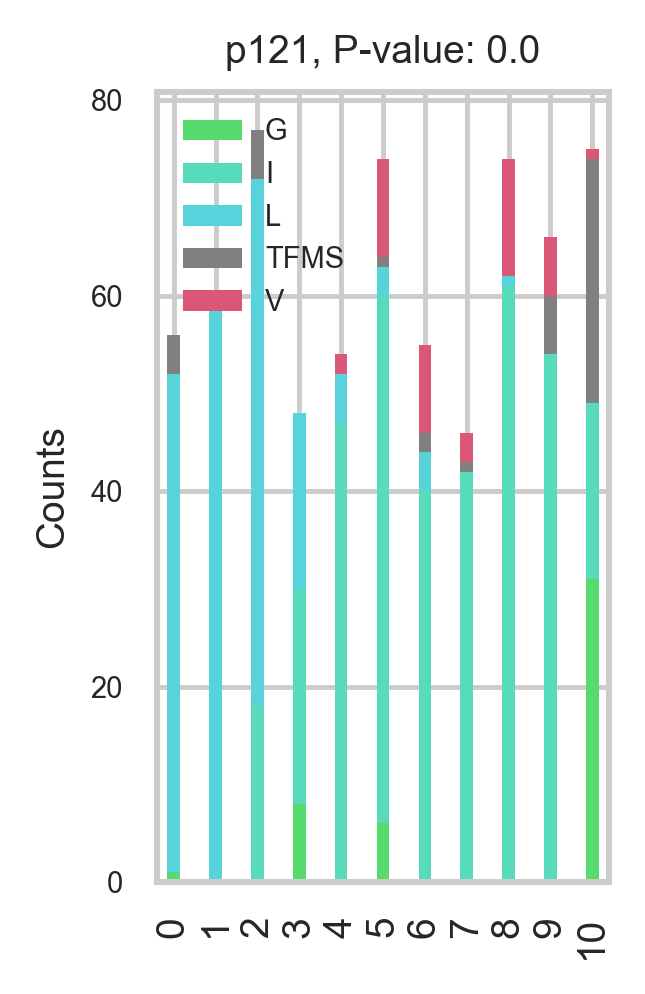

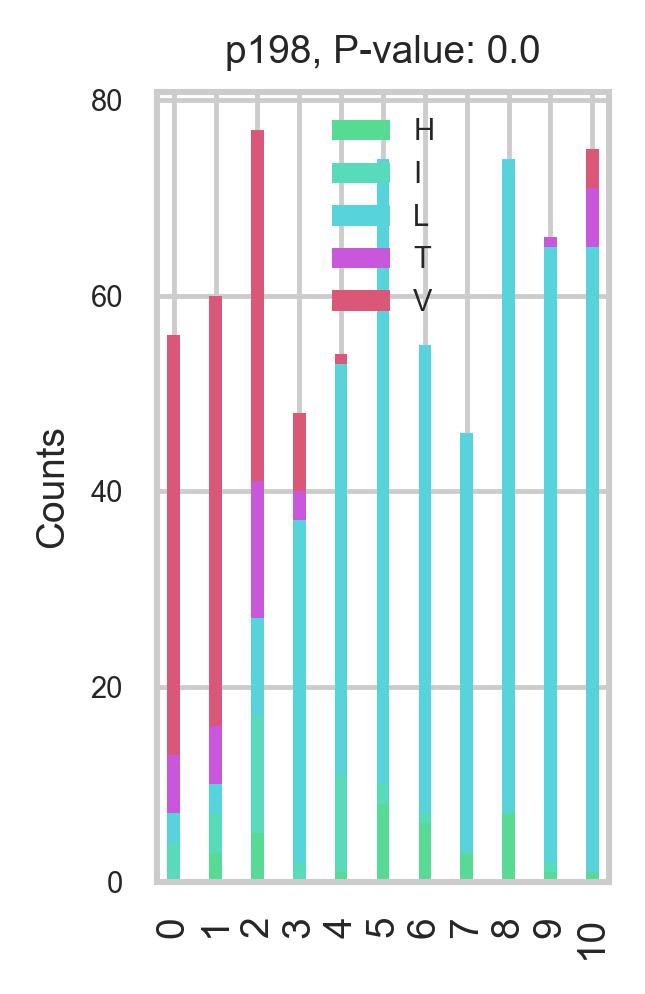

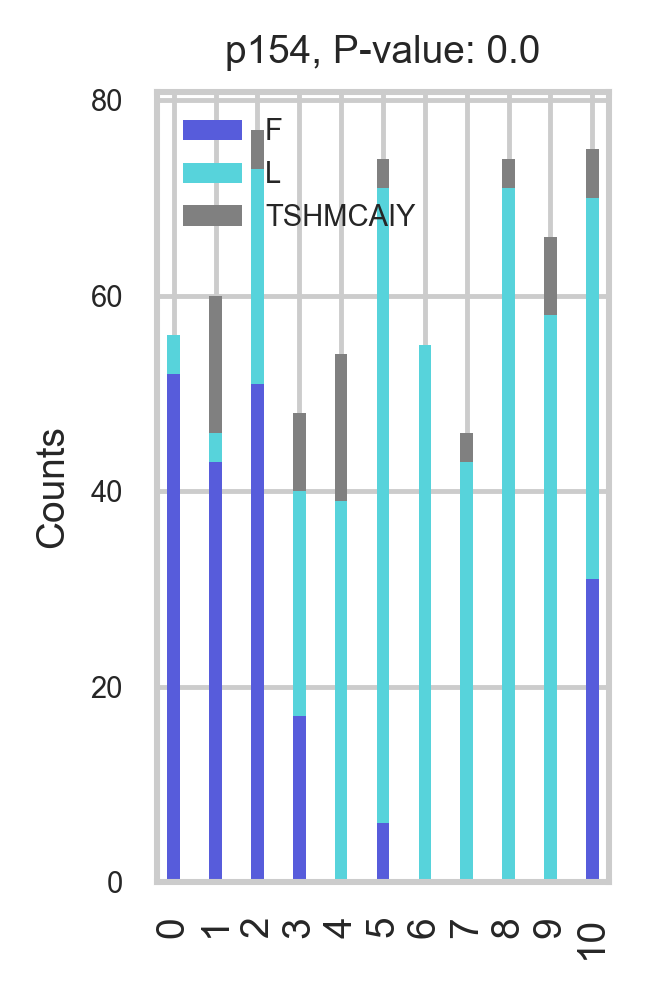

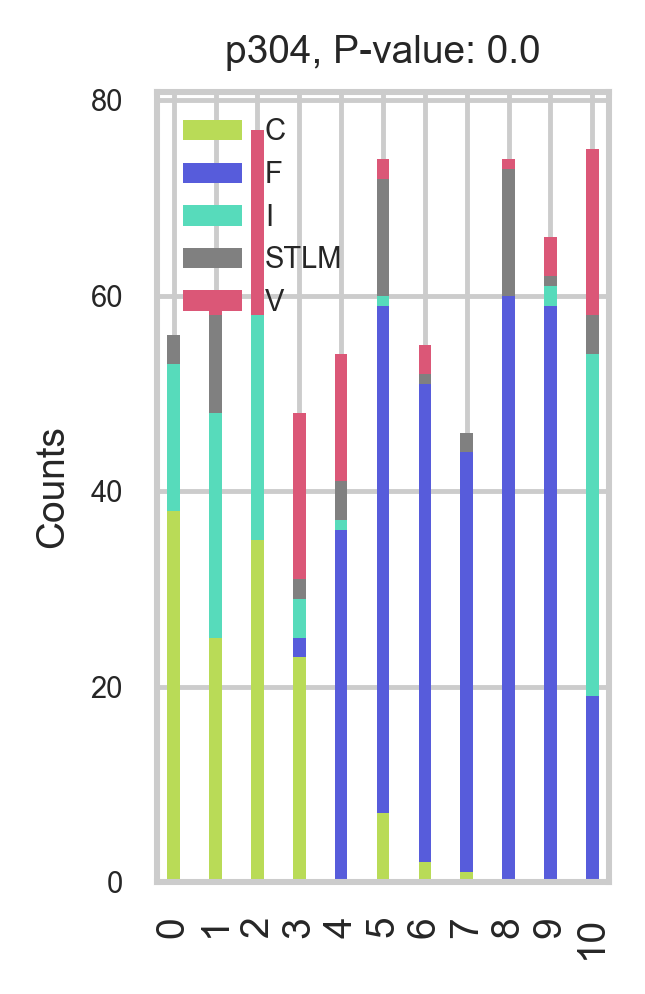

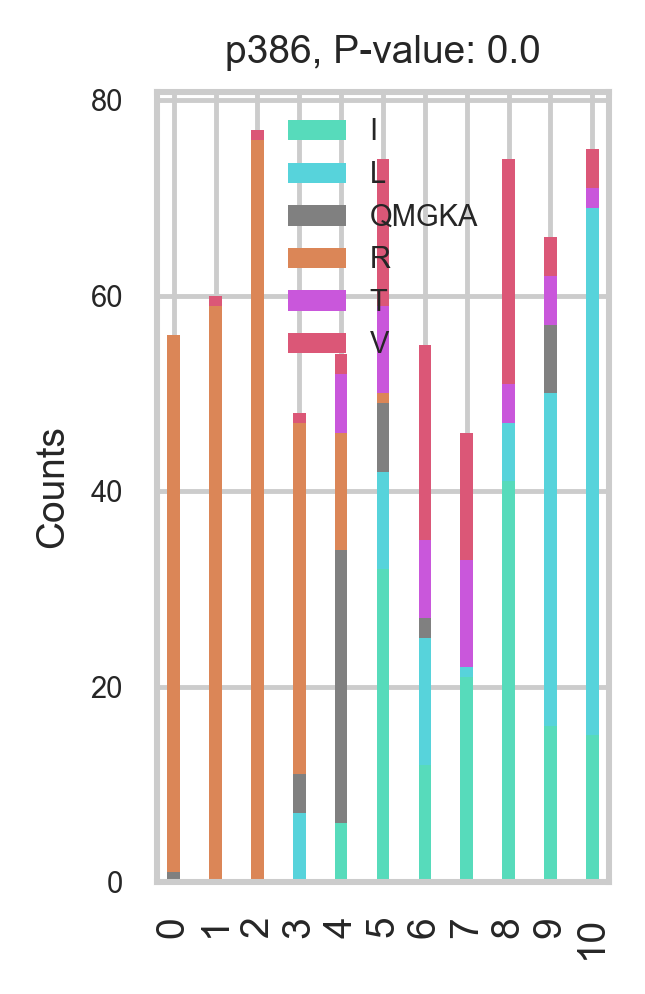

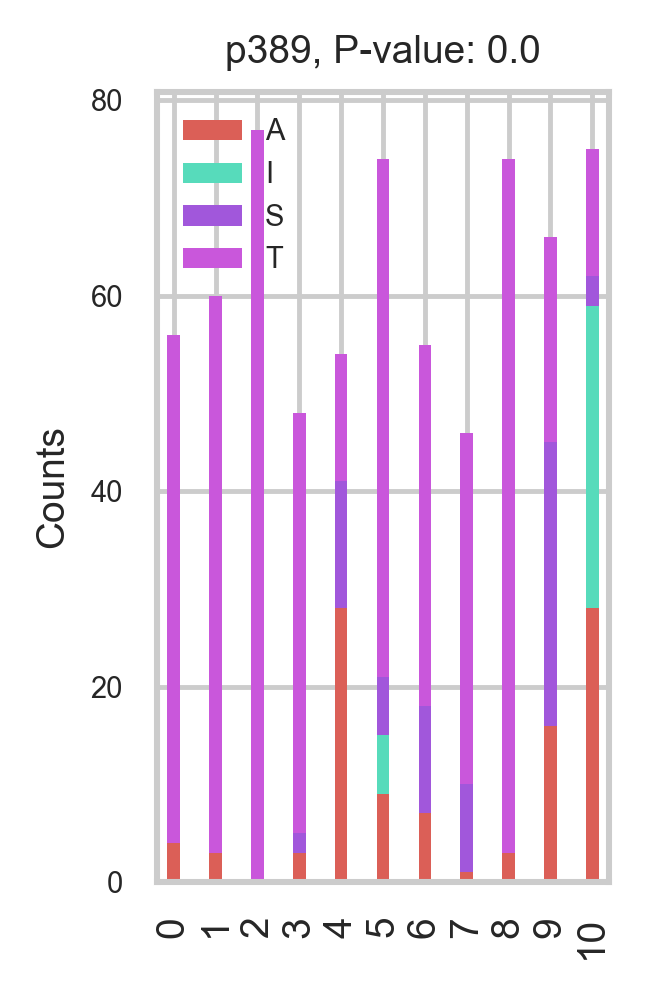

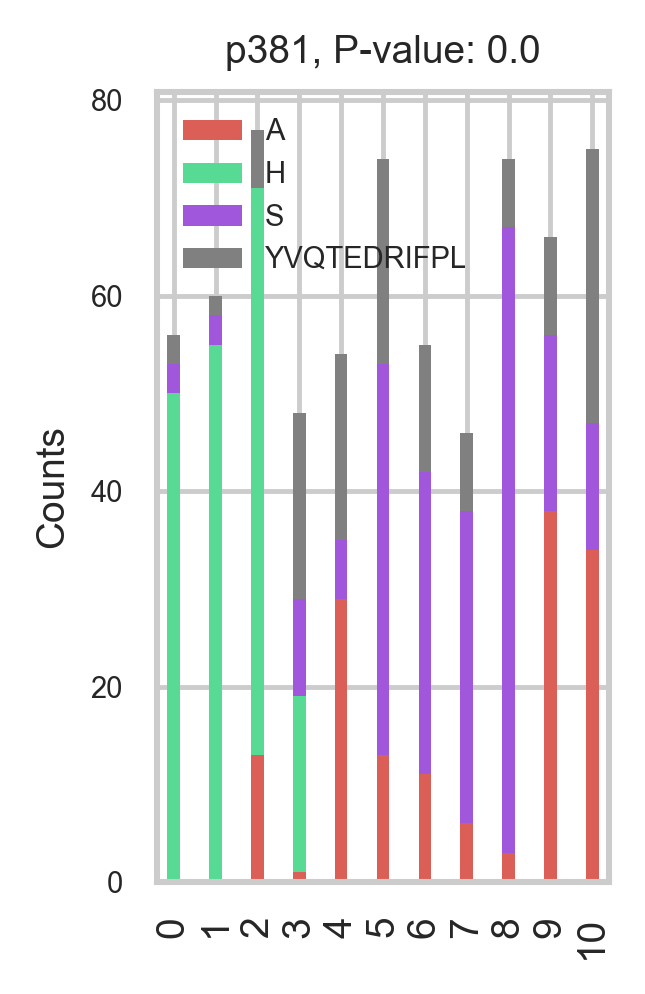

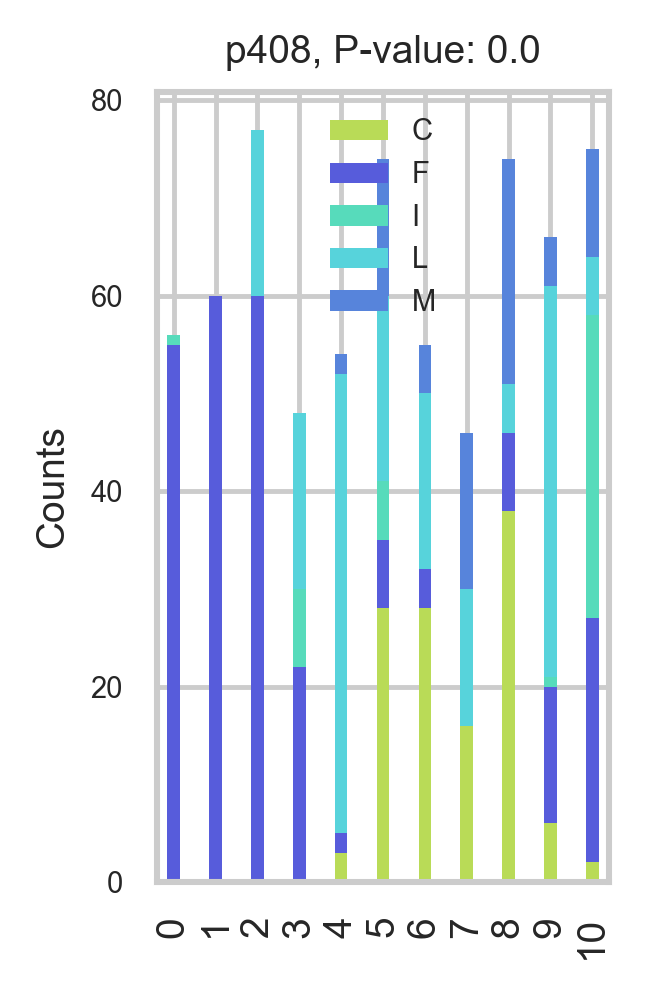

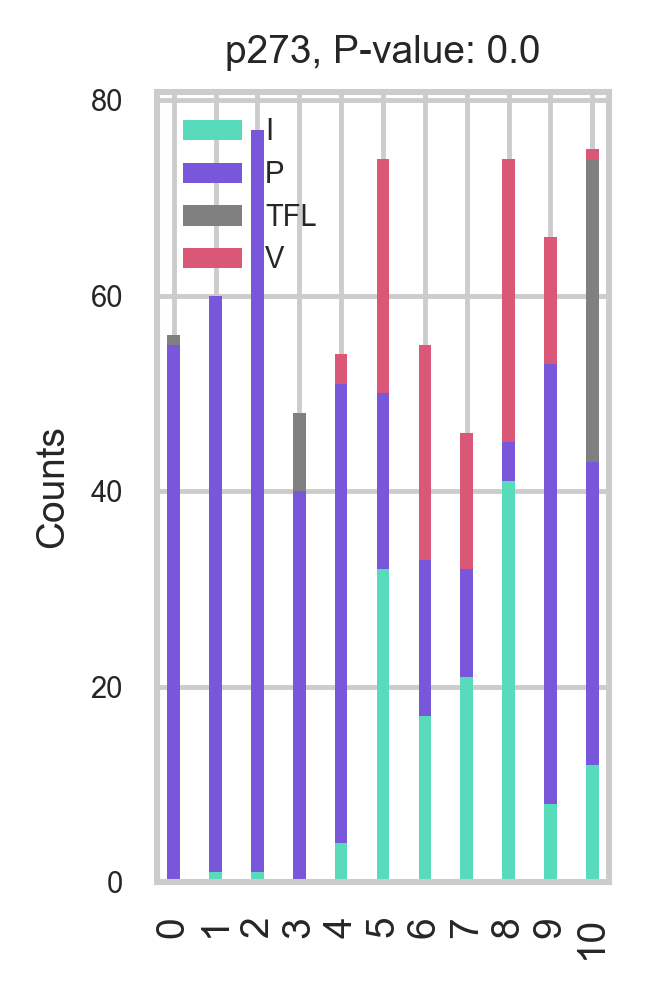

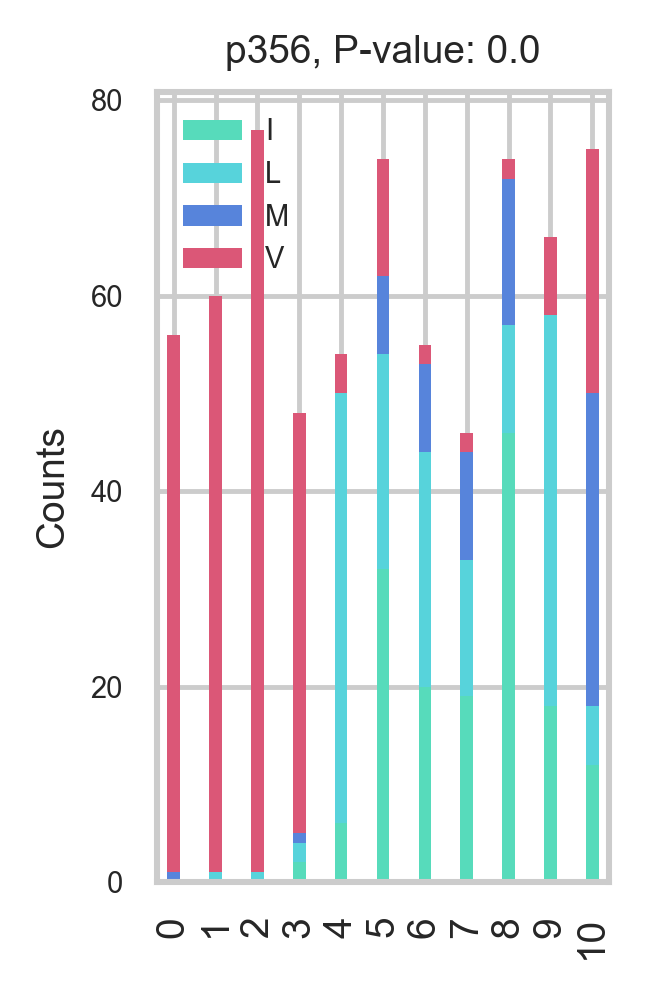

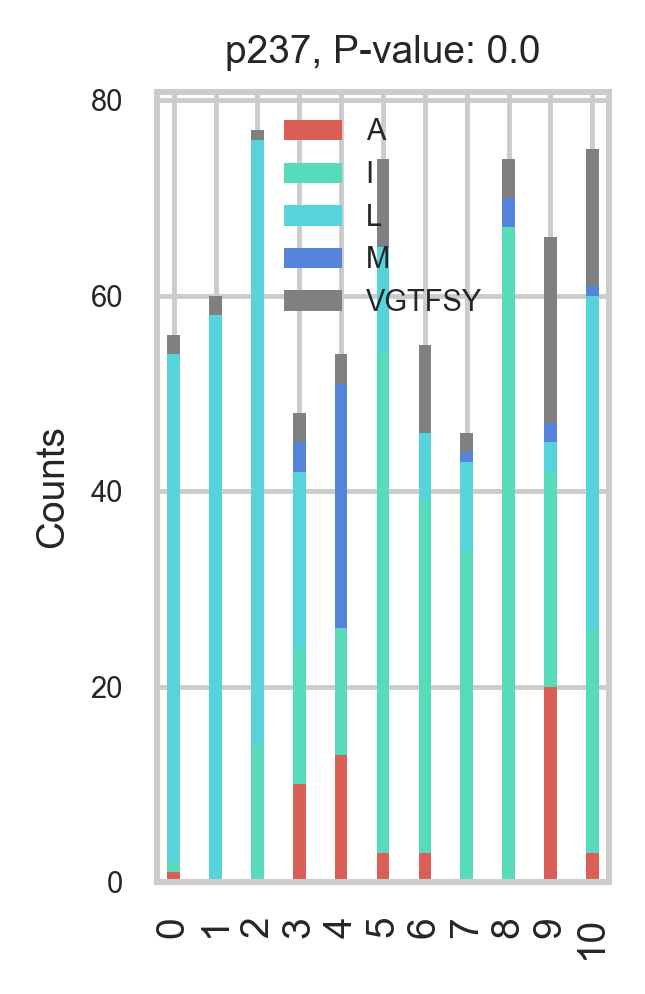

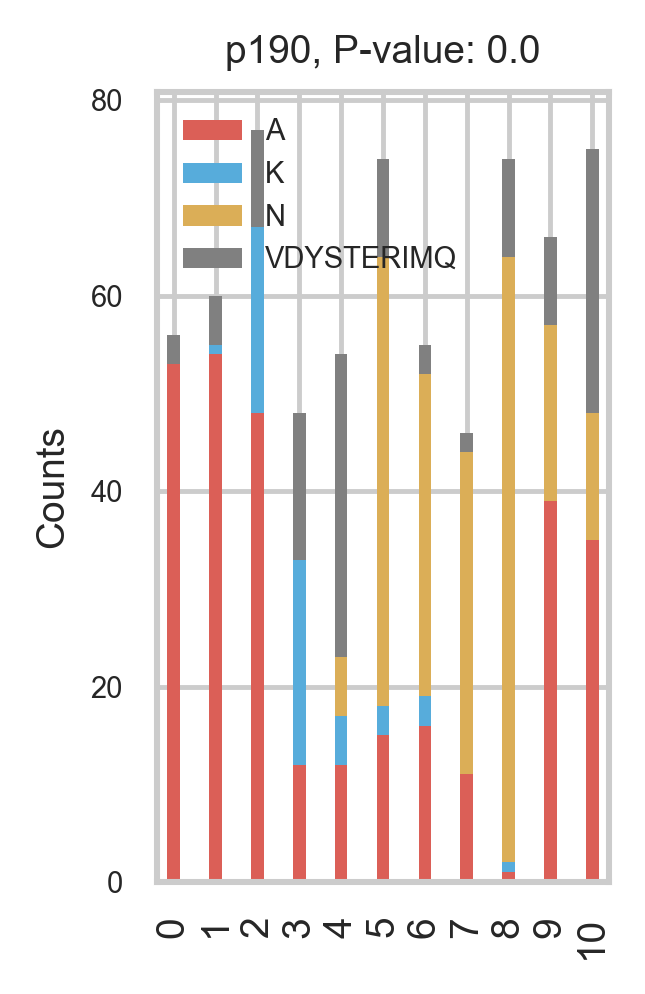

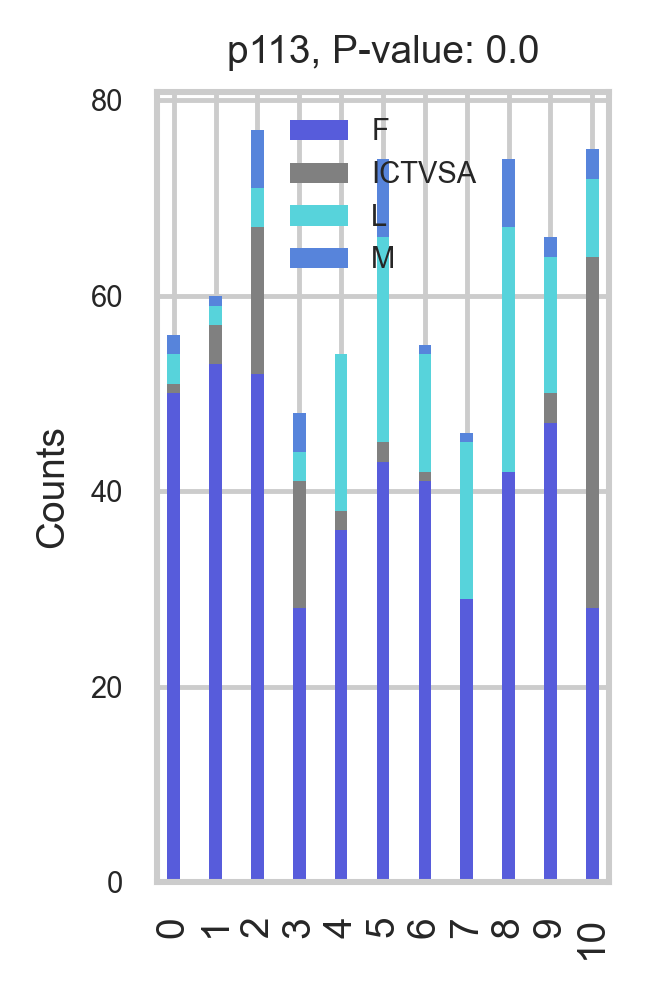

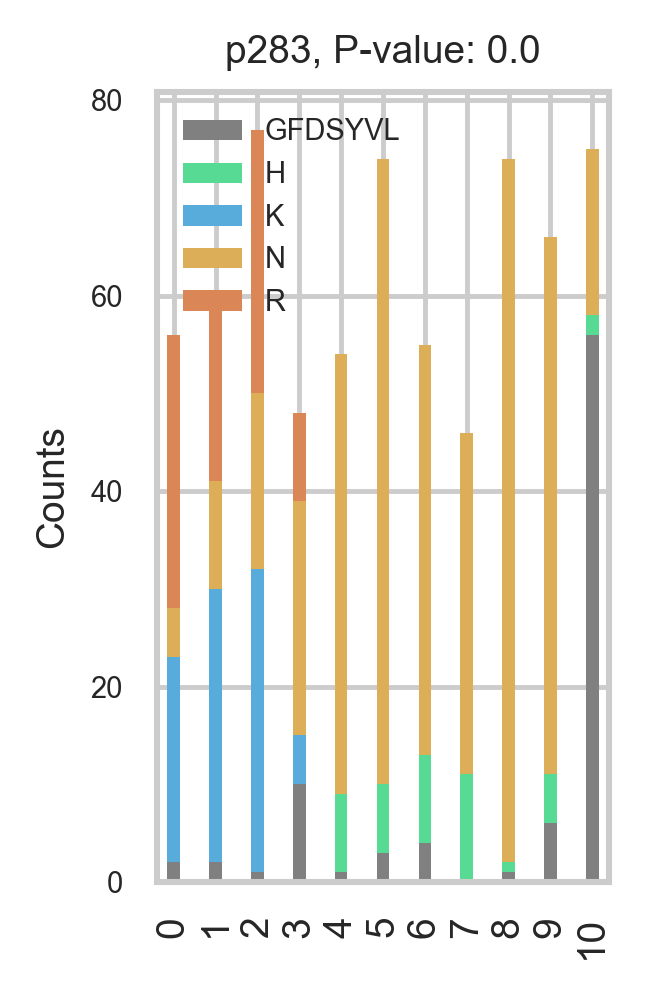

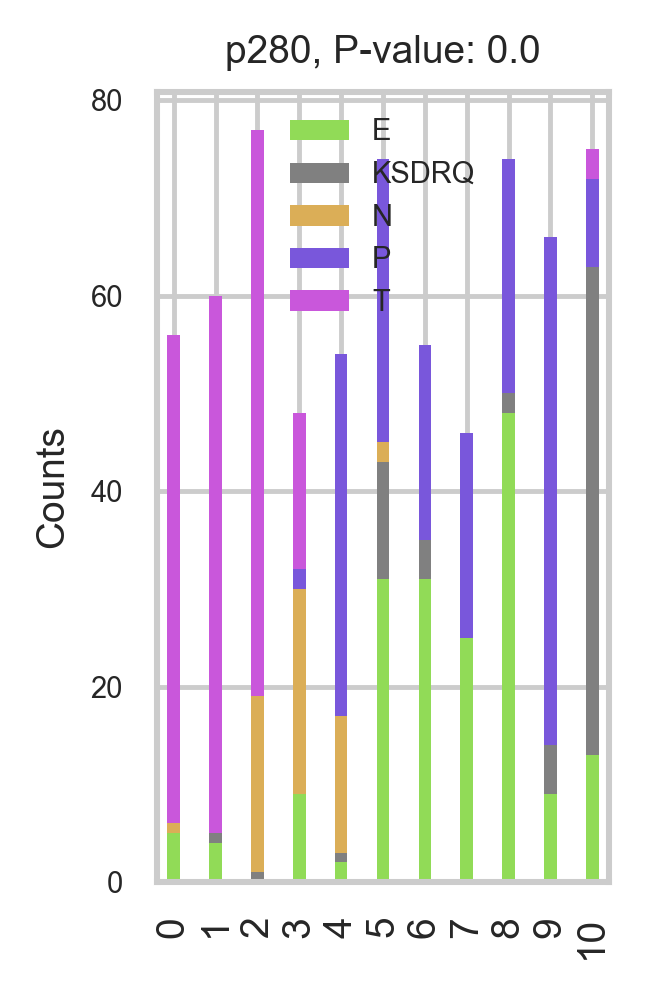

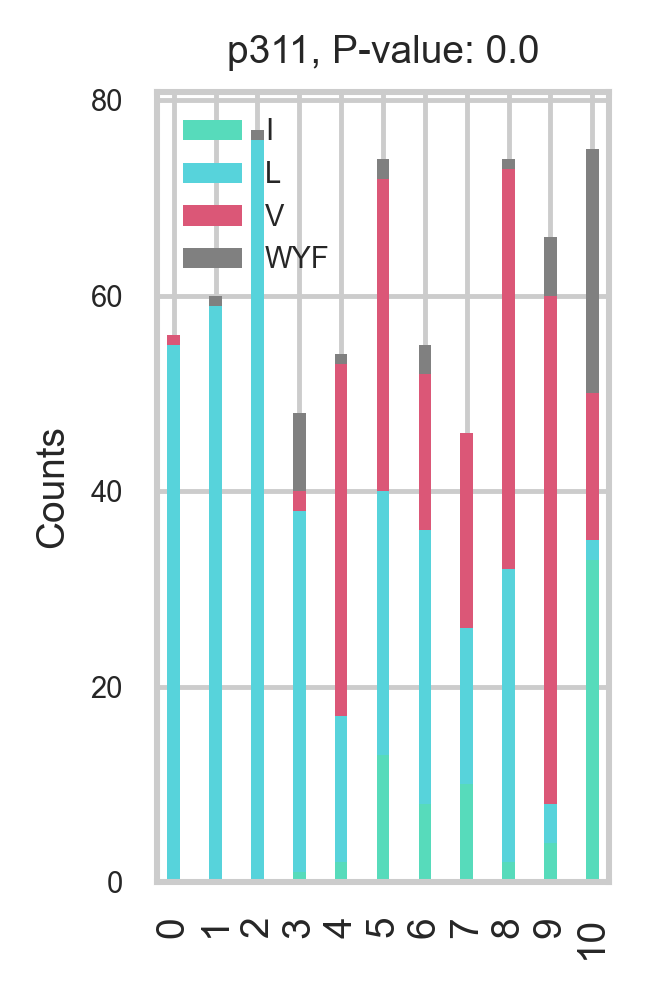

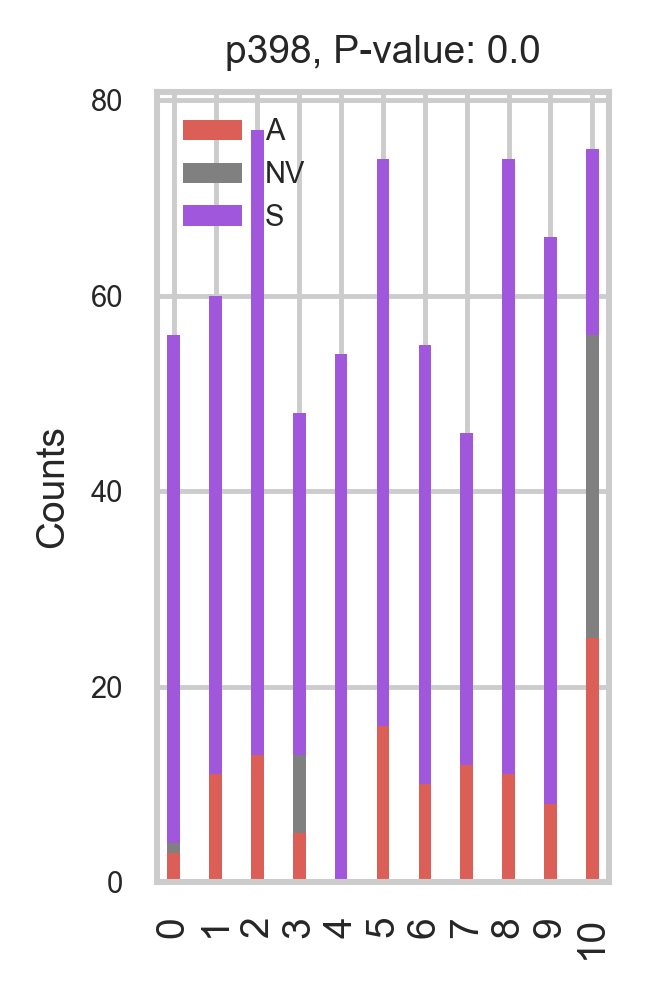

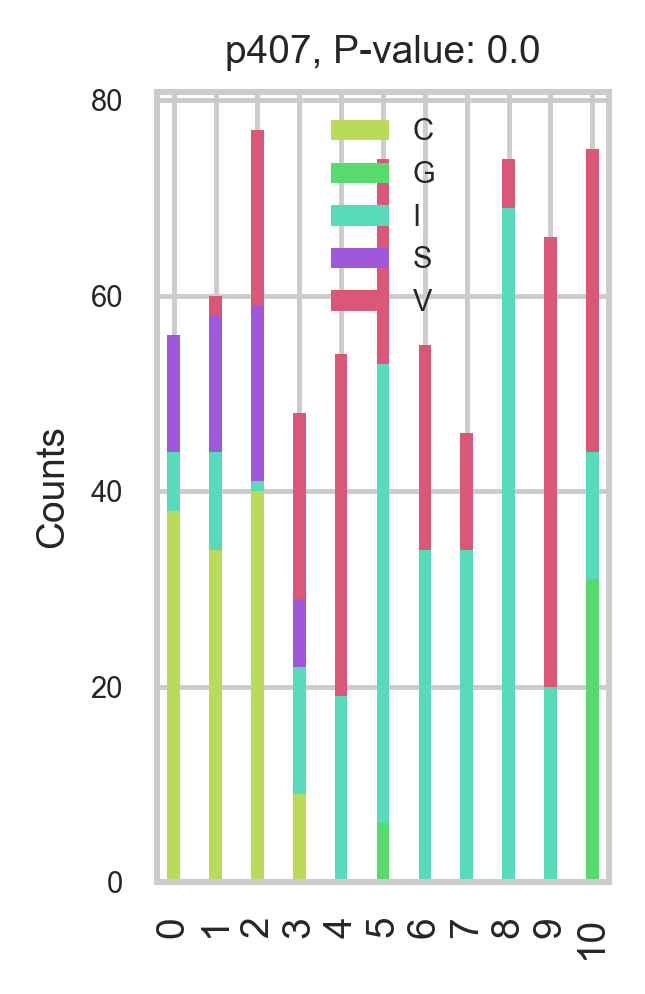

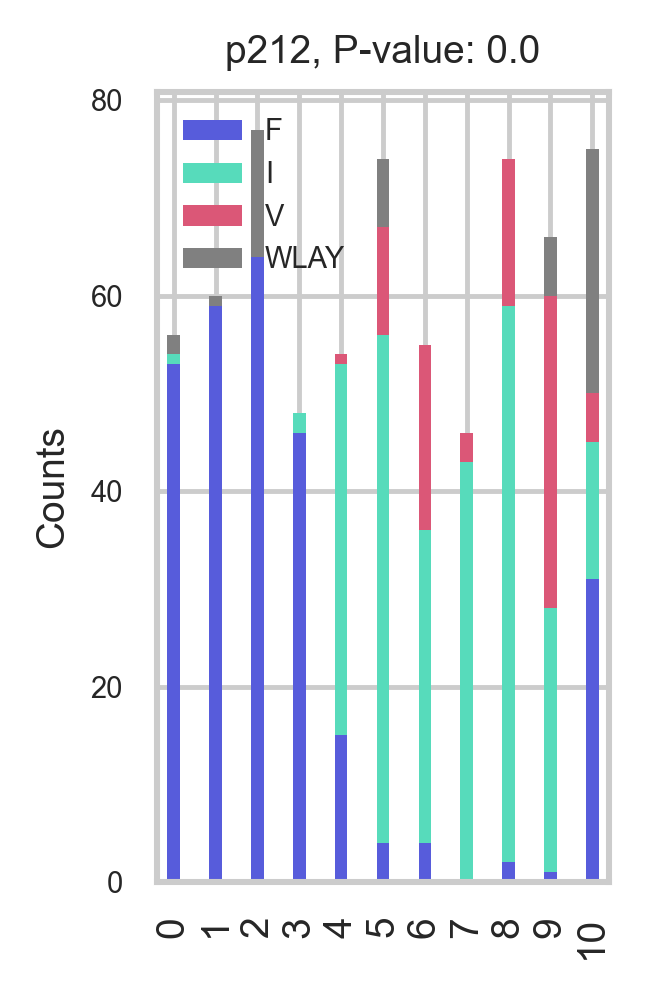

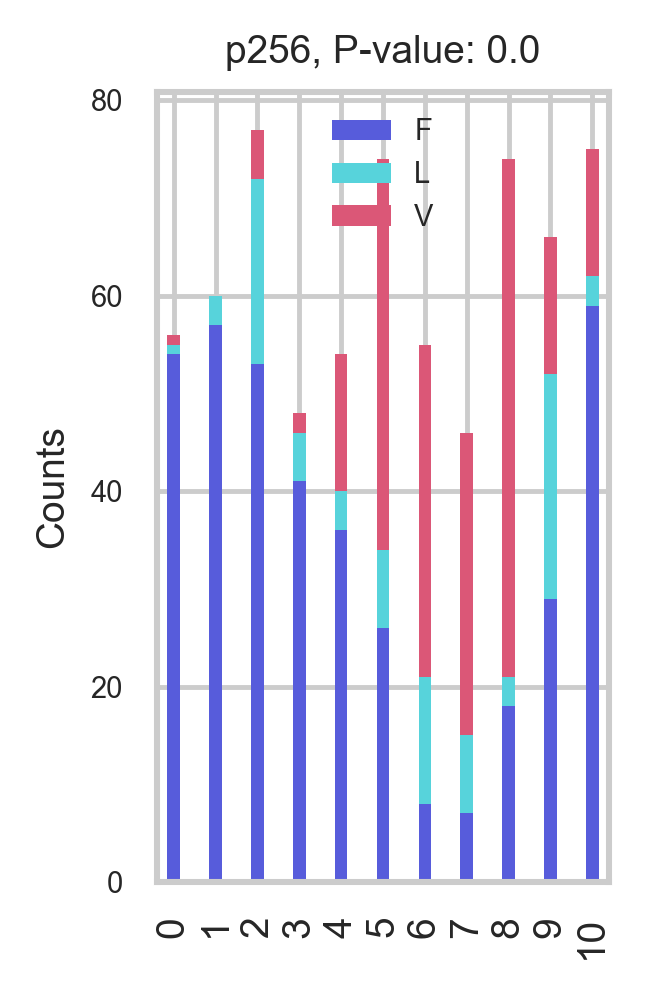

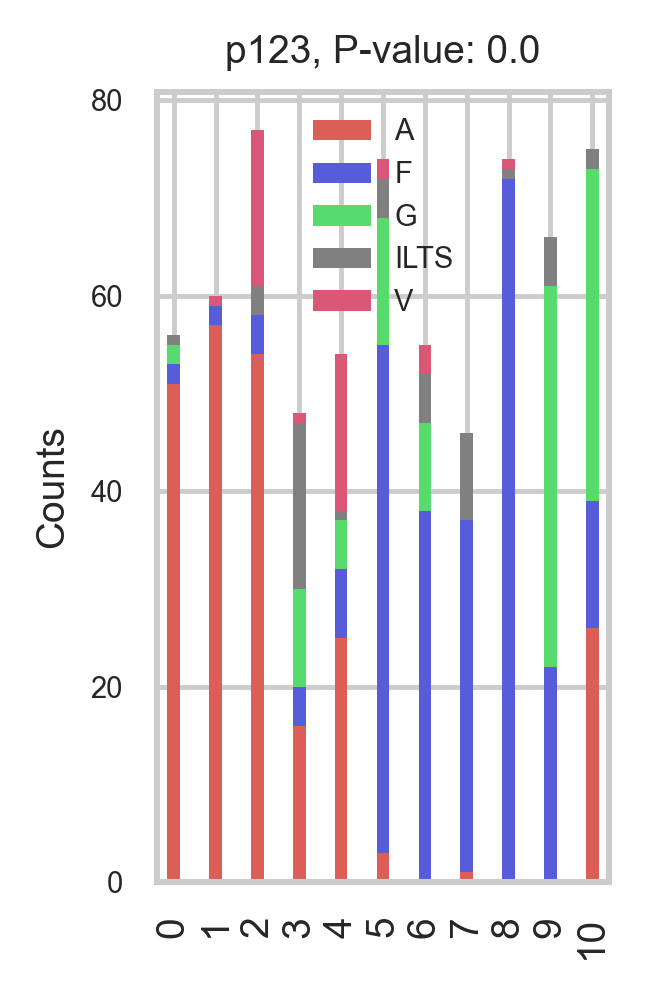

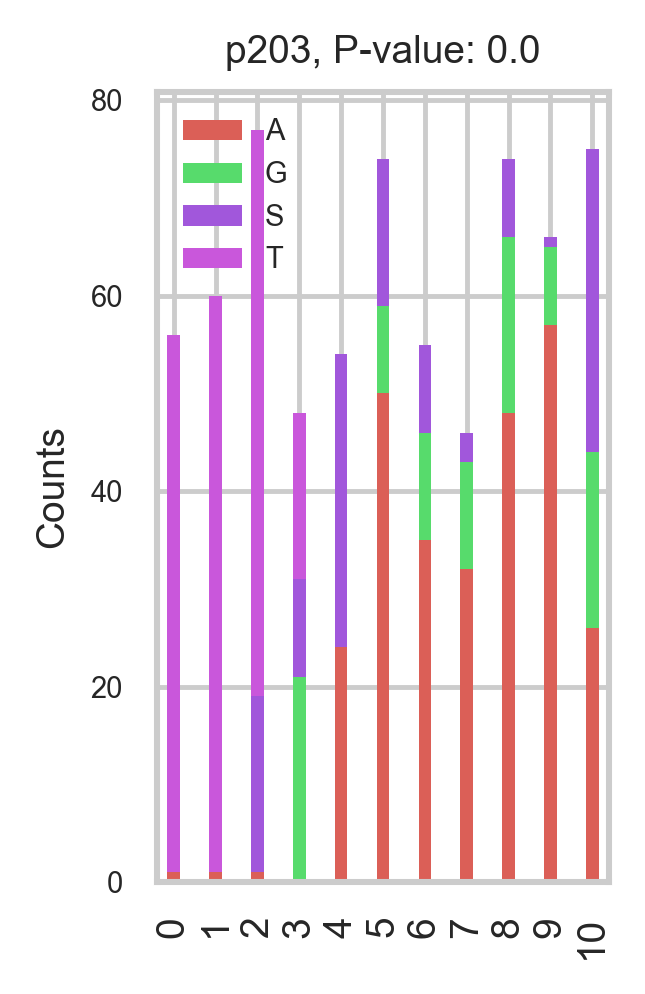

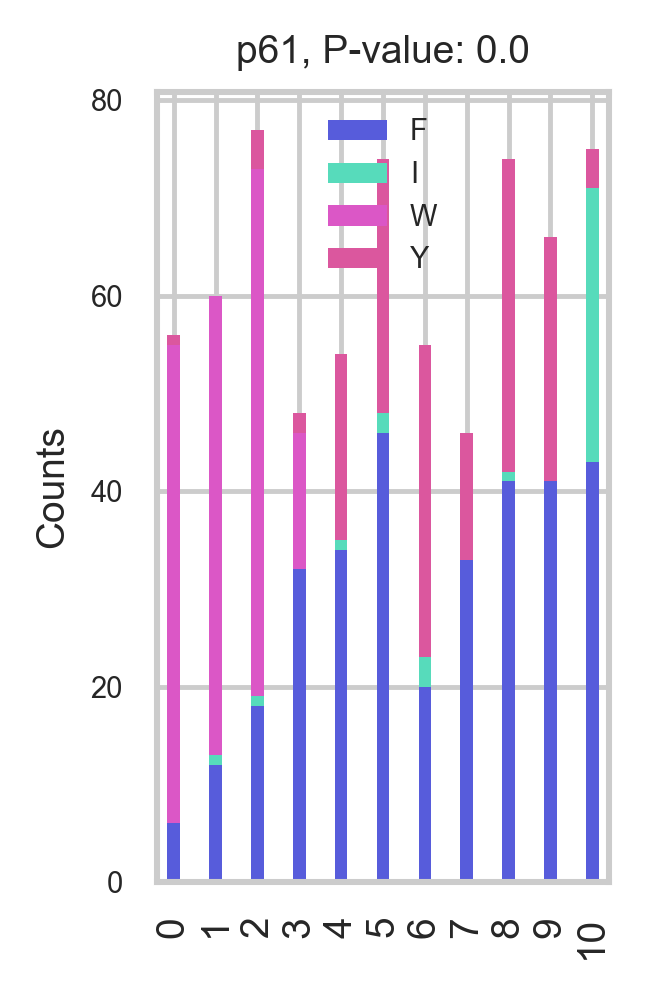

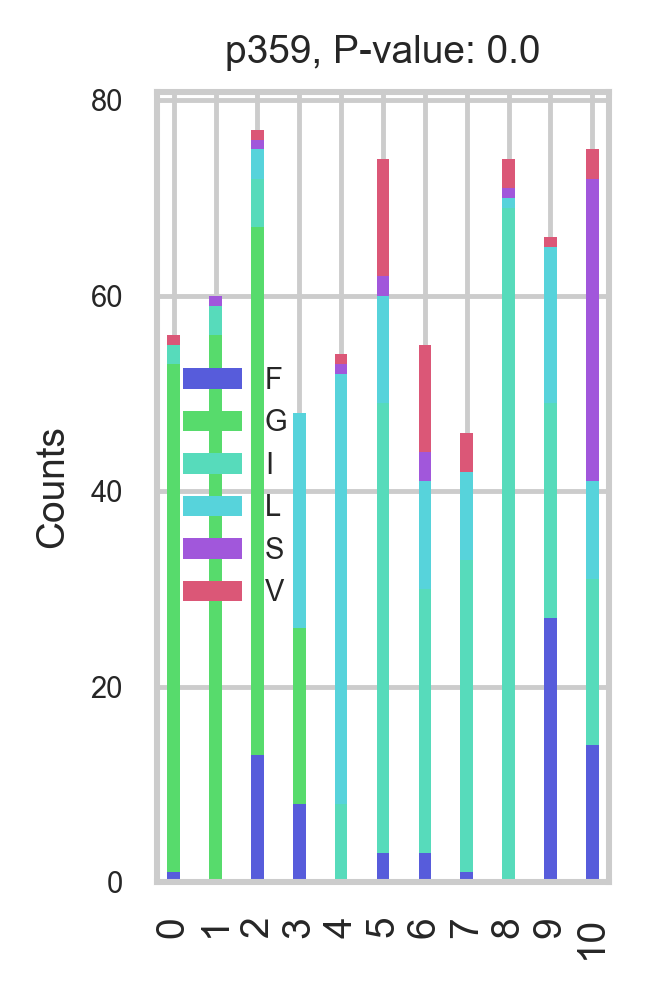

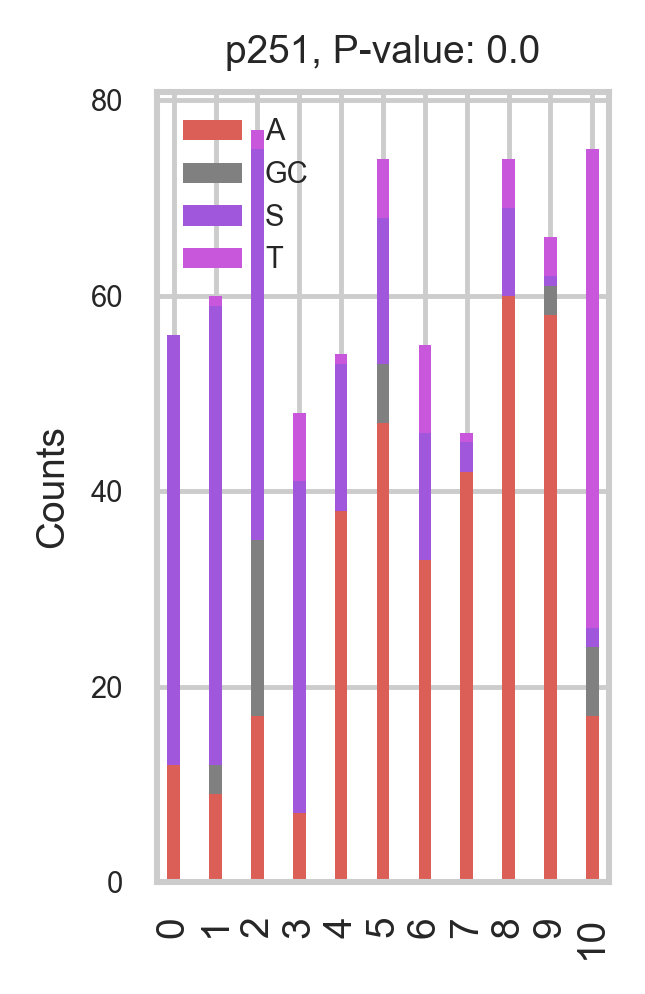

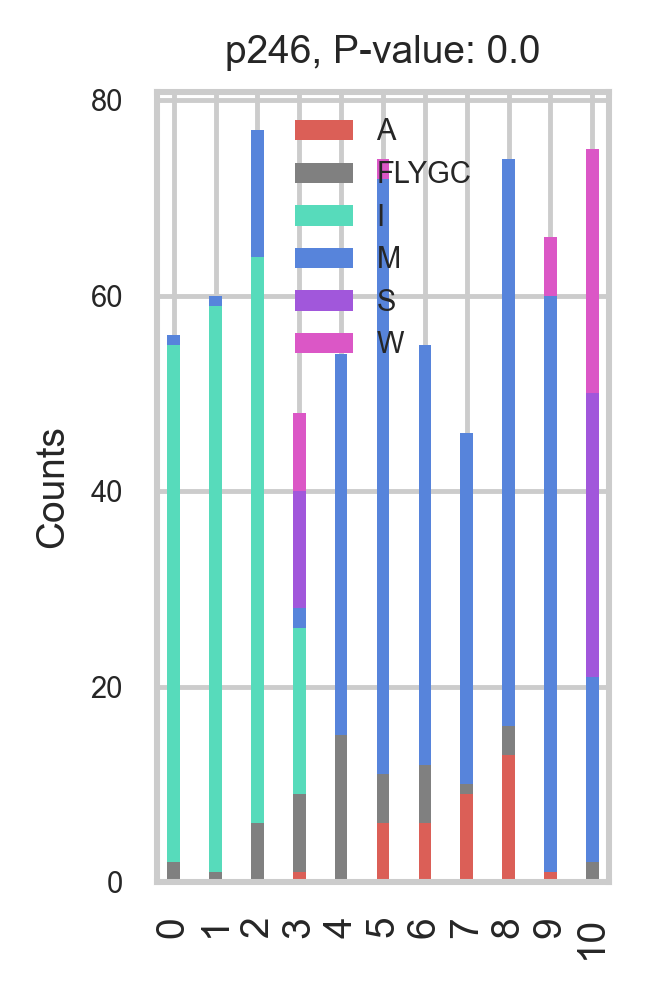

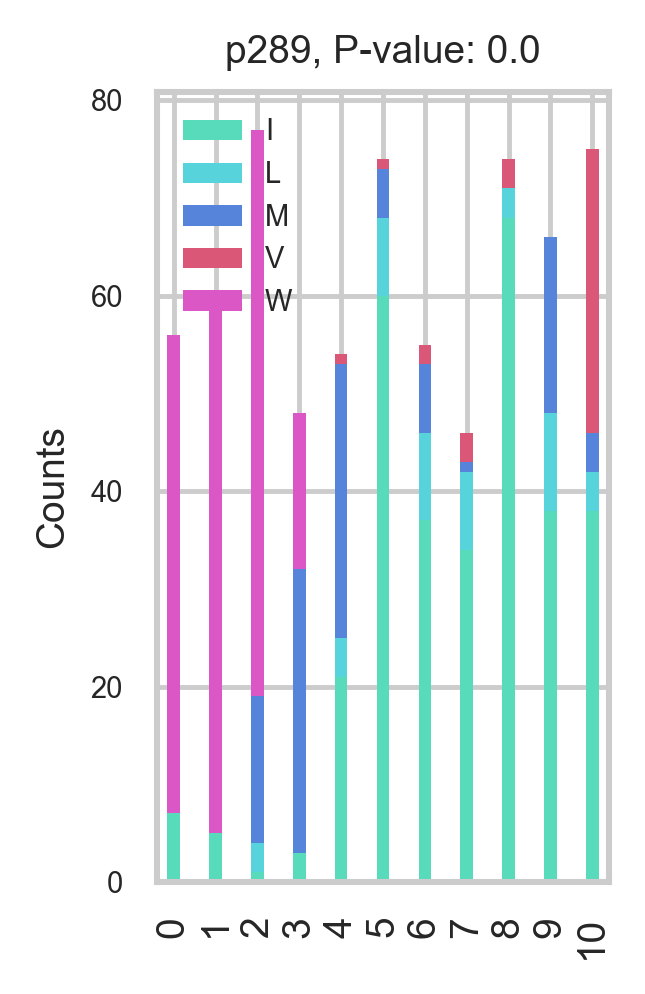

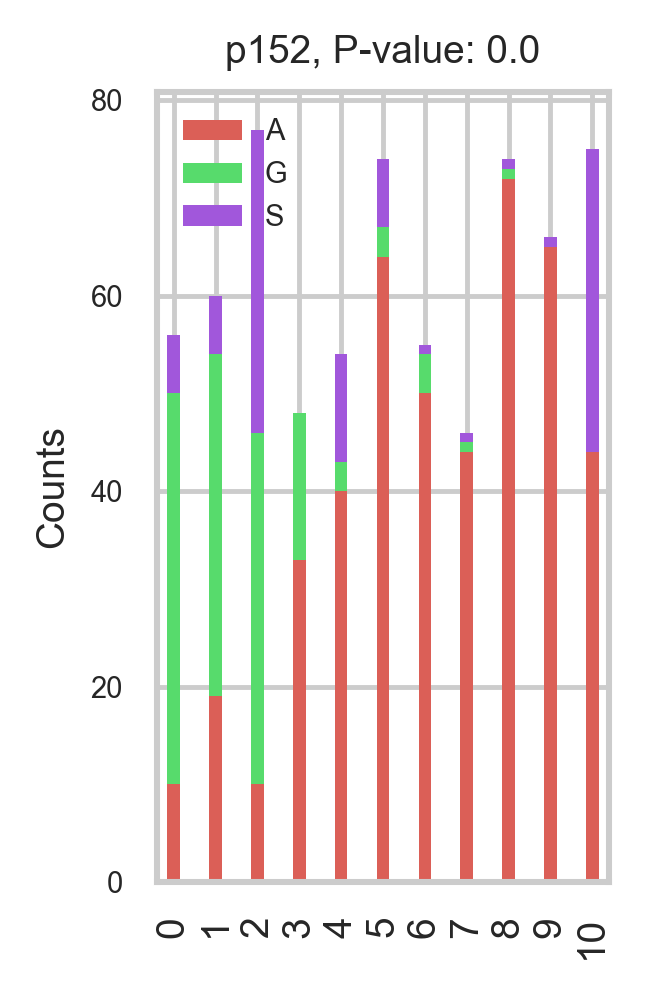

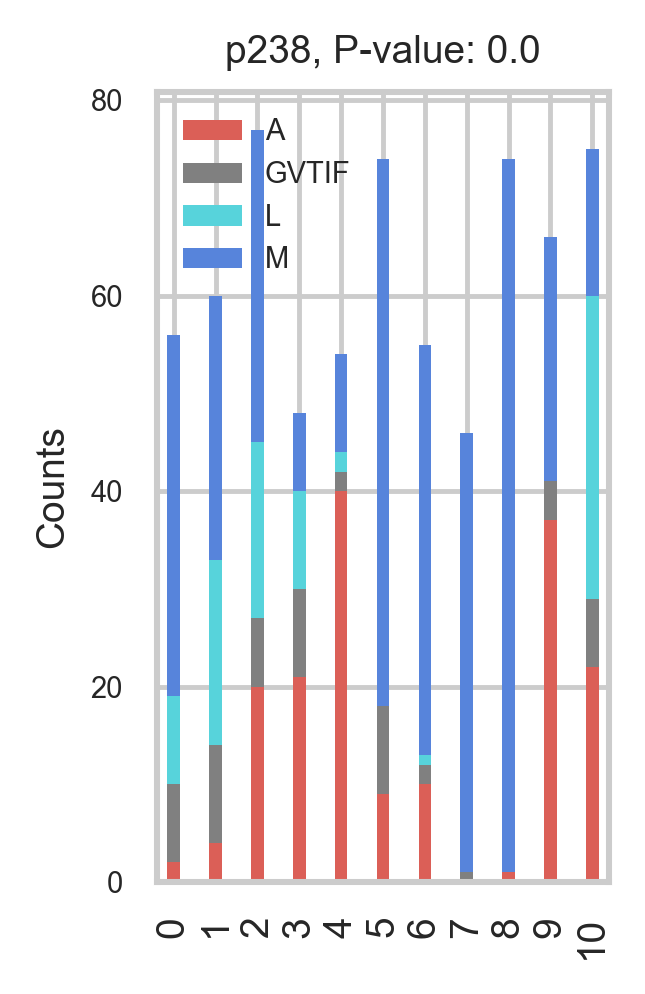

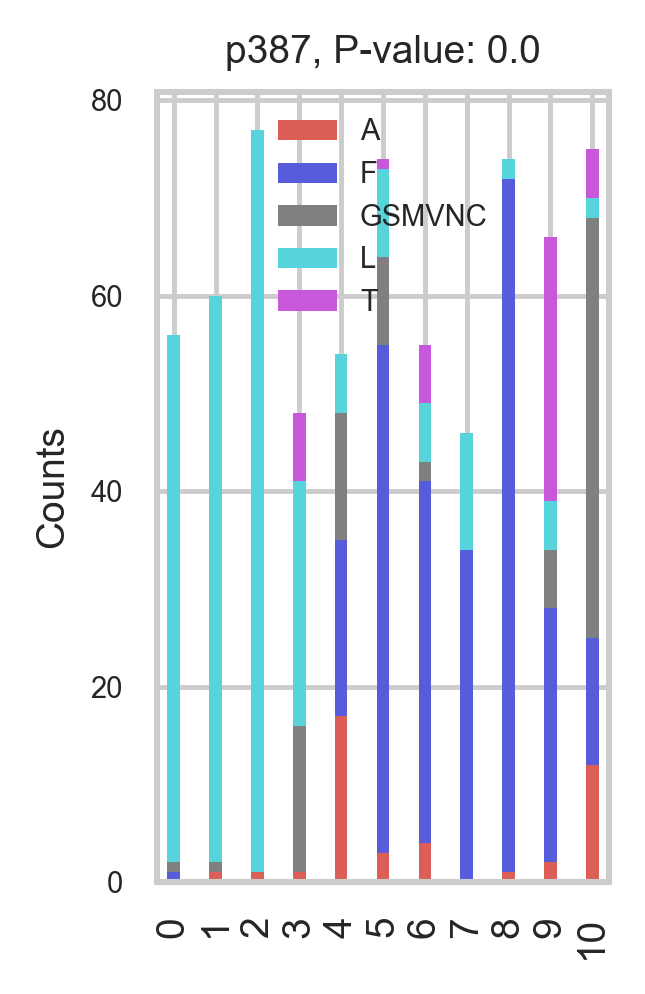

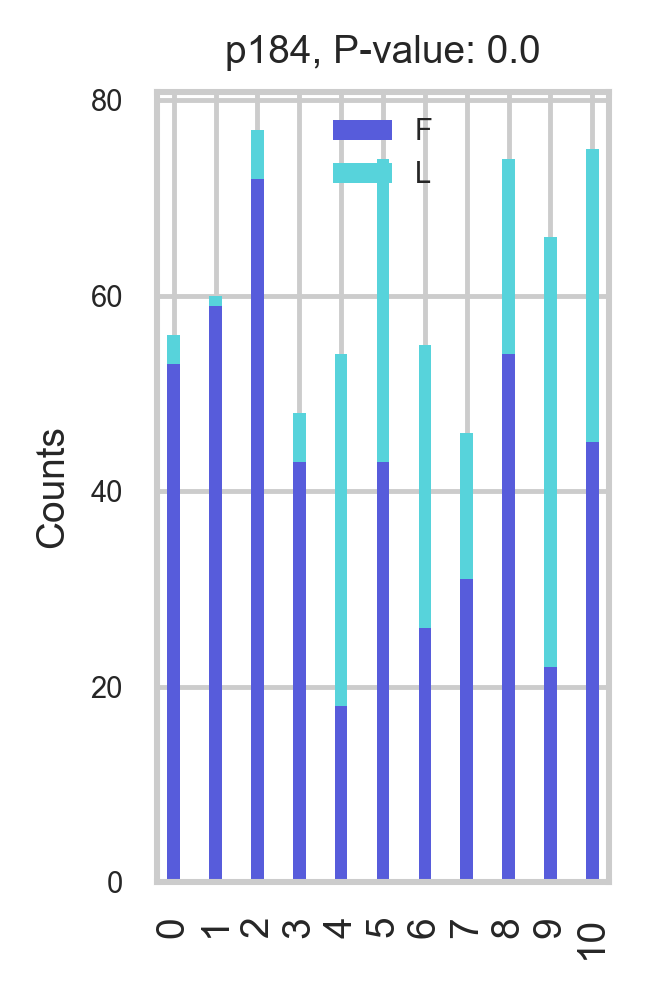

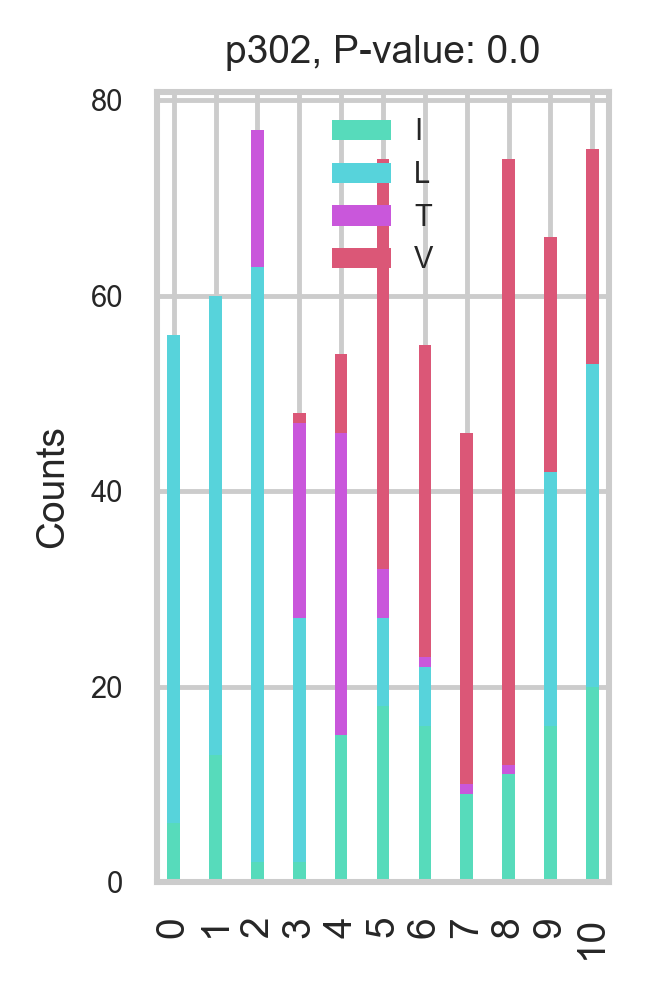

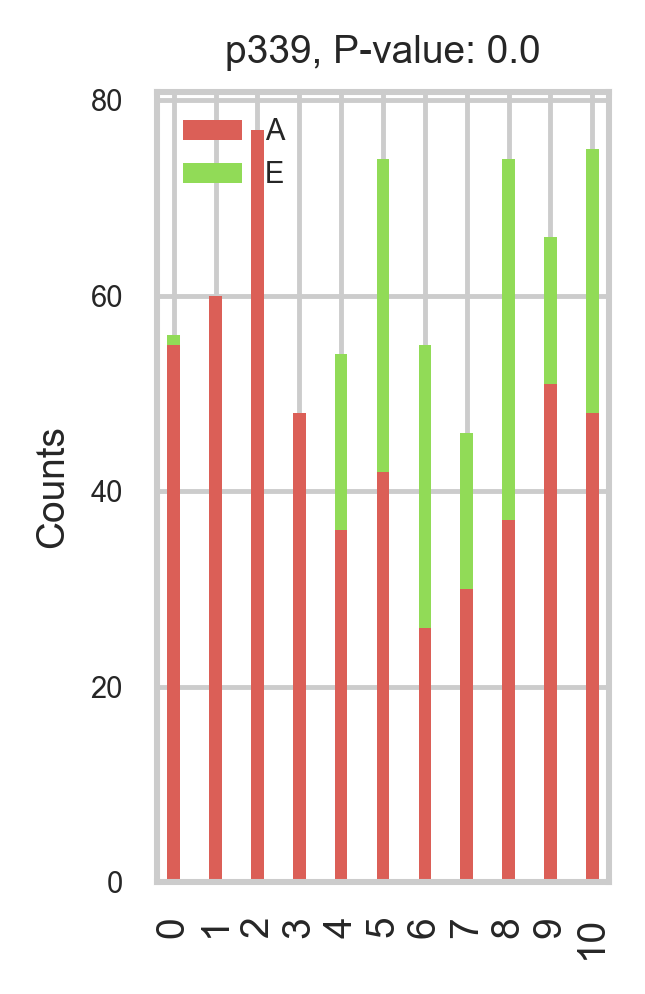

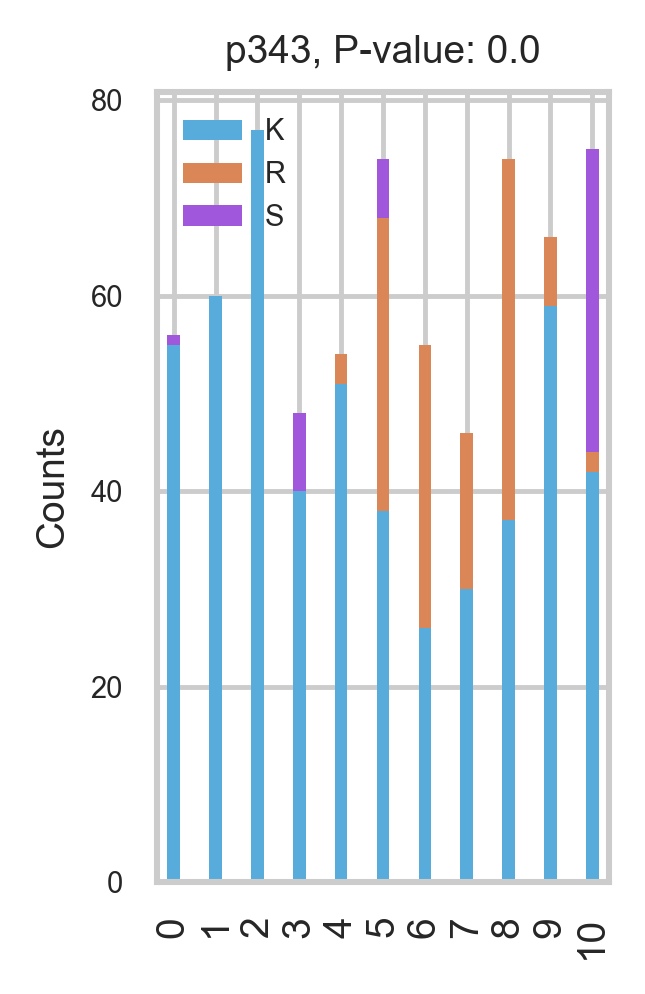

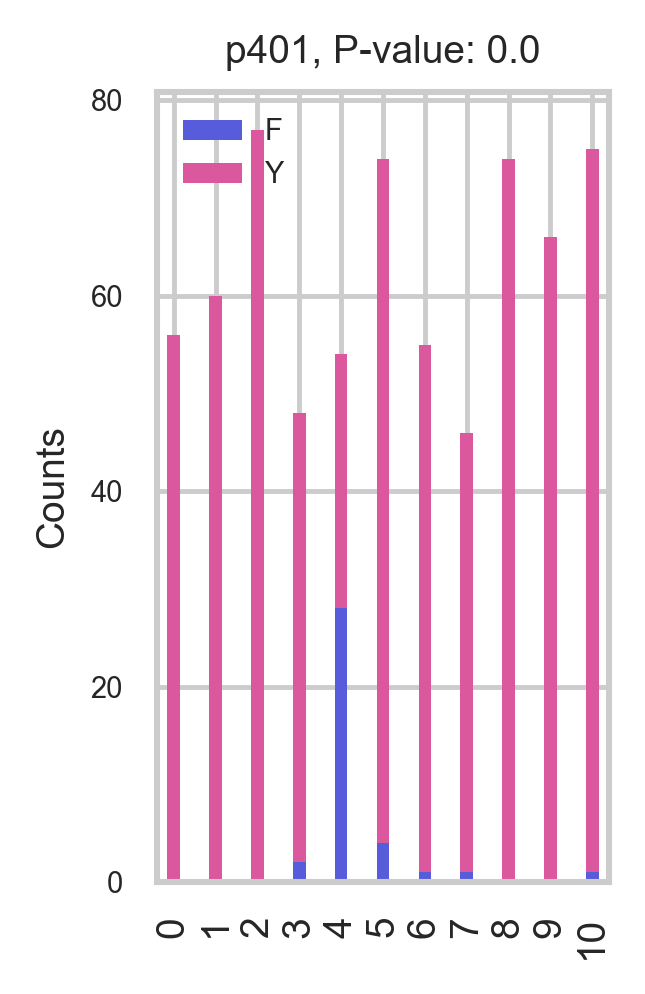

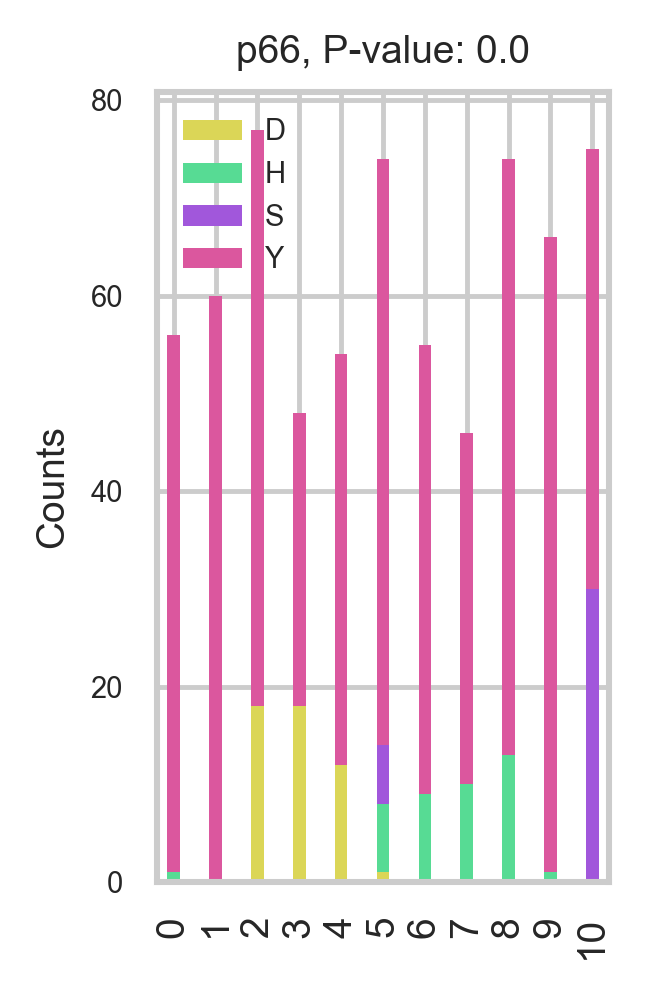

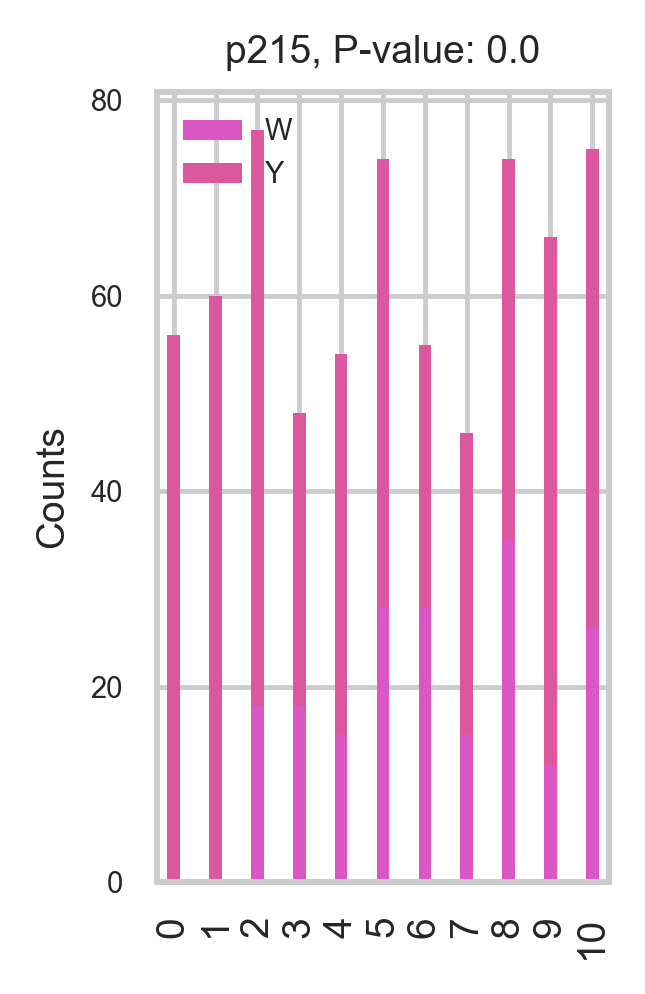

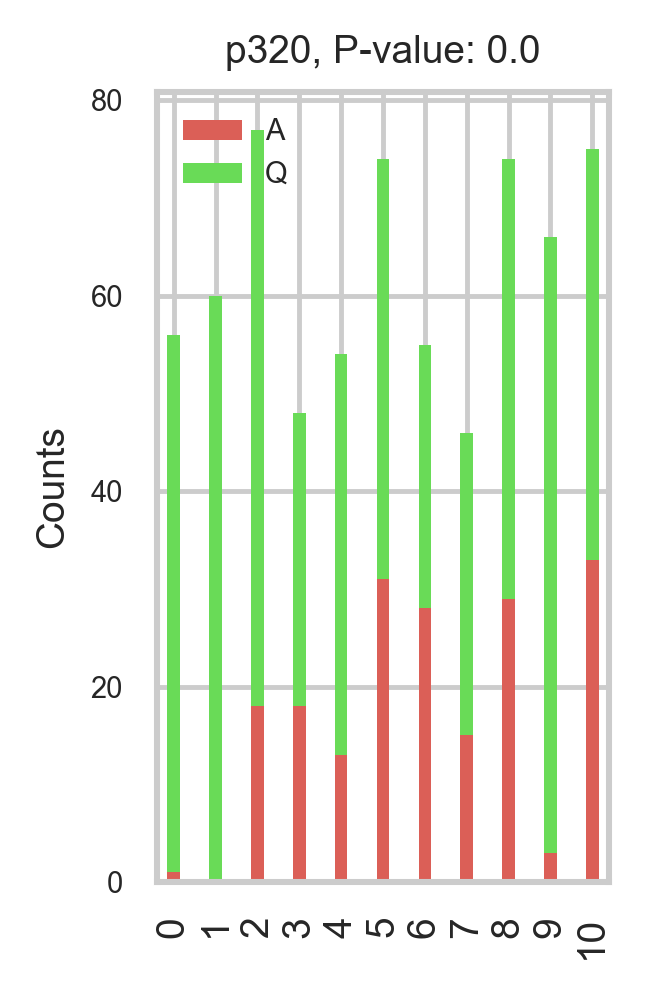

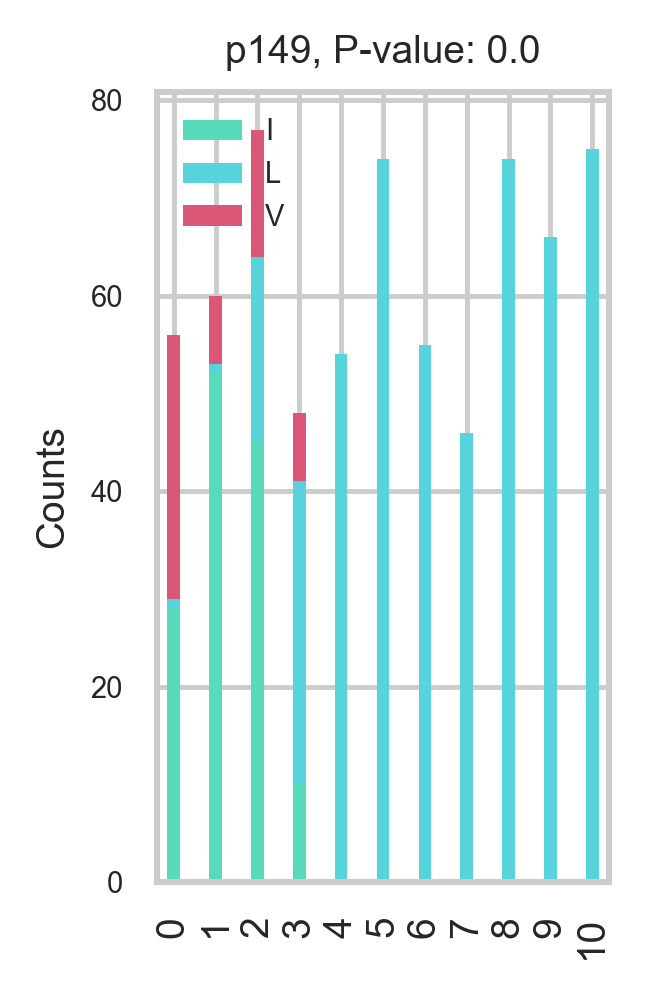

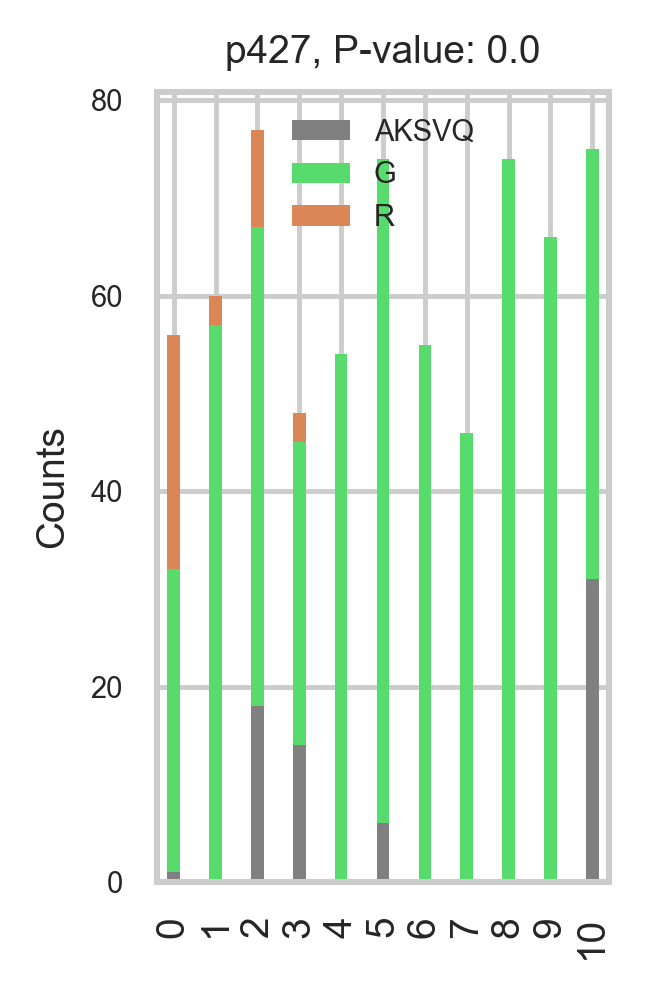

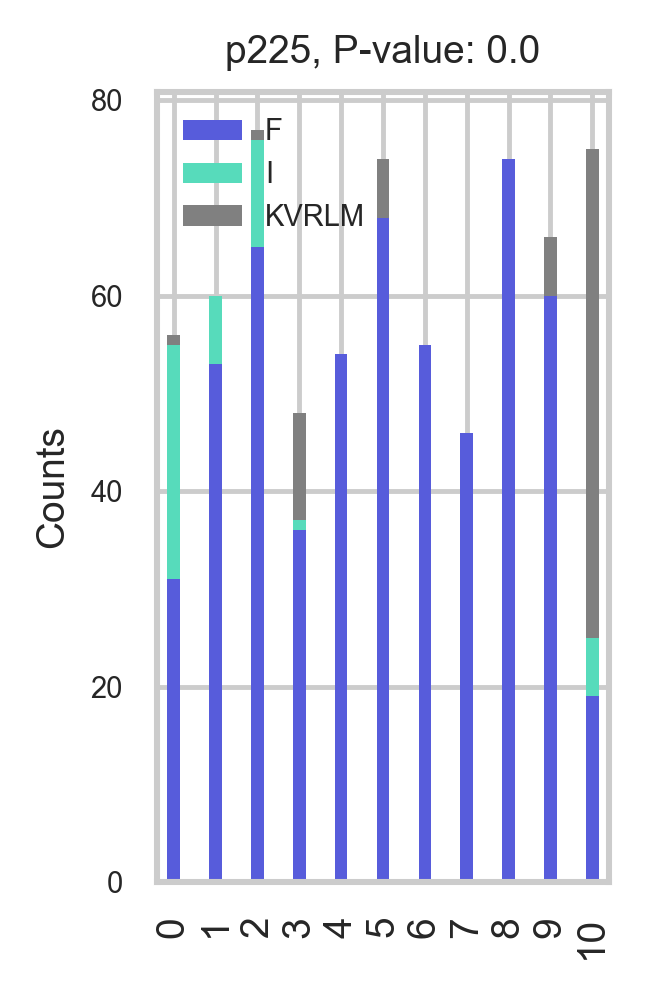

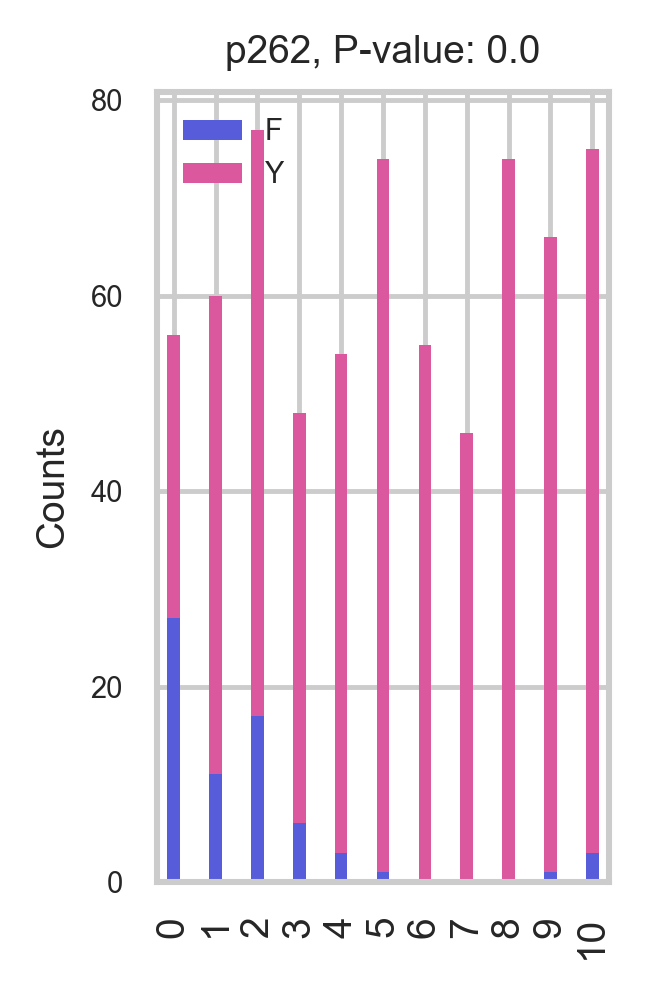

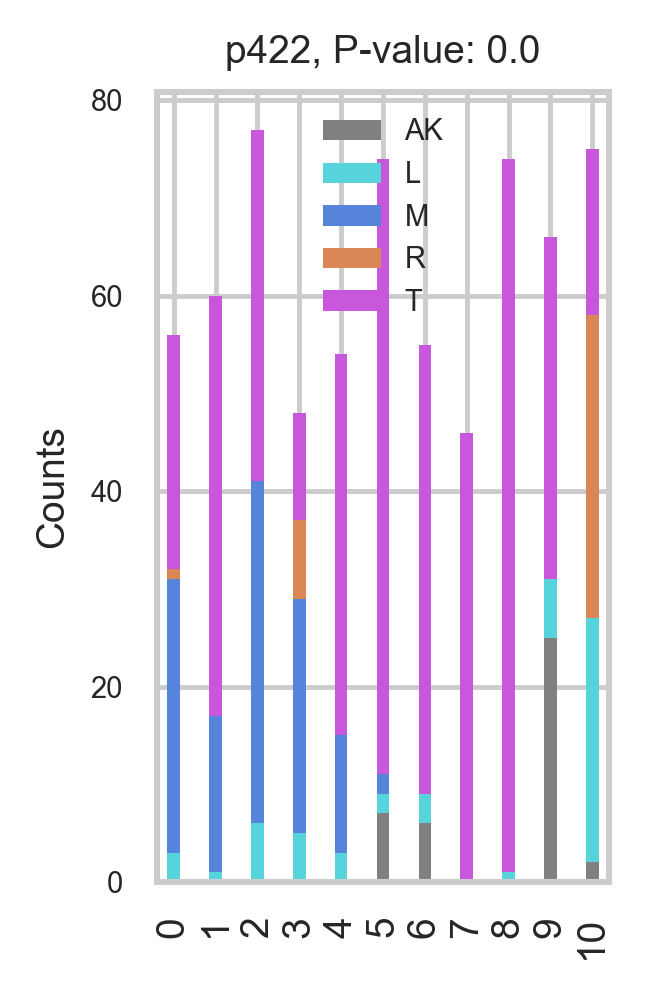

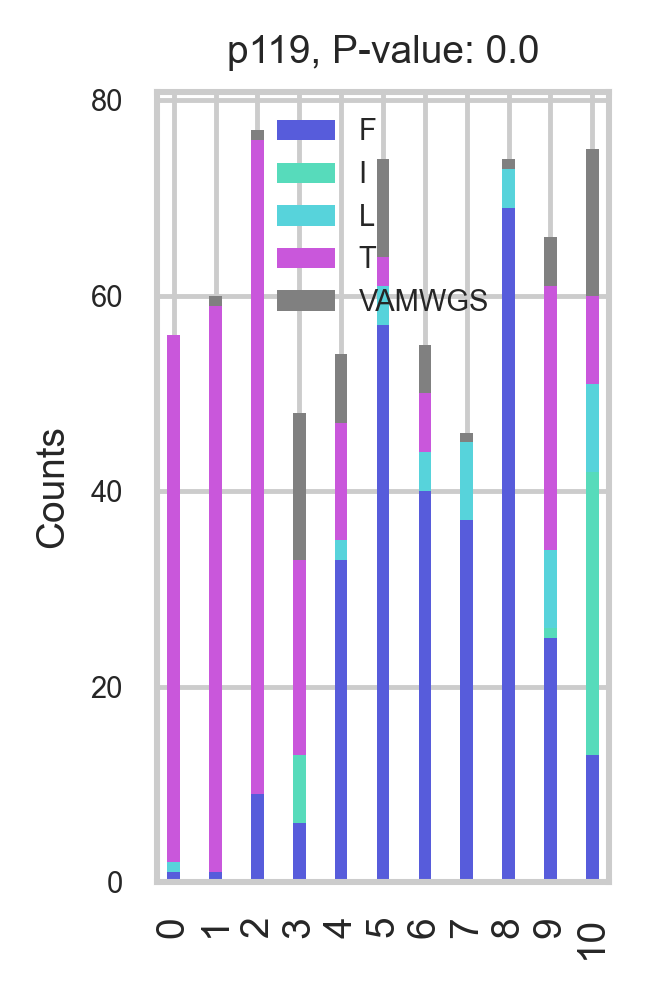

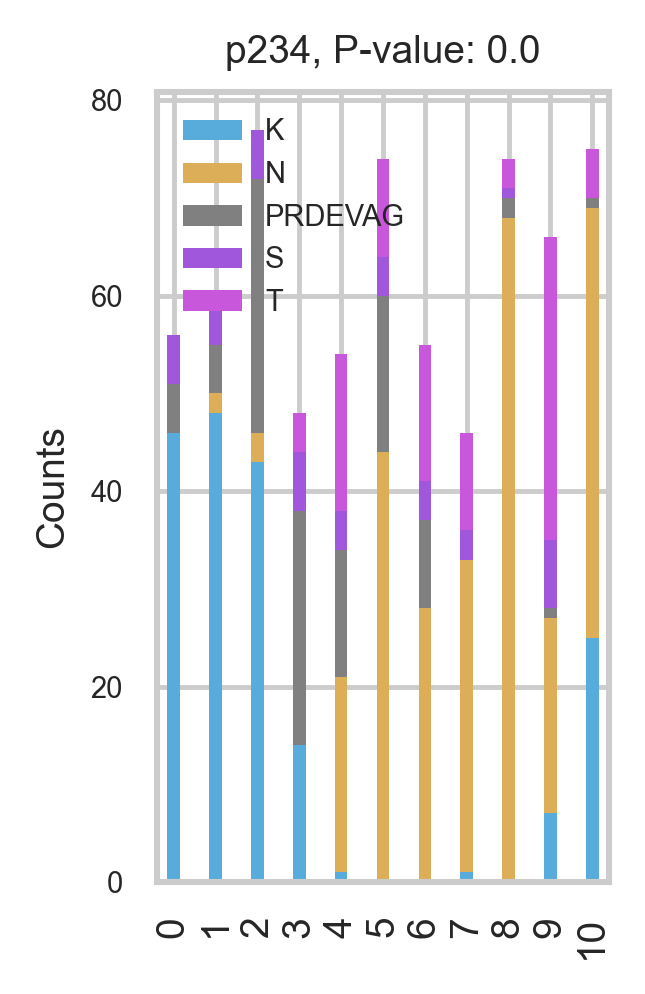

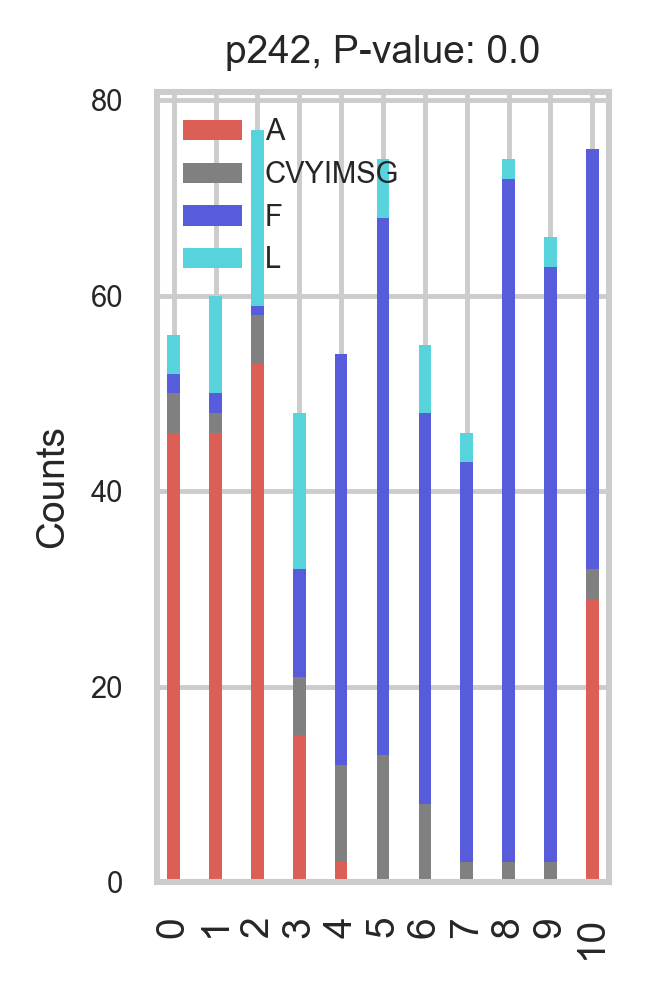

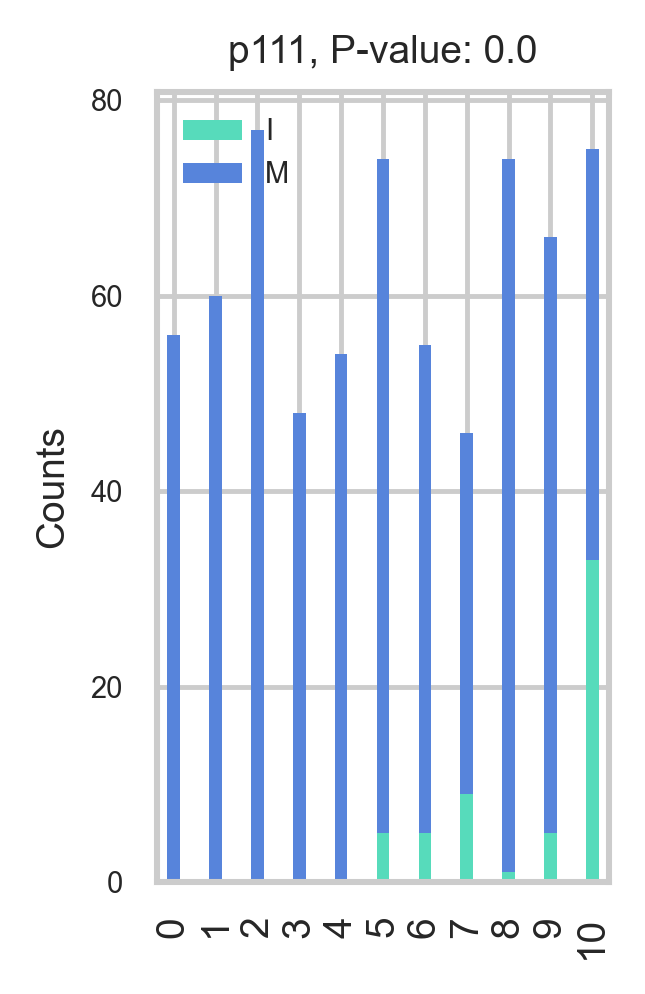

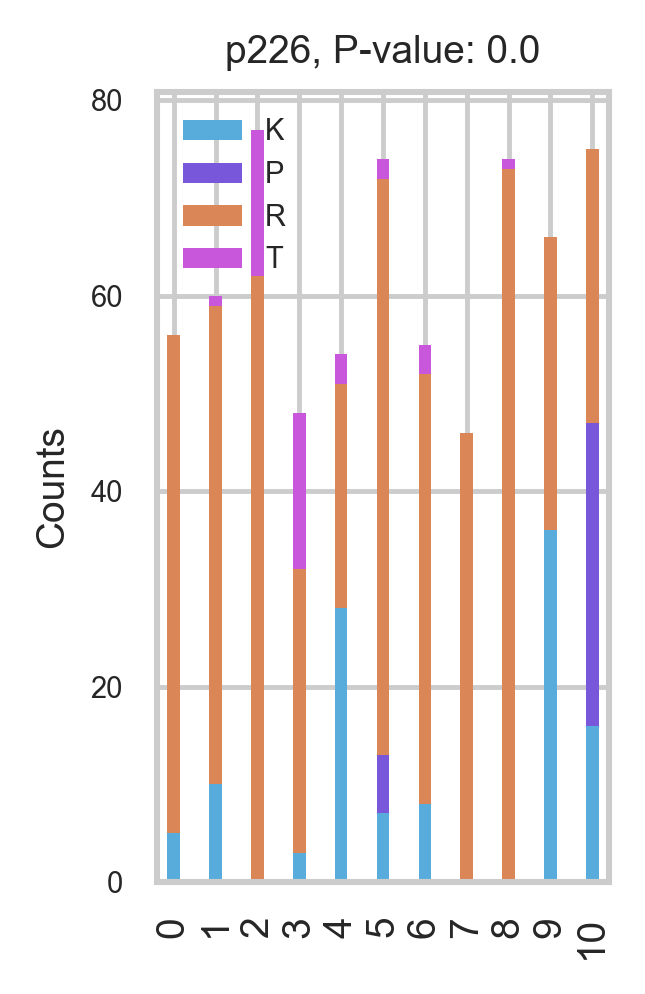

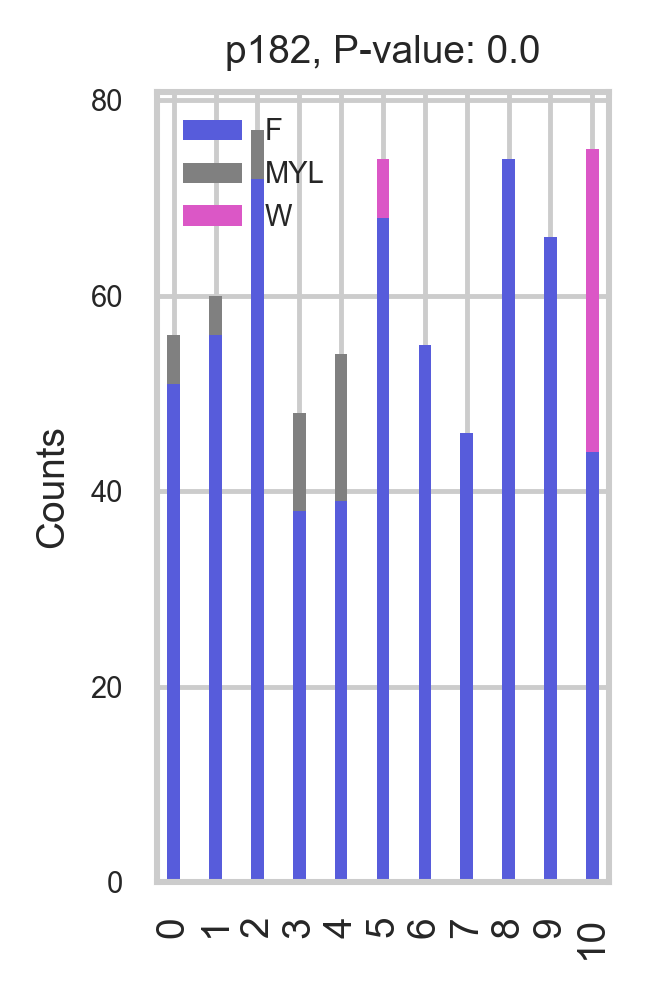

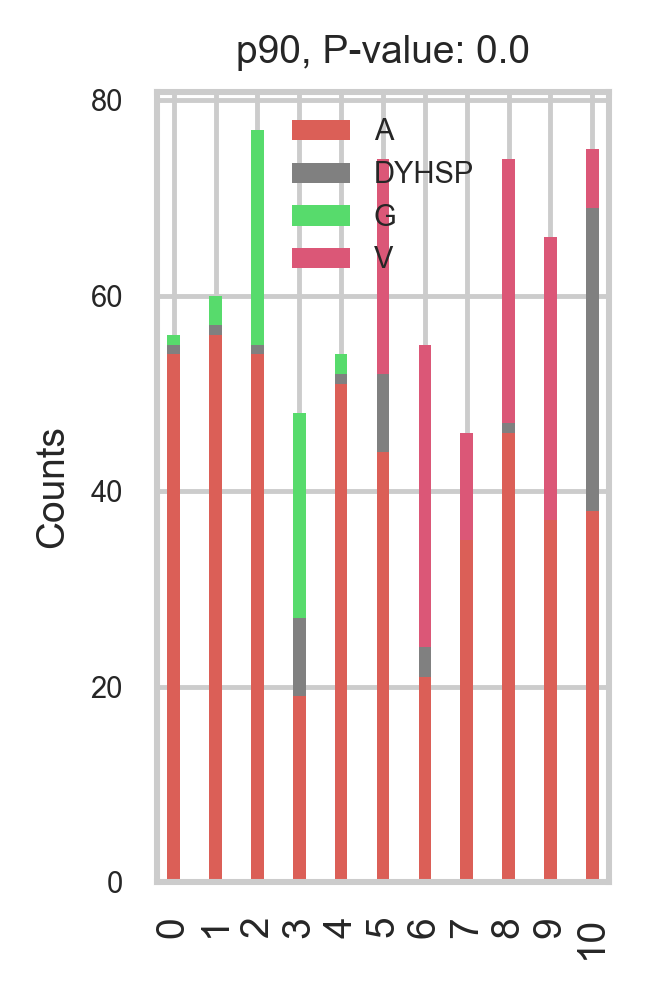

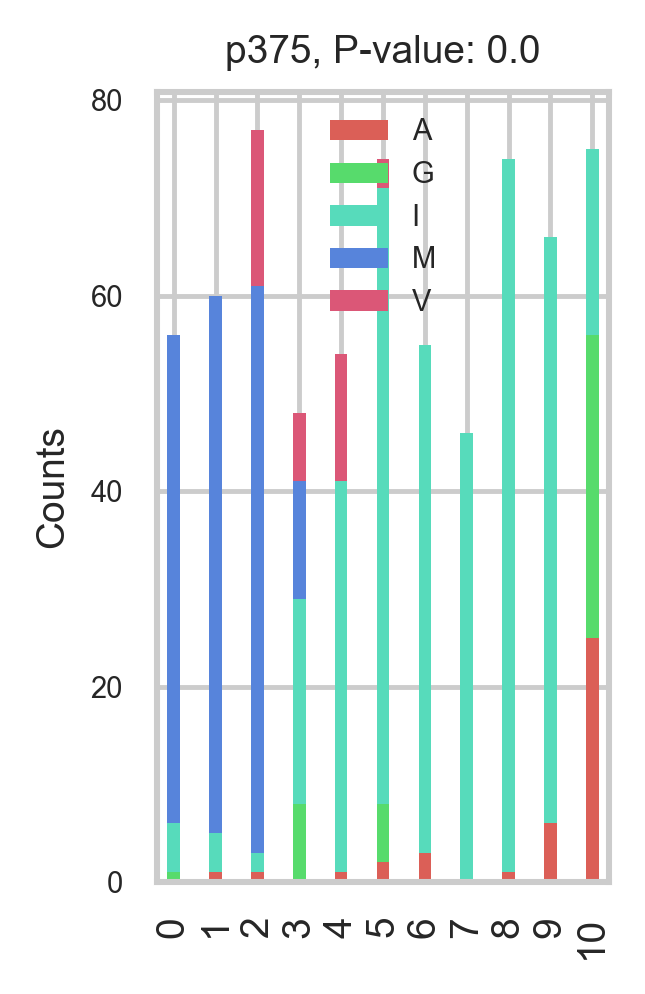

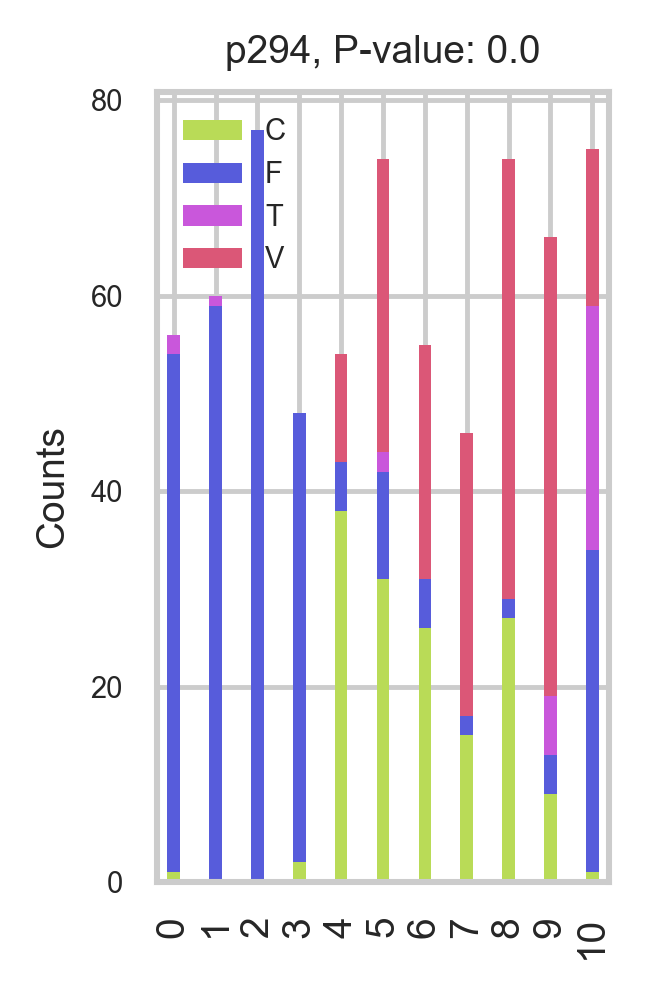

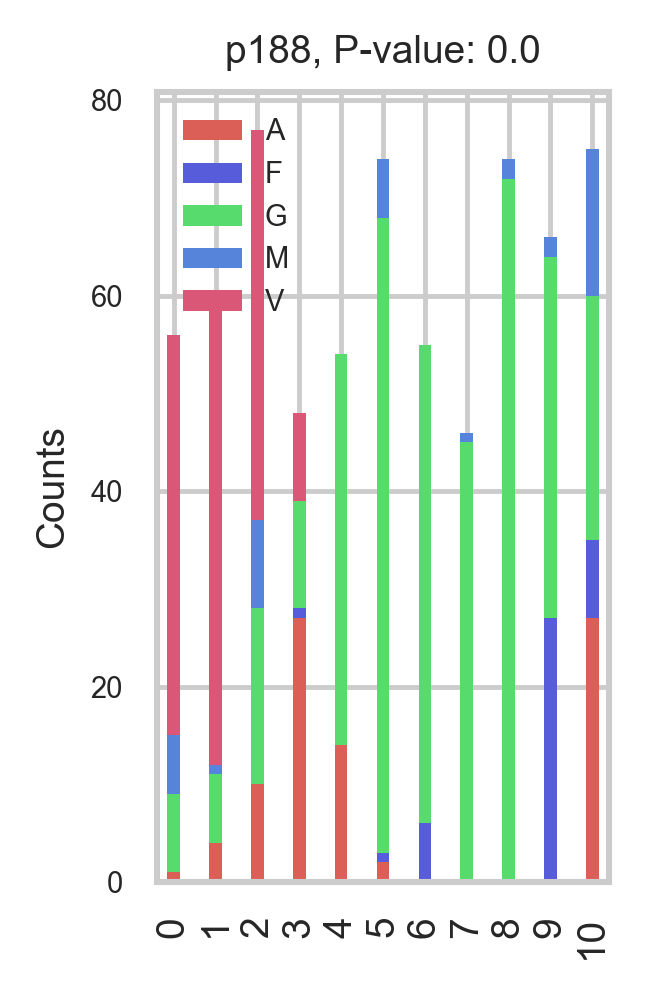

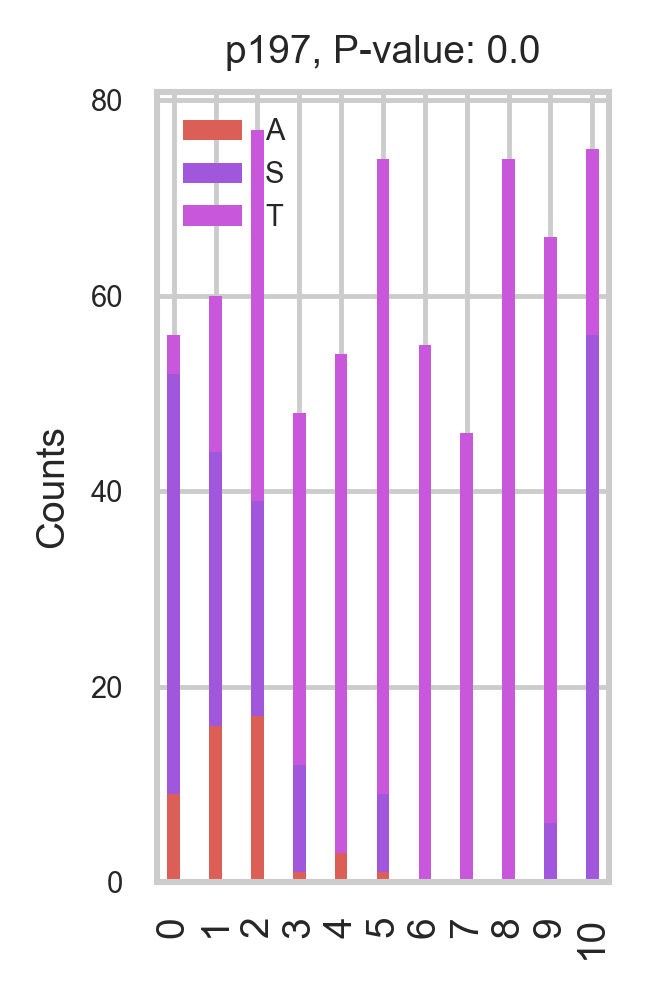

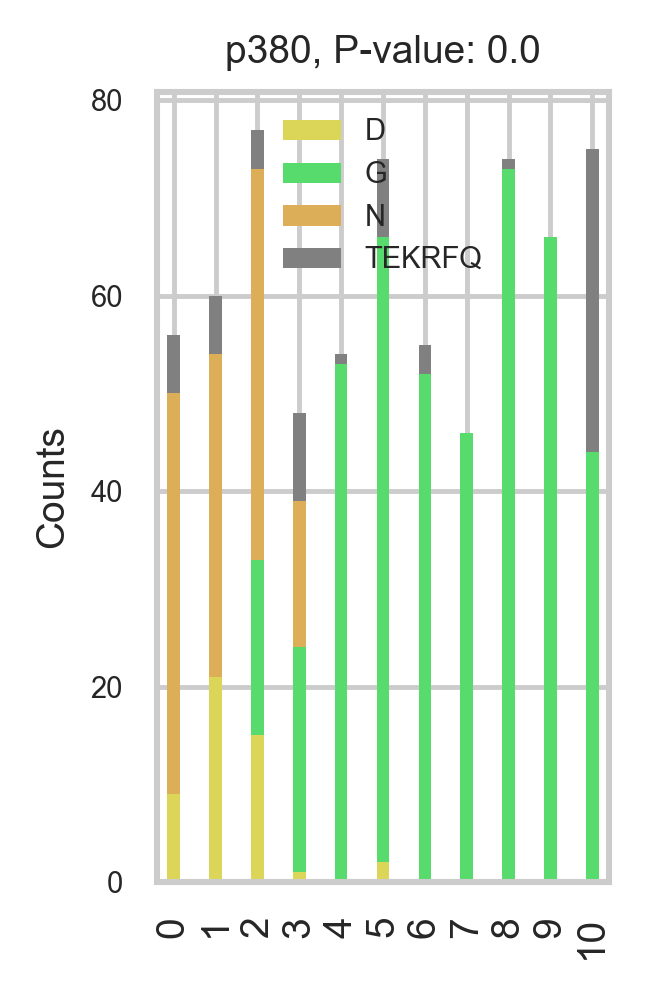

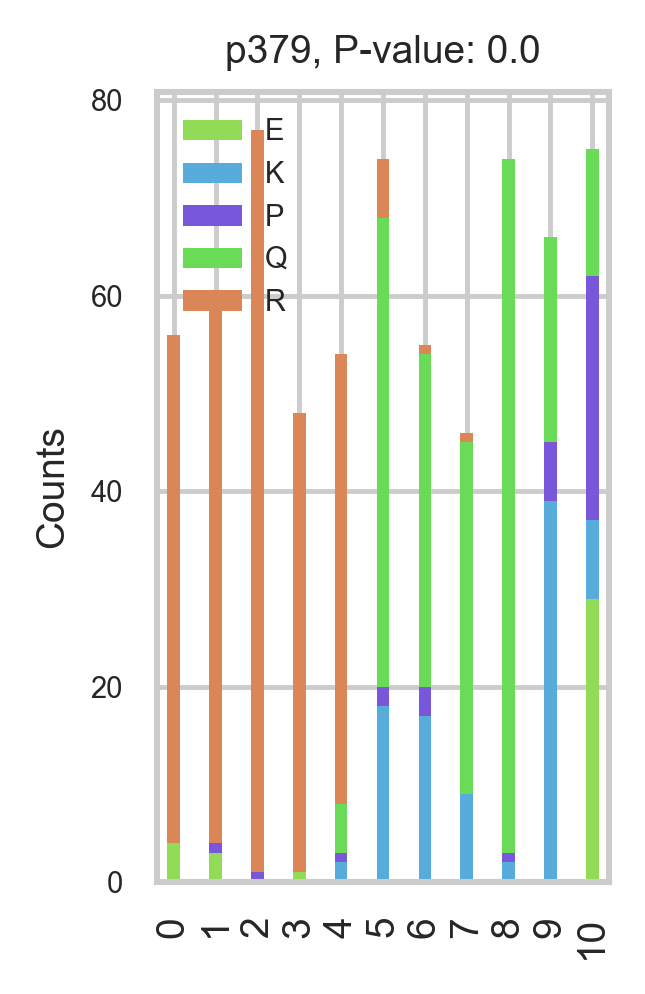

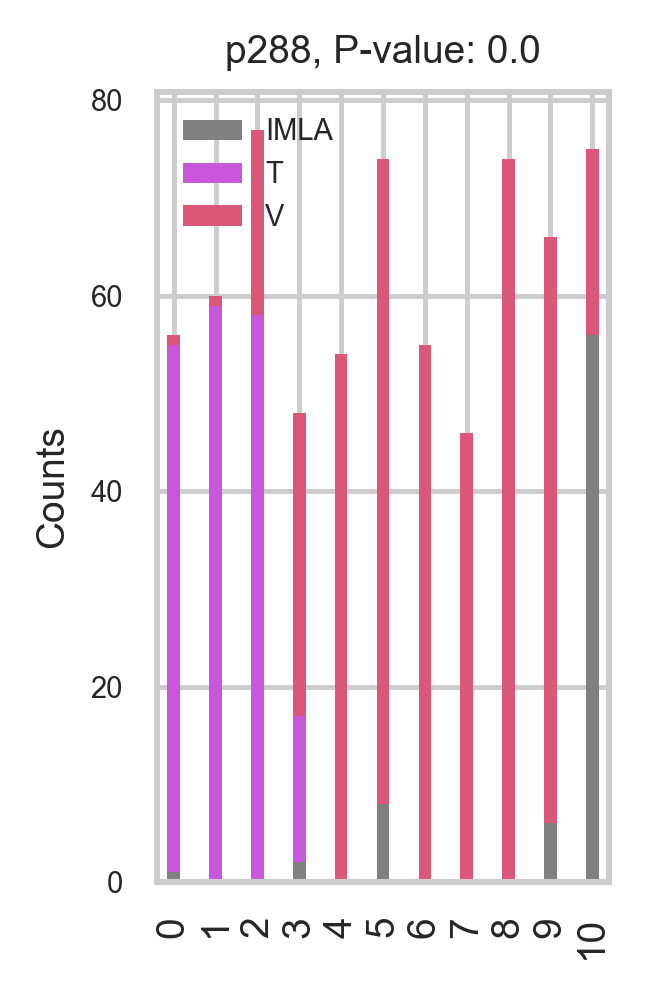

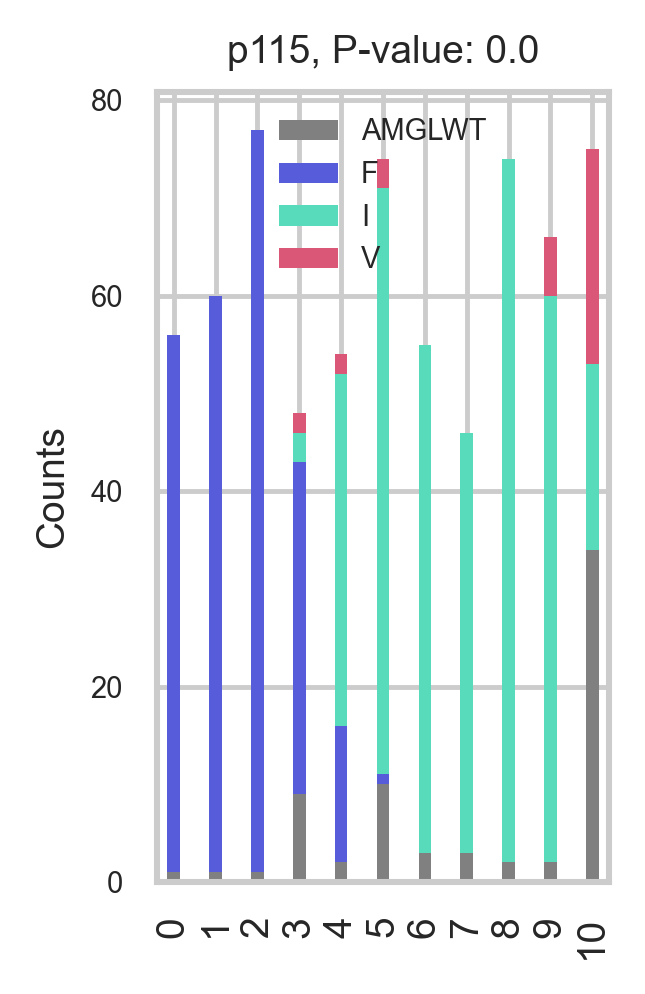

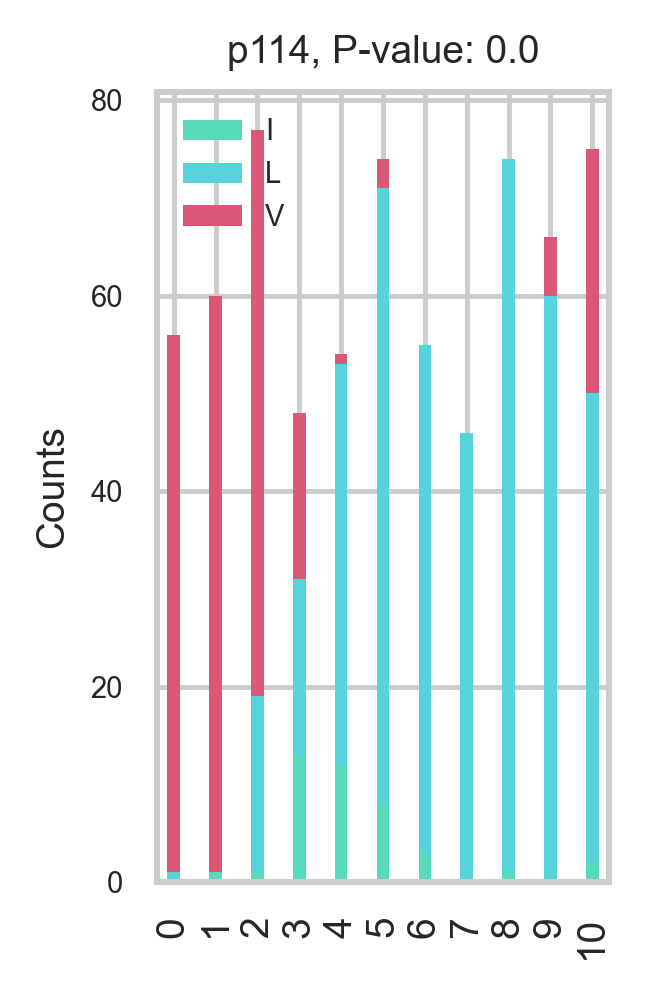

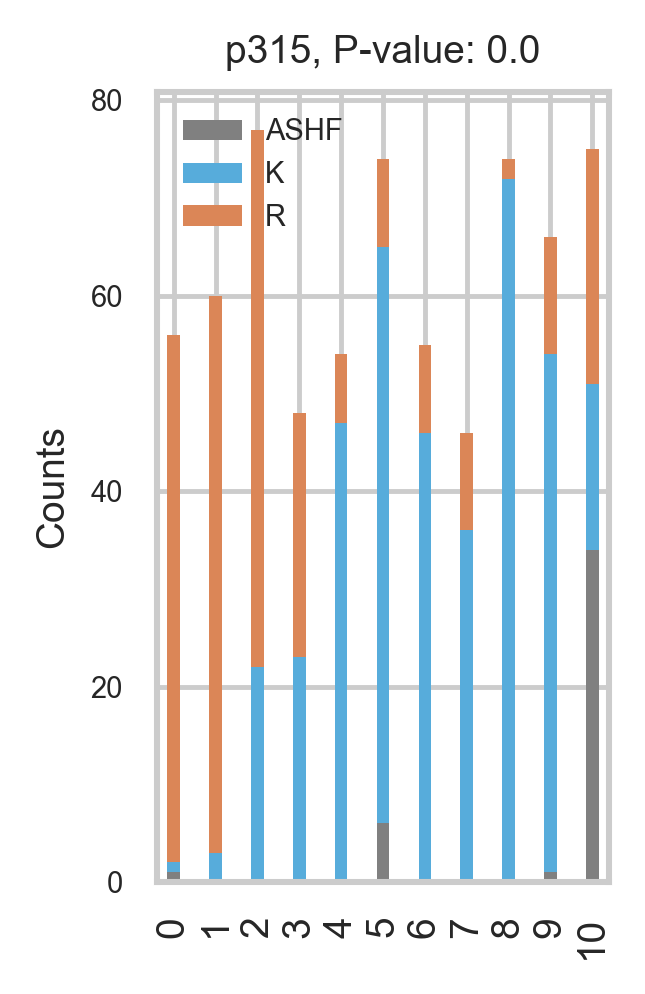

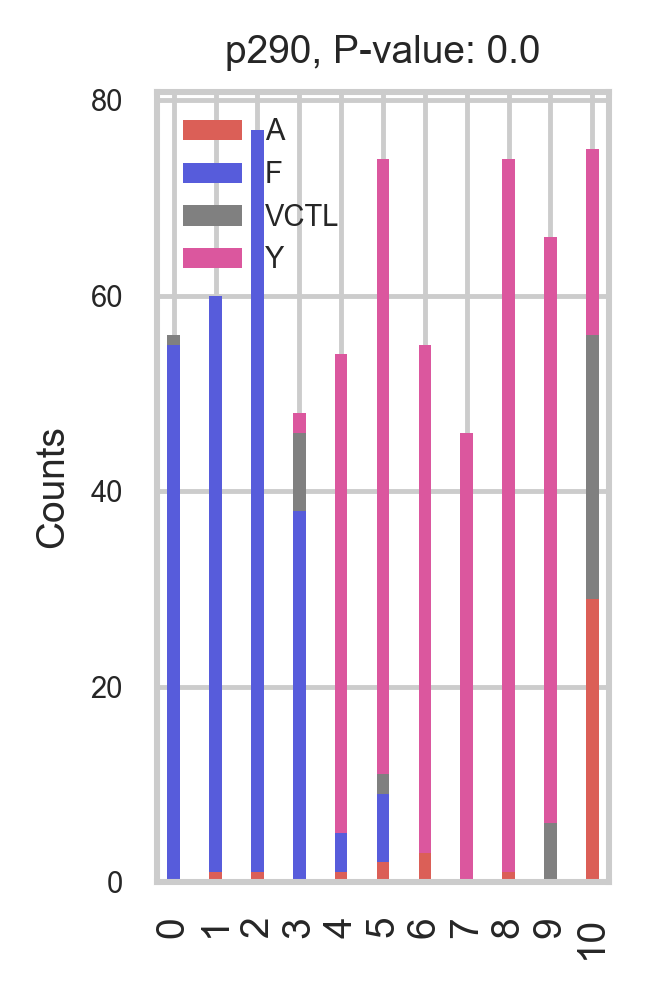

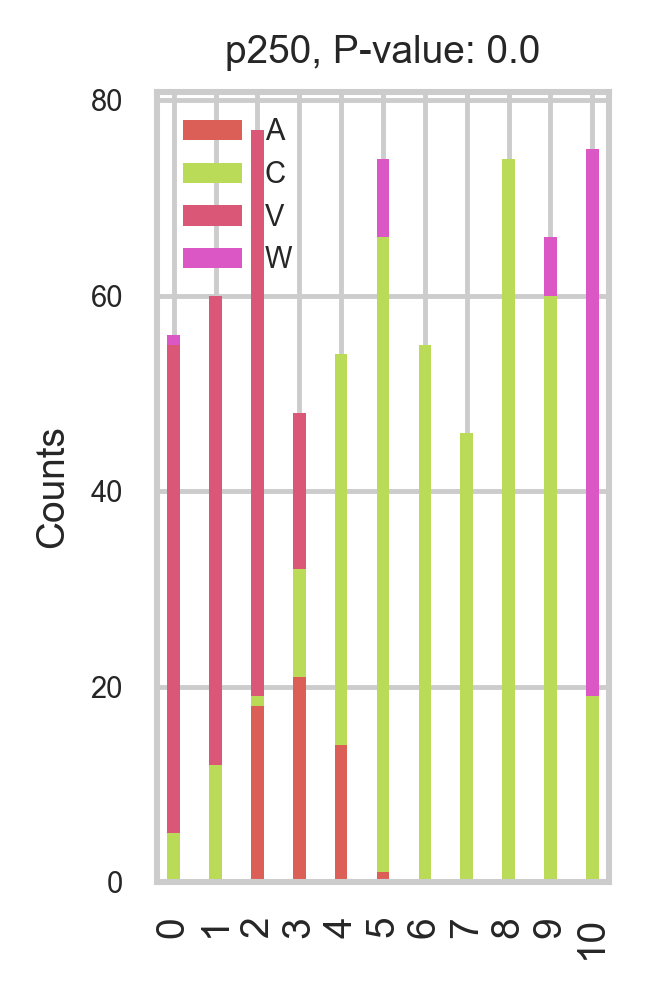

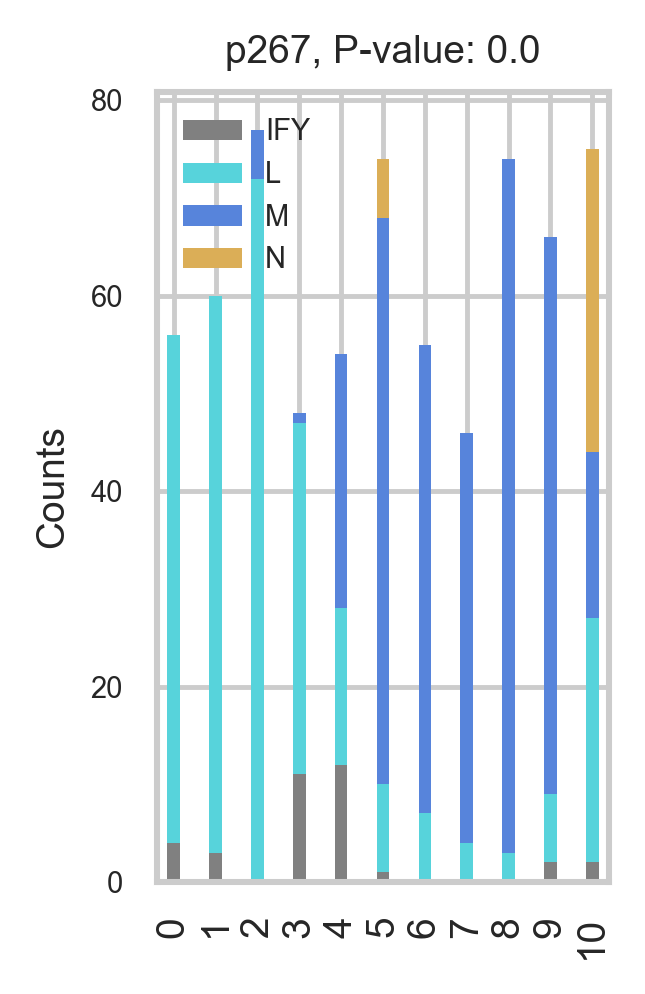

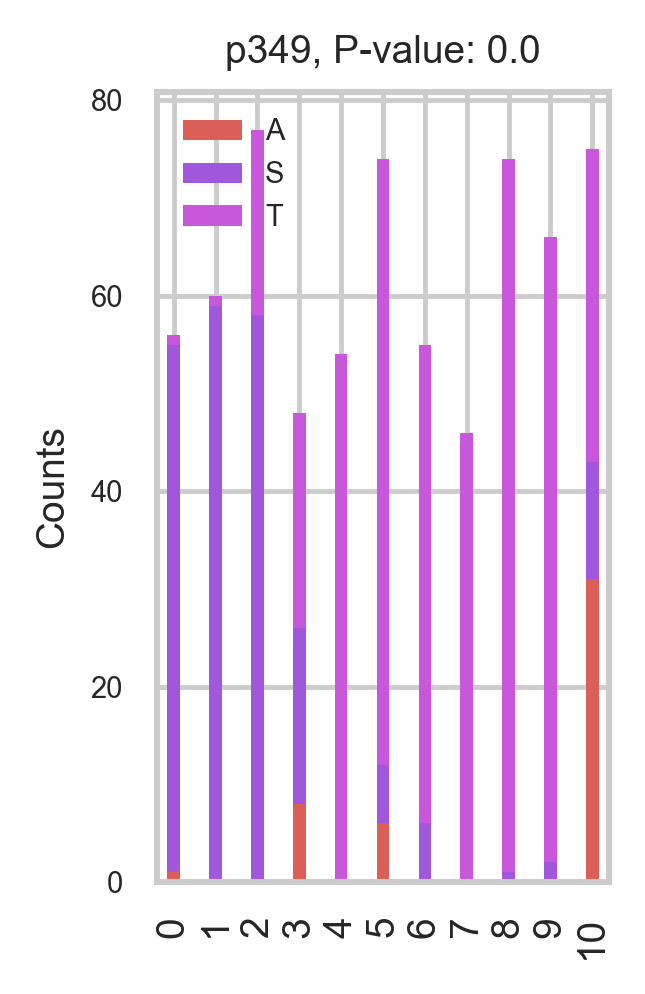

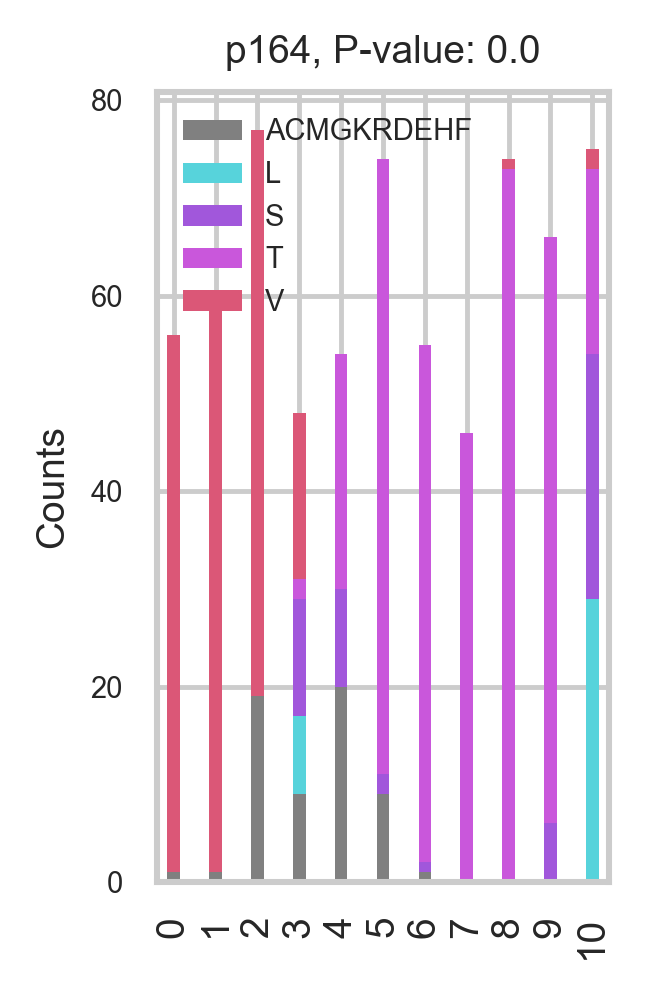

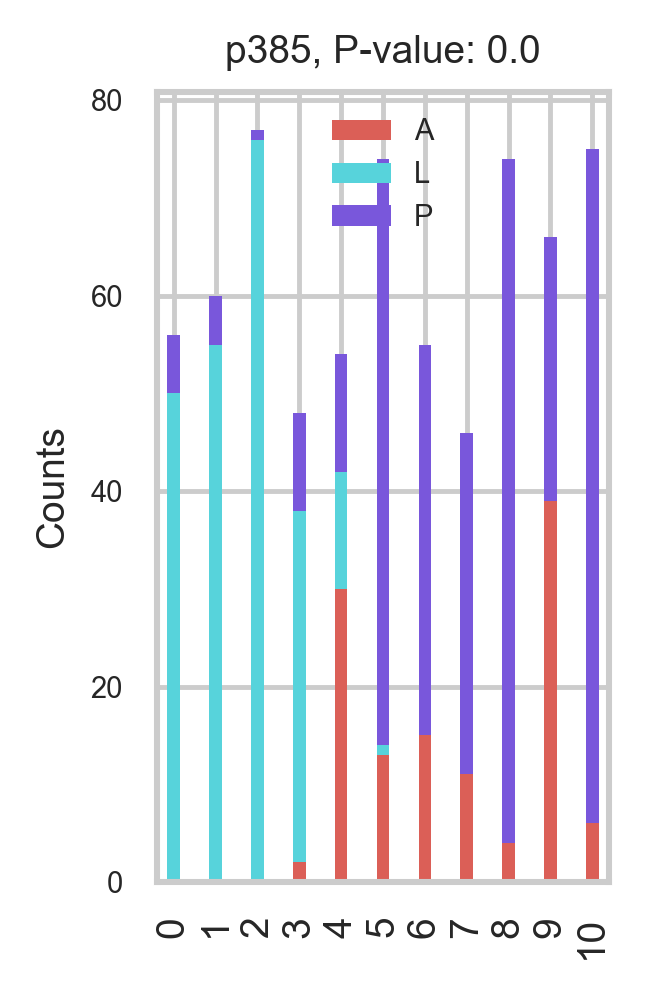

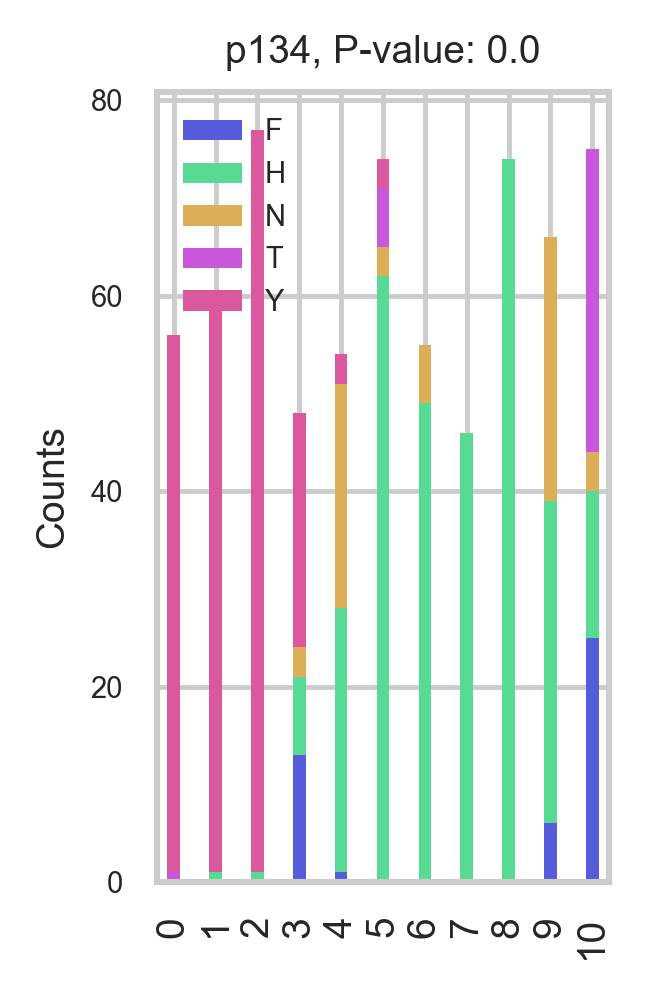

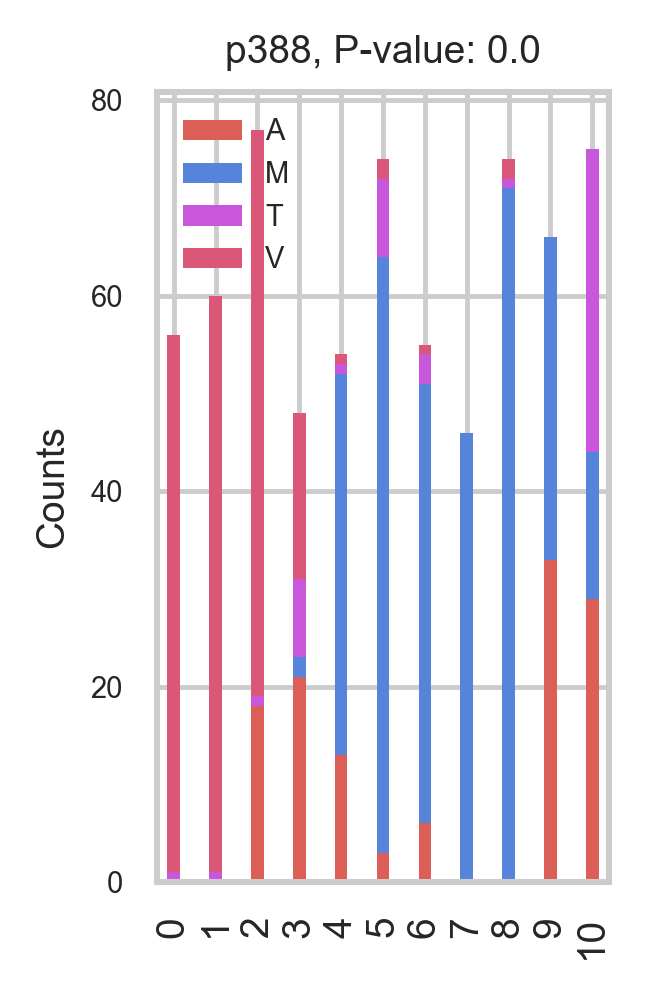

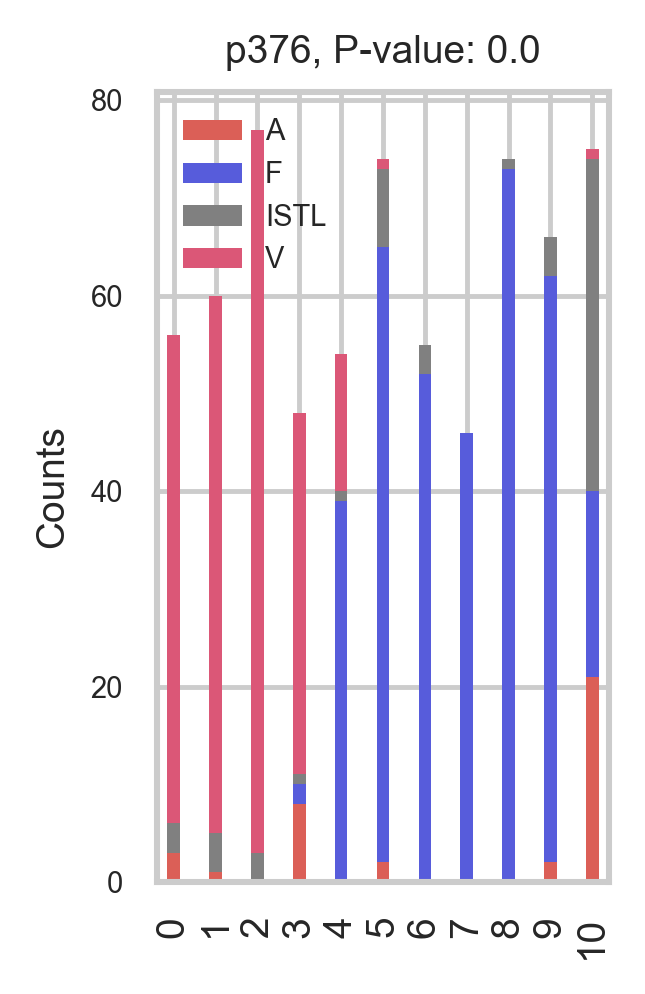

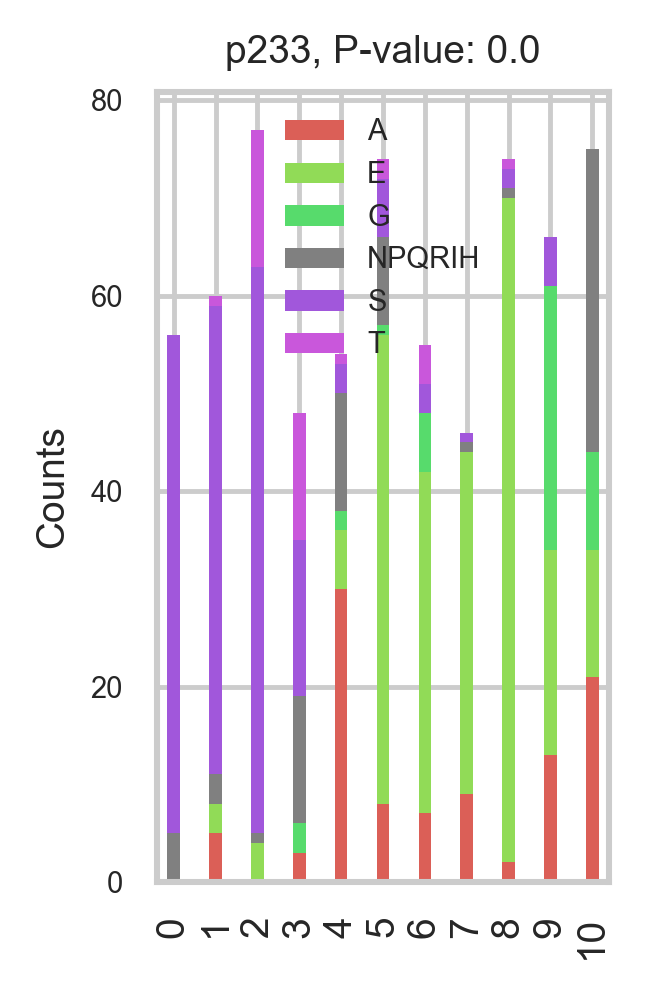

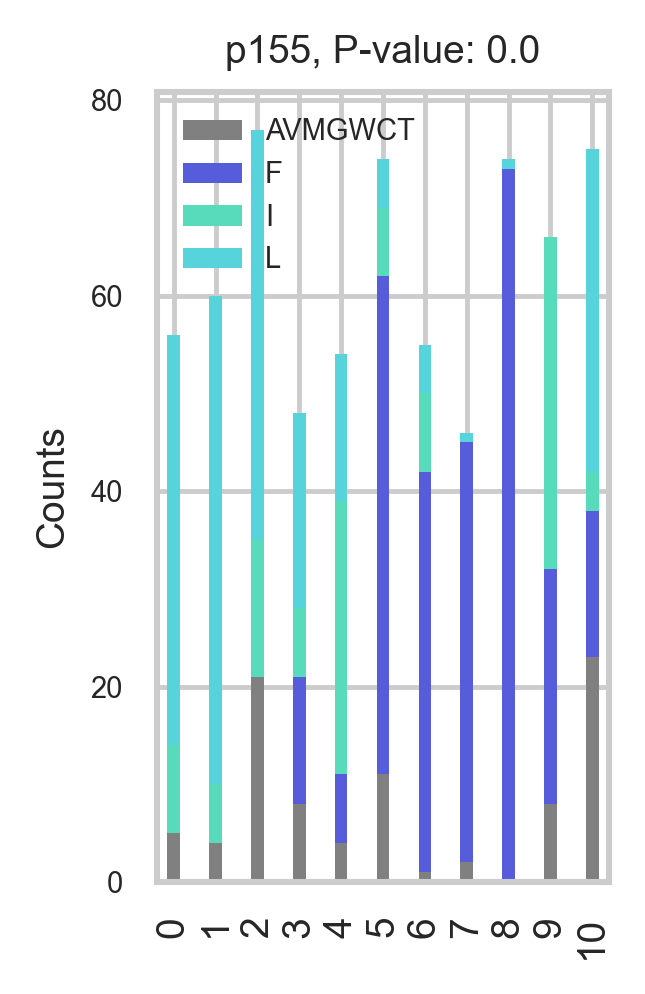

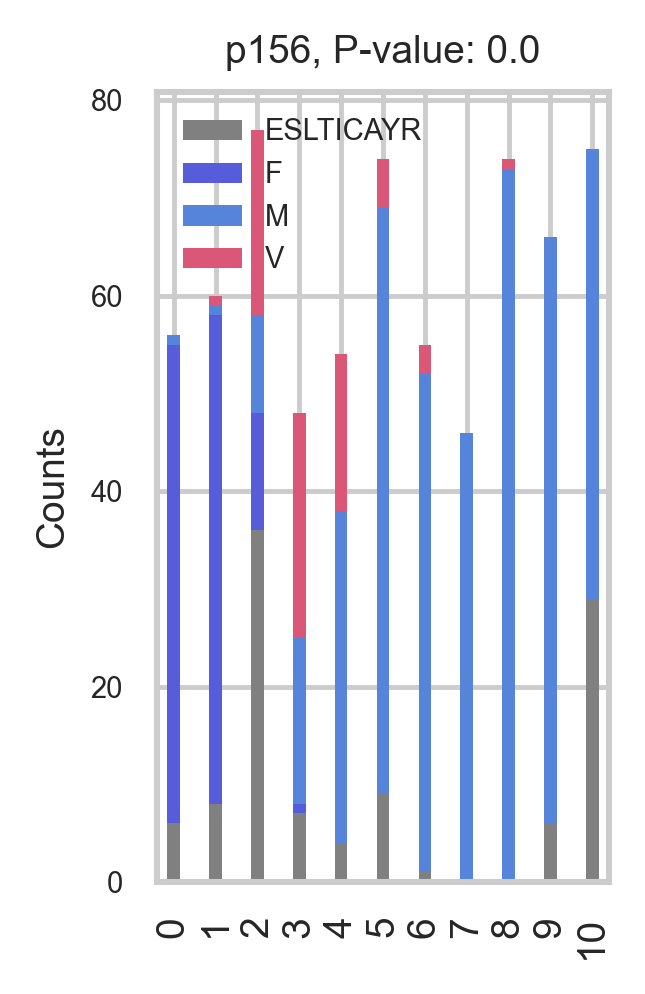

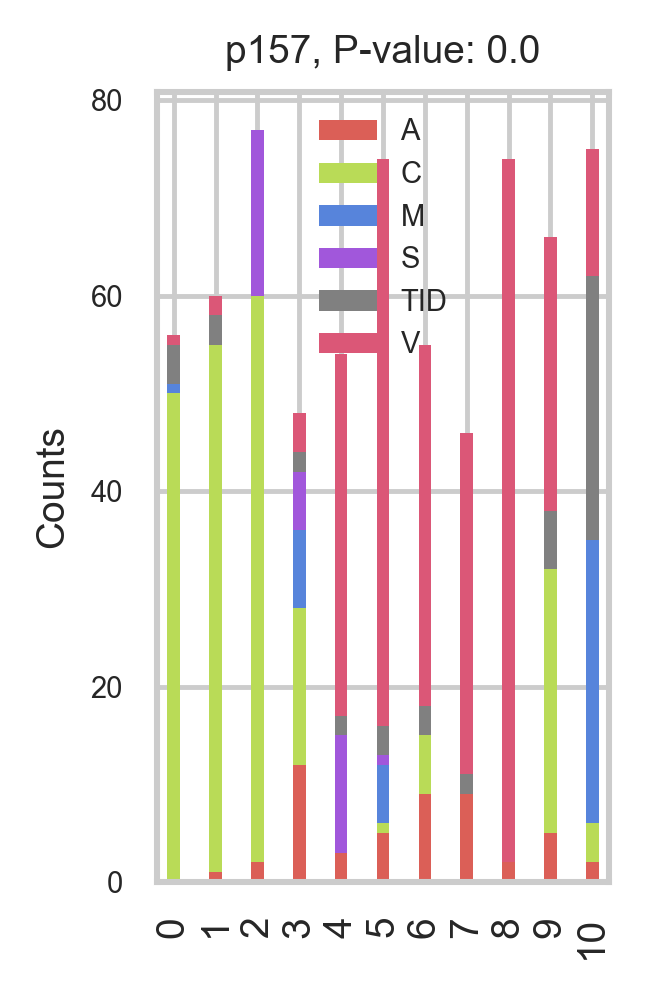

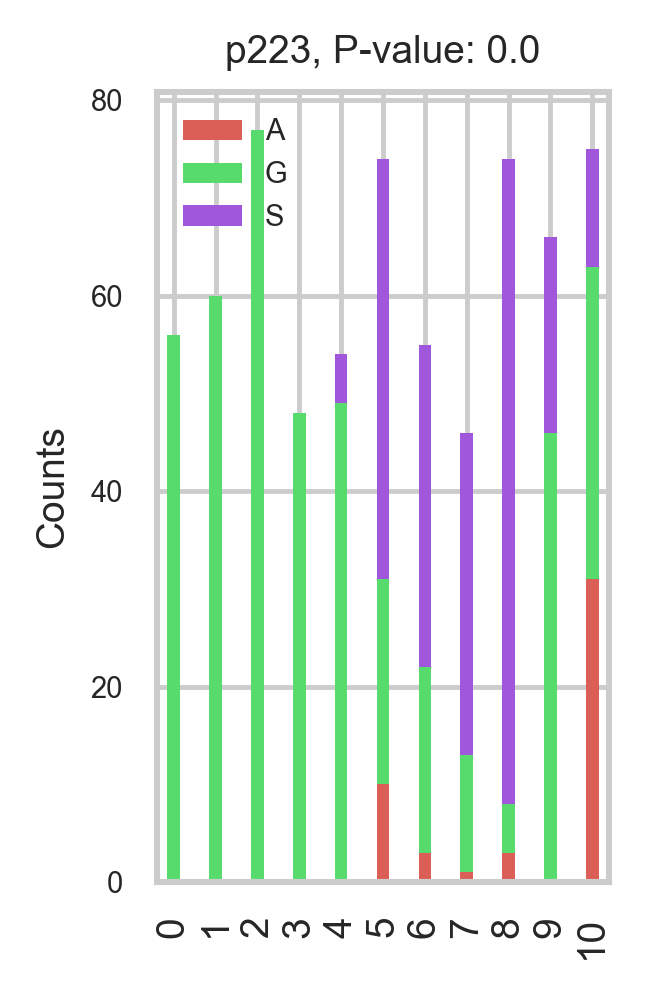

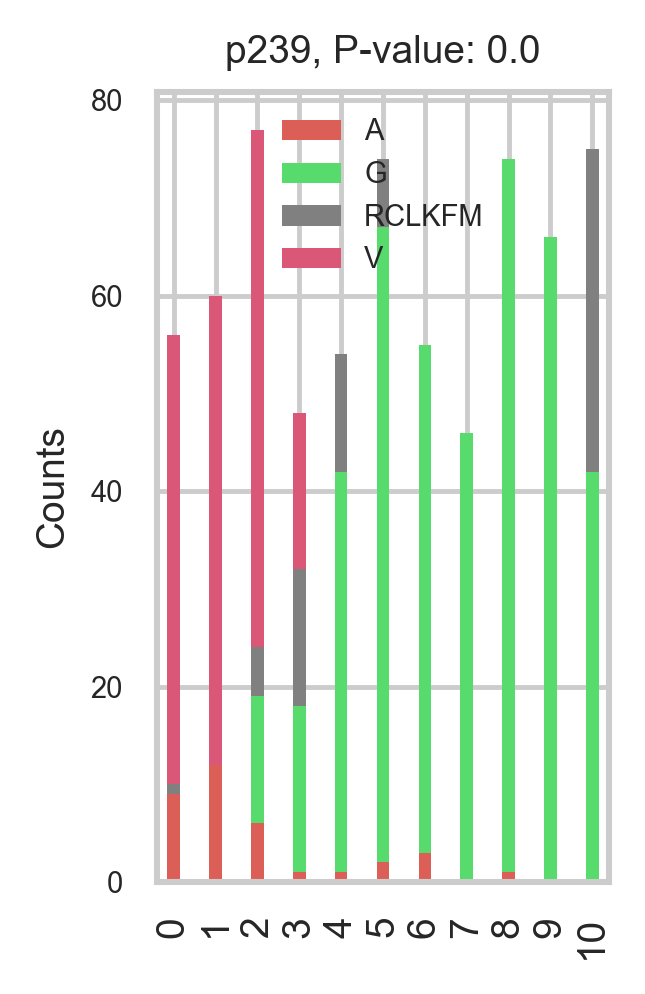

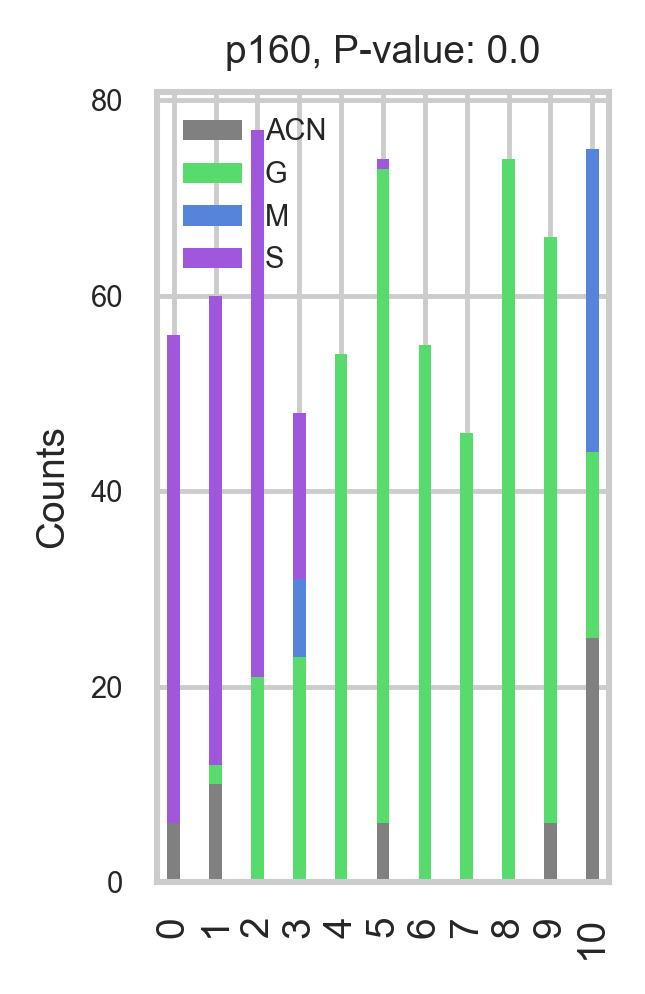

In [59]:
# visualizing top positions 
viz.plot_imp_all(trained_models=top_models, dat=df, train_cols=train_cols,
                 grouped_features=dc, meta_var=mt, model_type=anaType,
                 n_positions=positions, report_dir=report_dir)

In [60]:
import pandas as pd
models = pd.read_csv(report_dir+ '/models_summary.csv', index_col=0)

In [61]:
models

Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.6242  0.9198  0.6079  0.6474   
gbc          Gradient Boosting Classifier    0.6221  0.9187  0.6071  0.6393   
xgboost         Extreme Gradient Boosting    0.6200  0.9239  0.6045  0.6443   
lr                    Logistic Regression    0.5991  0.9323  0.5826  0.6216   
dt               Decision Tree Classifier    0.5992  0.8120  0.5885  0.6305   
rf               Random Forest Classifier    0.5909  0.9179  0.5782  0.6215   
et                 Extra Trees Classifier    0.5930  0.8862  0.5830  0.6169   
ridge                    Ridge Classifier    0.5866  0.0000  0.5683  0.6137   
svm                   SVM - Linear Kernel    0.5388  0.0000  0.5214  0.5846   
ada                  Ada Boost Classifier    0.2046  0.6768  0.1859  0.1524   

              F1   Kappa     MCC  TT (Sec)  
lightgbm  0.6118  0.5843  0.5891     0.068  
gbc       0.6087  0.5823  0.5865     0.298  
xgboost   0.6083  0.5797  0.5842     0.405  
lr        0.5883  0.5564  0.5613     0.337  
dt        0.5861  0.5572  0.5624     0.005  
rf        0.5832  0.5479  0.5520     0.058  
et        0.5829  0.5504  0.5552     0.800  
ridge     0.5786  0.5425  0.5475     0.004  
svm       0.5310  0.4913  0.4984     0.009  
ada       0.1494  0.1134  0.1234     0.022

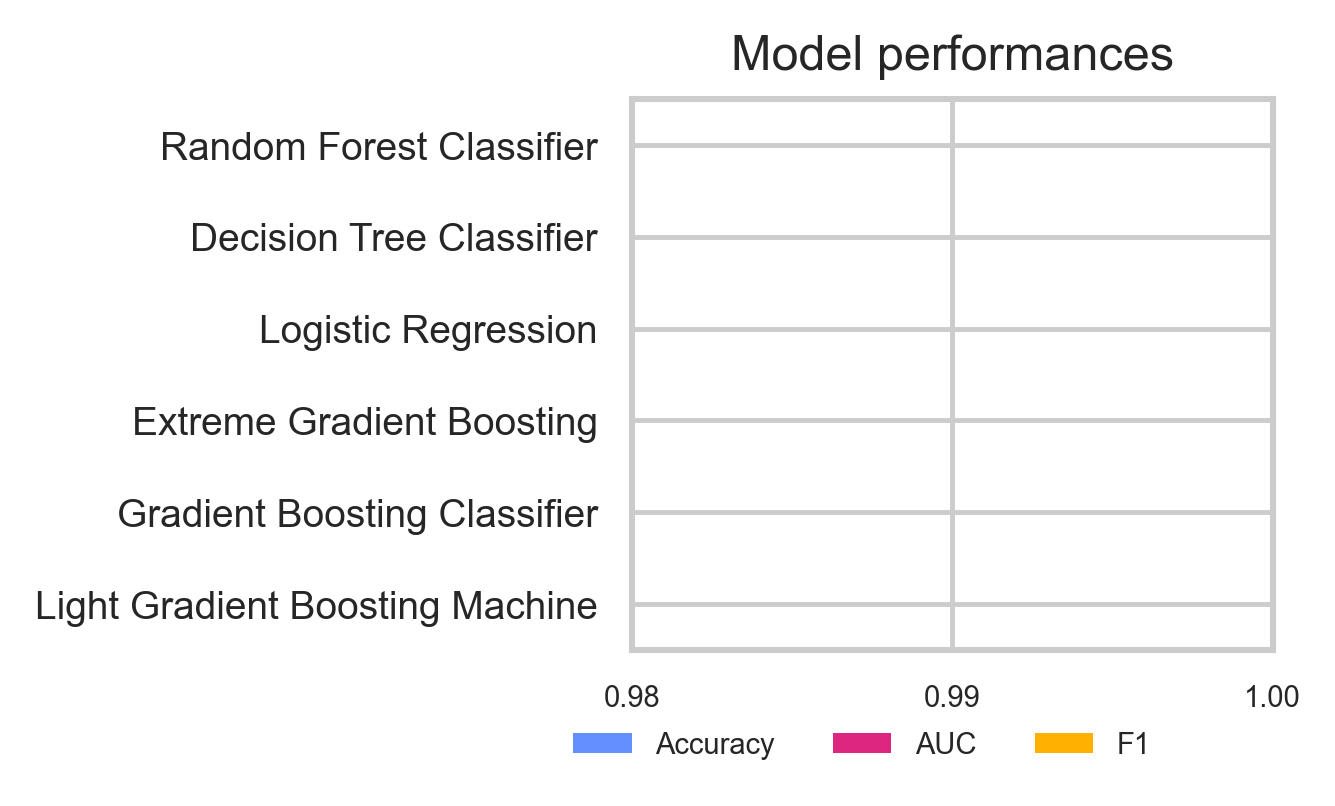

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=350)
fig = models.iloc[:6,].plot(x="Model", y=["Accuracy", "AUC", "F1"],
                           kind="barh",
                           color=['#648FFF', '#DC267F', '#FFB000'],
                           ax=ax,
                           ylim=(0,1))
ax.legend(bbox_to_anchor=(0.85, -.1), fontsize = 6, ncol=3)
ax.set_title('Model performances', fontsize=10)
ax.set_xlabel('')
plt.xticks(fontsize=6)
plt.ylabel('')
plt.xlim(.98,1)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(str(report_dir + '/model_performances.pdf'),
                bbox_inches='tight')

In [73]:
#We need to take df_for_testing and copy the column names into a new df AND take those column names and put them in a list of strings.
#for that it's something like...
x = 0
val = int(0)
data = list()
seq_dict = dict()
unseenData = 'unseen_data.fasta' 
seq_type2 = 'amino-acid'
#Following creates a dataframe of aa sequences and their positions as collumns.
df = prp.read_data(unseenData, seq_type = seq_type2, is_main=True)
df.head()
#Turning sequence names into a list for indexing
seq_name = df.index.to_list()
print(seq_name)
#for every sequence in the list of sequences the following function will occur. 
for seq in seq_name:
    data = list()
    for col in training_col_list:
        #take the str of the column name and split at the '_'
        split = str(col).split('_')
        #declare a temp position variable to index df 
        position = str(split[0])
        print(position)
        #declare the aa we will compare the df index to
        aa = str(split[1])
        print(aa)
        count = len(aa)
        #index the df column corresponding to the 'position' variable
        s = df[position]
        #assign value based on whether the aa at some position matches the training_col aa 
        if (s[seq_name[x]] == aa):
            val = int(1)
        
        elif (count > 1):
            for n in range(count):
                amino = aa[n]
                
                if (s[seq_name[x]] == amino):
                    val = int(1)
                    break
                else:
                    val = int(0)   

        else:
            val = int(0)

        data.append(val)
        #print([type(i) for i in data])
        
    seq_dict.update({seq_name[x] : data})
    x+=1
print(seq_dict)
df_for_testing = pd.DataFrame(data = seq_dict.values() , columns = training_col_list, index = seq_dict.keys(), dtype = int)
print(df_for_testing.head())

file3 = open('fmt_data_cols.txt', 'a+')
training = str(df_for_testing.to_string())
file3.write(training)
file3.close()

['S378_OC1', 'S551_OC7', 'S318_OC3', 'S589_OC1', 'S225_OC8']
p66
H
p91
N
p91
S
p92
M
p93
W
p94
K
p104
Y
p105
S
p106
GCSFT
p106
I
p106
M
p106
V
p108
T
p109
CLISGT
p109
V
p111
M
p113
ICTVSA
p113
L
p113
M
p115
V
p116
F
p116
I
p116
L
p116
V
p117
FGMCS
p117
I
p117
L
p117
T
p117
V
p119
L
p119
VAMWGS
p120
S
p121
V
p123
G
p123
ILTS
p123
V
p124
M
p132
F
p132
I
p132
V
p133
K
p133
Q
p133
R
p151
I
p151
V
p152
S
p153
N
p154
TSHMCAIY
p158
C
p158
L
p158
TGSM
p158
V
p159
IVLMTEK
p162
SAL
p163
LMQFA
p163
P
p163
V
p165
I
p165
M
p177
S
p178
IWAEVT
p178
L
p179
KRVFDMSCA
p179
N
p190
VDYSTERIMQ
p191
L
p191
MFWP
p191
V
p195
L
p195
V
p198
I
p201
Q
p203
G
p203
S
p212
V
p216
L
p216
V
p237
M
p237
VGTFSY
p238
GVTIF
p238
L
p240
I
p240
V
p241
I
p241
L
p241
SGMTF
p241
V
p242
CVYIMSG
p242
L
p245
I
p245
L
p245
TCMAG
p245
V
p246
FLYGC
p248
L
p248
S
p249
S
p249
VILTPC
p251
GC
p251
S
p252
GTFSMC
p252
L
p252
V
p256
L
p263
WLMA
p269
VSG
p270
S
p280
P
p289
L
p289
M
p289
V
p293
I
p293
TSGLF
p293
V
p297
I
p297
M
p297
SLYG
p29

In [78]:
#interact//model for classification
# save pipeline
save_model(top_models[0], 'YOUR_MODEL_NAME')
# load pipeline
YOUR_MODEL_NAME = load_model('YOUR_MODEL_NAME')

#interpret_model(top_models[0])
 
predict_model(YOUR_MODEL_NAME, data = df_for_testing)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


p66_H  p91_N  p91_S  p92_M  p93_W  p94_K  p104_Y  p105_S  \
S378_OC1      0      0      0      0      1      0       0       0   
S551_OC7      0      0      0      0      1      0       0       1   
S318_OC3      0      1      0      0      0      0       0       0   
S589_OC1      0      0      0      1      1      0       0       0   
S225_OC8      0      0      0      0      1      0       0       1   

          p106_GCSFT  p106_I  ...  p230_S  p234_S  p281_G  p282_V  p399_S  \
S378_OC1           0       0  ...       0       0       0       0       0   
S551_OC7           0       0  ...       0       0       0       0       0   
S318_OC3           1       0  ...       0       0       0       0       0   
S589_OC1           0       0  ...       0       0       0       0       0   
S225_OC8           0       0  ...       0       0       0       0       0   

          p401_Y  p434_E  p435_E  Label   Score  
S378_OC1       1       0       0      0  0.8728  
S551_OC7       1       0       0     10  0.8597  
S318_OC3       1       1       0      4  0.3582  
S589_OC1       1       0       0      0  0.8155  
S225_OC8       1       0       0      8  0.4513  

[5 rows x 203 columns]

In [ ]:
#STEP 4: Translate Candidate STSs 
#Optional step IF running the classifier model, but could still be useful.
#To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
#Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.
#enter list of candidate STSs below
impsites = input("Enter list CSTSs: ")
#enter desired name of output text file.
#eg - If I'm translating sites from a LRM for the rods subset of my dataset I would have the output text file be named...
#output = rod_csts.txt
output = input("Enter Name of Output File: ")
seq = input("Enter Aligned Bovine Sequence: ")
site_list = impsites.split(',')
m = 0

#take the list of important sites and translate them to the bovine standard equivalent, we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for sites in site_list:

    k = int(sites)    
    gaps = seq[:k].count('-')
    #print("The number of gaps is " + str(gaps))
    trans_site = k - gaps
    #print(f"For site {k} the bovine equivalent is {trans_site}") 

    with open(output, 'a') as f:
        if m == 0:
                f.write("The following sites have been translated to the standard Bovine equivalent...\nFormat is before translation --> post translation to bovine equivalent.")   
                m+=1 
        f.write(f"Site {k} == {trans_site}\n")      